On enabling this, all the training files have to be uploaded to the root folder of the colab disk. This improves the training speeds a lot, although this has to be repeated all the time whenever the notebook is run

In [ ]:
use_colab_disk = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Checkpoints of the model are always going to be saved in the drive

In [ ]:
import os
save_dir = "/content/drive/MyDrive/midas-submission"
if os.path.isdir(save_dir) == False:
  os.makedirs(save_dir)
if use_colab_disk == False:
  os.chdir(save_dir)
else:
  os.chdir("/content/")

In [ ]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

cuda
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 916912719354190717
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13843868930691150439
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


Function for unzipping the file

Function for getting the dataset from a folder path

In [ ]:
from zipfile import ZipFile
from torchvision import transforms
import torch.utils.data as data
import torchvision

def unzip(file_name):
  with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    # zip.printdir()
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

def get_data_set(folder_path):
  transform = [
              # transforms.CenterCrop(256),
              # Crop(28),
              # transforms.Resize(256),
              transforms.Grayscale(num_output_channels=1),
              transforms.RandomRotation(degrees=20),
              transforms.ToTensor(),
              transforms.Normalize([0.5], [0.5])
  ]
  data = torchvision.datasets.ImageFolder(root=folder_path, transform=transforms.Compose(transform))
  return data

Objective of this class is to crop the high resolution images and invert them to make them in line with the MNIST dataset

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image
from IPython.display import display

class Crop(object):

    def __init__(self, size):
      self.size = size
      assert isinstance(size, int)

    def make_square(self, im, fill_color=(0)):
      x, y = im.size
      ratio = x / y
      sz = self.size
      # Ensure that the image has some padding inside square
      sz -= 4
      if x > y:
        y = sz / ratio
        x = sz
      else:
        y = sz
        x = sz * ratio
      y, x = int(y), int(x)
      # print(x, y)
      im = im.resize((x, y))
      new_im = Image.new('L', (self.size, self.size), fill_color)
      new_im.paste(im, (int((self.size - x) / 2), int((self.size - y) / 2)))
      # print(new_im.size)
      return new_im

    def crop(self, sample):
      img = np.array(sample) 
      img = img[:, :, ::-1].copy() 

      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

      ## Find the max-area contour
      # print(sample)
      cnts = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
      cnt = sorted(cnts, key=cv2.contourArea)[-1]

      ## Crop and save it
      x,y,w,h = cv2.boundingRect(cnt)
      gray = cv2.bitwise_not(gray)
      dst = gray[y:y+h, x:x+w]
      # print(dst.shape[:2])
      im_pil = Image.fromarray(dst)
      res = self.make_square(im_pil)
      # display(res)
      return res
    
    def crop_all(self, rootdir):
      print(f'Cropping all images now to {self.size} x {self.size} ...')
      for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            path = os.path.join(subdir, file)
            img = Image.open(path)
            img = self.crop(img)
            save_dir = os.path.join(rootdir + '_modified', path[path.find('/') + 1 : path.rfind('/')])
            # print(save_dir)
            if os.path.isdir(save_dir) == False:
              os.makedirs(save_dir)
            save_path = os.path.join(rootdir + '_modified', path[path.find('/') + 1:])
            # print(save_path)
            img.save(save_path)
      print(f'cropped images saved to {rootdir}_modified')
      return rootdir + '_modified'

In [ ]:
unzip('trainPart1.zip')

Extracting all the files now...
Done!


Apply pre-processing on the provided dataset -

1.   Crop the images in the dataset to size 28 x 28 by applying rectangular bounding box on the images
2.   Invert the color of the image so as to match with the dataset of mnist
3.   Finally save these in a separate folder and provide its path



In [ ]:
cp = Crop(28)
cropped_path_62 = cp.crop_all('train')

cropped images saved to train_modified


This zip has been created manually from the trainining data and contains the data points for digits 0 - 9 only



In [ ]:
unzip('train_digits.zip')

Extracting all the files now...
Done!


In [ ]:
cp = Crop(28)
cropped_path_10 = cp.crop_all('train_digits')

Cropping all images now to 28 x 28 ...
cropped images saved to train_digits_modified


In [ ]:
unzip('mnistTask3.zip')

Extracting all the files now...
Done!


Define the CNN architecture

Final layers in the model can vary according to the number of characters in the dataset

In [ ]:
from torch import nn

class CNN(nn.Module):
    def __init__(self, fc):
      super().__init__()
      self.cnn_net = nn.Sequential(
          nn.Conv2d(1, 64, 3), # 28 x 28 -> 26 x 26
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.Conv2d(64, 64, 3), # 26 x 26 -> 24 x 24
          nn.ReLU(),
          nn.MaxPool2d(2, 2), # 24 x 24 -> 12 x 12
          nn.BatchNorm2d(64),
          nn.Conv2d(64, 128, 3), # 12 x 12 -> 10 x 10
          nn.ReLU(),
          nn.BatchNorm2d(128),
          nn.Conv2d(128, 128, 3), # 10 x 10 -> 8 x 8
          nn.ReLU(),
          nn.MaxPool2d(2, 2), # 8 x 8 -> 4 x 4
          nn.Flatten(1),
          nn.BatchNorm1d(128 * 4 * 4),
          nn.Dropout(p=0.25),
          nn.Linear(128 * 4 * 4, fc[0]),
          nn.ReLU(),
          nn.BatchNorm1d(fc[0]),
          nn.Dropout(p=0.25),
          nn.Linear(fc[0], fc[1]),
          nn.ReLU(),
          nn.BatchNorm1d(fc[1]),
          nn.Dropout(p=0.25),
          nn.Linear(fc[1], fc[2])
      )

    def forward(self, x):
      return self.cnn_net(x)

Define the final fc layers for 62 char and 10 char model

In [ ]:
FC_62 = (1024, 512, 62)
FC_10 = (512, 128, 10)

Define a model class with the following objectives - 
1. load - load the pretrained model from memory
2. train - train the model from the given trainloader
3. test - test the model from the given testloader
4. test_mnist - test the model on MNIST test set
5. save - save the checkpoint
6. train_validate - do train, validate split and run the code for specified number of epochs and provide accuracy on the test and validate dataset

In [ ]:
from torch.optim import AdamW
import copy
import tqdm

class Model:
  def __init__(self, epochs=50, fc=FC_62):
    self.epochs = epochs
    self.model = CNN(fc)
    self.model.to(device)
    self.num_epochs = epochs
    self.epochs = 0
    self.loss = 0
    self.optimizer = AdamW(params=self.model.parameters())
    self.loss_fn = nn.CrossEntropyLoss()
    self.transform2 = [
                  # transforms.CenterCrop(256),
                  # Crop(28),
                  # transforms.Resize(256),
                  transforms.Grayscale(num_output_channels=1),
                  transforms.ToTensor(),
                  transforms.Normalize([0.5], [0.5])
    ]
  
  def load(self, path):
    checkpoint = torch.load(path)
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.model.to(device)
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    self.epochs = checkpoint['epoch']
    self.loss = checkpoint['loss']
    print(f'\nmodel loaded from path : {path}')

  def save(self, epoch, model, optimizer, loss, path):
    save_path = save_dir + '/models/'
    if os.path.isdir(save_path) == False:
        os.makedirs(save_path)
    path = save_path + path
    torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss,
    }, path)
    print(f'\nsaved model to path : {path}')

  def test(self, testloader, progress, type='validation'):
    print(f'Starting testing on {type} dataset')
    print('-------------------------------')
    correct, total = 0, 0
    with torch.no_grad():
      for i, data in enumerate(testloader, 0):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = self.model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        # print(predicted)
        # print(targets)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        progress.update(self.batch_size)

      print(f'\nAccuracy on {type} dataset : {correct} / {total} = {100.0 * correct / total}')
      print('--------------------------------')
      
      return 100.0 * correct / total

  def train(self, trainloader, epoch, progress):
      print(f'\nStarting epoch {epoch+1}')
      current_loss = 0.0

      for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        self.optimizer.zero_grad()

        outputs = self.model(inputs)
        loss = self.loss_fn(outputs, targets)
        loss.backward()
        
        self.optimizer.step()
        current_loss += loss.item()
        progress.update(self.batch_size)
      
      print(f'\nloss at epoch {epoch + 1} : {current_loss}')
      return current_loss

  def train_validate(self, name, mnist=False, batch_size=64, validation_split=0, save_name=None):
    self.batch_size =  batch_size

    if save_name is None:
      save_name = name

    progress = None
    np.random.seed(42)

    epochs_plot = []
    accuracy_plot = []
    loss_plot = []

    
    for epoch in range(0, self.num_epochs):
      if mnist:
        self.transform1 = [
                      transforms.RandomRotation(degrees=10),
        ]
        train_data = torchvision.datasets.MNIST('mnist', download=True, transform=transforms.Compose(self.transform1 + self.transform2))
        trainloader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size, num_workers=2)
        dataset_size = len(trainloader.dataset)
      else:
        data = get_data_set(name)
        dataset_size = len(data)
        ids = list(range(dataset_size))
        split = int(np.floor(validation_split * dataset_size))
        np.random.shuffle(ids)
        train_ids, val_ids = ids[split:], ids[:split]

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

        trainloader = torch.utils.data.DataLoader(
                            data,
                            batch_size=batch_size, 
                            sampler=train_subsampler,
                            num_workers=2
                          )
        testloader = torch.utils.data.DataLoader(
                            data,
                            batch_size=batch_size, 
                            sampler=test_subsampler,
                            num_workers=2
                          )
      if progress is None:
        progress = tqdm.tqdm(total=(2 + validation_split)*dataset_size*self.num_epochs, position=0, leave=True)
      current_loss = self.train(trainloader, epoch, progress)
      accuracy = self.test(trainloader, progress, 'train')
      if validation_split:
        self.test(testloader, progress, 'validation')
      epochs_plot.append(epoch)
      accuracy_plot.append(accuracy)
      loss_plot.append(current_loss)
      self.save(epoch, self.model, self.optimizer, current_loss, f'{save_name}-{epoch}.pth')
    return epochs_plot, accuracy_plot, loss_plot
  
  def test_mnist(self):
    test_data = torchvision.datasets.MNIST('mnist', False, download=True, transform=transforms.Compose(self.transform2))
    testloader = torch.utils.data.DataLoader(test_data, batch_size=self.batch_size, num_workers=2)
    progress = tqdm.tqdm(total=len(testloader.dataset), position=0, leave=True)
    self.test(testloader, progress, 'test')

Function to plot the loss and accuracy plot corresponding to the epochs

In [ ]:
import matplotlib.pyplot as plt 

def plot(epochs_plot, loss_plot, accuracy_plot):
  plt.plot(epochs_plot, accuracy_plot, label = "Accuracy plot")
  plt.xlabel('Epochs')

  plt.legend()
  plt.show()

  plt.plot(epochs_plot, loss_plot, label = "Loss plot")
  plt.xlabel('Epochs')

  plt.legend()
  plt.show()

Print out the architecture for 62 char model

In [ ]:
high_res = Model()
print('Parameters for 62 char model')
print(high_res.model)

Parameters for 62 char model
CNN(
  (cnn_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.25, inplace=False)
    (16): Linear(in_feat

Print out the architecture for 10 char model

In [ ]:
mnist_pre_trained = Model(fc=FC_10)
print('Parameters for 10 char model')
print(mnist_pre_trained.model)

Parameters for 10 char model
CNN(
  (cnn_net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.25, inplace=False)
    (16): Linear(in_feat

Set epochs for training of 62 and 10 char model

In [ ]:
EP_62 = 100
EP_10 = 50

Train the model on the 62 characters dataset provided with 9:1 train - validation split so as to check how good the cnn architecture is

  0%|          | 0/520800.0 [00:00<?, ?it/s]


Starting epoch 1


  0%|          | 2240/520800.0 [00:01<05:03, 1706.89it/s]


loss at epoch 1 : 79.18938314914703
Starting testing on train dataset
-------------------------------


  1%|          | 4288/520800.0 [00:02<03:37, 2369.72it/s]


Accuracy on train dataset : 1530 / 2232 = 68.54838709677419
--------------------------------
Starting testing on validation dataset
-------------------------------


  1%|          | 4608/520800.0 [00:02<05:04, 1697.73it/s]


Accuracy on validation dataset : 142 / 248 = 57.25806451612903
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-0.pth

Starting epoch 2


  1%|▏         | 6784/520800.0 [00:03<04:07, 2078.73it/s]


loss at epoch 2 : 36.46779650449753
Starting testing on train dataset
-------------------------------


  2%|▏         | 9152/520800.0 [00:04<03:13, 2650.72it/s]


Accuracy on train dataset : 1738 / 2232 = 77.8673835125448
--------------------------------
Starting testing on validation dataset
-------------------------------


  2%|▏         | 9472/520800.0 [00:05<04:40, 1821.11it/s]


Accuracy on validation dataset : 173 / 248 = 69.75806451612904
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-1.pth

Starting epoch 3


  2%|▏         | 11584/520800.0 [00:06<04:08, 2052.67it/s]


loss at epoch 3 : 24.943848878145218
Starting testing on train dataset
-------------------------------


  3%|▎         | 13952/520800.0 [00:07<03:10, 2663.39it/s]


Accuracy on train dataset : 1847 / 2232 = 82.75089605734767
--------------------------------
Starting testing on validation dataset
-------------------------------

Accuracy on validation dataset : 194 / 248 = 78.2258064516129
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-2.pth

Starting epoch 4


  3%|▎         | 16256/520800.0 [00:09<03:47, 2215.65it/s]


loss at epoch 4 : 20.467793196439743
Starting testing on train dataset
-------------------------------


  4%|▎         | 18560/520800.0 [00:10<03:12, 2606.32it/s]


Accuracy on train dataset : 1874 / 2232 = 83.9605734767025
--------------------------------
Starting testing on validation dataset
-------------------------------


  4%|▎         | 18880/520800.0 [00:10<04:53, 1712.69it/s]


Accuracy on validation dataset : 194 / 248 = 78.2258064516129
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-3.pth

Starting epoch 5


  4%|▍         | 21056/520800.0 [00:11<04:03, 2051.18it/s]


loss at epoch 5 : 18.74780085682869
Starting testing on train dataset
-------------------------------


  4%|▍         | 23232/520800.0 [00:12<03:55, 2112.16it/s]


Accuracy on train dataset : 1935 / 2232 = 86.69354838709677
--------------------------------
Starting testing on validation dataset
-------------------------------


  5%|▍         | 23488/520800.0 [00:13<05:44, 1442.25it/s]


Accuracy on validation dataset : 204 / 248 = 82.25806451612904
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-4.pth

Starting epoch 6


  5%|▍         | 25920/520800.0 [00:14<03:41, 2233.91it/s]


loss at epoch 6 : 16.623078152537346
Starting testing on train dataset
-------------------------------


  5%|▌         | 27904/520800.0 [00:15<03:10, 2593.72it/s]


Accuracy on train dataset : 1960 / 2232 = 87.81362007168458
--------------------------------
Starting testing on validation dataset
-------------------------------


  5%|▌         | 28224/520800.0 [00:15<04:44, 1729.73it/s]


Accuracy on validation dataset : 205 / 248 = 82.66129032258064
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-5.pth

Starting epoch 7


  6%|▌         | 30400/520800.0 [00:17<03:42, 2208.58it/s]


loss at epoch 7 : 14.655709683895111
Starting testing on train dataset
-------------------------------


  6%|▋         | 32704/520800.0 [00:18<03:17, 2468.51it/s]


Accuracy on train dataset : 1946 / 2232 = 87.18637992831542
--------------------------------
Starting testing on validation dataset
-------------------------------


  6%|▋         | 33024/520800.0 [00:18<04:49, 1685.83it/s]


Accuracy on validation dataset : 206 / 248 = 83.06451612903226
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-6.pth

Starting epoch 8


  7%|▋         | 35328/520800.0 [00:20<03:40, 2203.42it/s]


loss at epoch 8 : 13.732547134160995
Starting testing on train dataset
-------------------------------


  7%|▋         | 37632/520800.0 [00:21<03:01, 2654.79it/s]


Accuracy on train dataset : 1985 / 2232 = 88.9336917562724
--------------------------------
Starting testing on validation dataset
-------------------------------

Accuracy on validation dataset : 216 / 248 = 87.09677419354838
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-7.pth

Starting epoch 9


  8%|▊         | 40128/520800.0 [00:22<03:46, 2124.75it/s]


loss at epoch 9 : 12.816255509853363
Starting testing on train dataset
-------------------------------


  8%|▊         | 42048/520800.0 [00:23<03:24, 2342.89it/s]


Accuracy on train dataset : 2000 / 2232 = 89.60573476702508
--------------------------------
Starting testing on validation dataset
-------------------------------


  8%|▊         | 42432/520800.0 [00:24<04:20, 1838.39it/s]


Accuracy on validation dataset : 212 / 248 = 85.48387096774194
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-8.pth

Starting epoch 10


  9%|▊         | 44800/520800.0 [00:25<03:31, 2253.24it/s]


loss at epoch 10 : 12.328375458717346
Starting testing on train dataset
-------------------------------


  9%|▉         | 46784/520800.0 [00:26<03:05, 2551.95it/s]


Accuracy on train dataset : 2027 / 2232 = 90.81541218637993
--------------------------------
Starting testing on validation dataset
-------------------------------


  9%|▉         | 47168/520800.0 [00:26<04:18, 1834.02it/s]


Accuracy on validation dataset : 221 / 248 = 89.11290322580645
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-9.pth

Starting epoch 11


  9%|▉         | 49344/520800.0 [00:28<04:31, 1733.90it/s]


loss at epoch 11 : 10.223557621240616
Starting testing on train dataset
-------------------------------


 10%|▉         | 51712/520800.0 [00:29<03:04, 2544.00it/s]


Accuracy on train dataset : 2021 / 2232 = 90.54659498207886
--------------------------------
Starting testing on validation dataset
-------------------------------


 10%|▉         | 52032/520800.0 [00:29<04:33, 1714.18it/s]


Accuracy on validation dataset : 222 / 248 = 89.51612903225806
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-10.pth

Starting epoch 12


 10%|█         | 54144/520800.0 [00:30<03:48, 2045.42it/s]


loss at epoch 12 : 10.485529974102974
Starting testing on train dataset
-------------------------------


 11%|█         | 56448/520800.0 [00:31<03:00, 2567.93it/s]


Accuracy on train dataset : 2042 / 2232 = 91.48745519713262
--------------------------------
Starting testing on validation dataset
-------------------------------


 11%|█         | 56768/520800.0 [00:32<04:22, 1764.66it/s]


Accuracy on validation dataset : 218 / 248 = 87.90322580645162
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-11.pth

Starting epoch 13


 11%|█▏        | 58816/520800.0 [00:33<03:51, 1992.62it/s]


loss at epoch 13 : 9.749557852745056
Starting testing on train dataset
-------------------------------


 12%|█▏        | 61248/520800.0 [00:34<02:53, 2649.75it/s]


Accuracy on train dataset : 2044 / 2232 = 91.57706093189964
--------------------------------
Starting testing on validation dataset
-------------------------------


 12%|█▏        | 61568/520800.0 [00:35<04:08, 1845.09it/s]


Accuracy on validation dataset : 211 / 248 = 85.08064516129032
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-12.pth

Starting epoch 14


 12%|█▏        | 63744/520800.0 [00:36<03:31, 2160.06it/s]


loss at epoch 14 : 9.282515153288841
Starting testing on train dataset
-------------------------------


 13%|█▎        | 65728/520800.0 [00:37<03:00, 2527.57it/s]


Accuracy on train dataset : 2033 / 2232 = 91.084229390681
--------------------------------
Starting testing on validation dataset
-------------------------------


 13%|█▎        | 66112/520800.0 [00:37<04:16, 1772.54it/s]


Accuracy on validation dataset : 214 / 248 = 86.29032258064517
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-13.pth

Starting epoch 15


 13%|█▎        | 68288/520800.0 [00:39<03:45, 2010.34it/s]


loss at epoch 15 : 9.26662291586399
Starting testing on train dataset
-------------------------------


 14%|█▎        | 70784/520800.0 [00:40<02:43, 2744.56it/s]


Accuracy on train dataset : 2058 / 2232 = 92.20430107526882
--------------------------------
Starting testing on validation dataset
-------------------------------

Accuracy on validation dataset : 218 / 248 = 87.90322580645162
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-14.pth

Starting epoch 16


 14%|█▍        | 73216/520800.0 [00:41<03:19, 2249.10it/s]


loss at epoch 16 : 8.13205999135971
Starting testing on train dataset
-------------------------------


 14%|█▍        | 75264/520800.0 [00:42<03:07, 2379.21it/s]


Accuracy on train dataset : 2052 / 2232 = 91.93548387096774
--------------------------------
Starting testing on validation dataset
-------------------------------


 15%|█▍        | 75584/520800.0 [00:43<04:24, 1681.76it/s]


Accuracy on validation dataset : 227 / 248 = 91.53225806451613
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-15.pth

Starting epoch 17


 15%|█▍        | 77888/520800.0 [00:44<03:28, 2122.67it/s]


loss at epoch 17 : 9.033484563231468
Starting testing on train dataset
-------------------------------


 15%|█▌        | 79936/520800.0 [00:45<02:53, 2543.51it/s]


Accuracy on train dataset : 2070 / 2232 = 92.74193548387096
--------------------------------
Starting testing on validation dataset
-------------------------------


 15%|█▌        | 80320/520800.0 [00:45<04:01, 1820.69it/s]


Accuracy on validation dataset : 227 / 248 = 91.53225806451613
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-16.pth

Starting epoch 18


 16%|█▌        | 82496/520800.0 [00:47<03:25, 2134.55it/s]


loss at epoch 18 : 8.596411928534508
Starting testing on train dataset
-------------------------------


 16%|█▋        | 84736/520800.0 [00:48<02:58, 2447.82it/s]


Accuracy on train dataset : 2075 / 2232 = 92.96594982078852
--------------------------------
Starting testing on validation dataset
-------------------------------


 16%|█▋        | 85056/520800.0 [00:48<04:09, 1743.30it/s]


Accuracy on validation dataset : 224 / 248 = 90.3225806451613
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-17.pth

Starting epoch 19


 17%|█▋        | 87360/520800.0 [00:50<03:18, 2187.77it/s]


loss at epoch 19 : 8.490126632153988
Starting testing on train dataset
-------------------------------


 17%|█▋        | 89472/520800.0 [00:51<02:46, 2597.56it/s]


Accuracy on train dataset : 2063 / 2232 = 92.42831541218638
--------------------------------
Starting testing on validation dataset
-------------------------------


 17%|█▋        | 89792/520800.0 [00:51<04:09, 1724.87it/s]


Accuracy on validation dataset : 221 / 248 = 89.11290322580645
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-18.pth

Starting epoch 20


 18%|█▊        | 92160/520800.0 [00:52<03:41, 1936.33it/s]


loss at epoch 20 : 8.638793140649796
Starting testing on train dataset
-------------------------------


 18%|█▊        | 94272/520800.0 [00:53<02:59, 2378.31it/s]


Accuracy on train dataset : 2077 / 2232 = 93.05555555555556
--------------------------------
Starting testing on validation dataset
-------------------------------


 18%|█▊        | 94592/520800.0 [00:54<04:43, 1504.88it/s]


Accuracy on validation dataset : 231 / 248 = 93.14516129032258
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-19.pth

Starting epoch 21


 19%|█▊        | 96768/520800.0 [00:55<03:25, 2061.16it/s]


loss at epoch 21 : 7.718672409653664
Starting testing on train dataset
-------------------------------


 19%|█▉        | 99072/520800.0 [00:56<02:34, 2725.58it/s]


Accuracy on train dataset : 2090 / 2232 = 93.63799283154121
--------------------------------
Starting testing on validation dataset
-------------------------------


 19%|█▉        | 99392/520800.0 [00:56<03:50, 1828.44it/s]


Accuracy on validation dataset : 222 / 248 = 89.51612903225806
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-20.pth

Starting epoch 22


 20%|█▉        | 101568/520800.0 [00:58<03:44, 1865.77it/s]


loss at epoch 22 : 7.008098259568214
Starting testing on train dataset
-------------------------------


 20%|█▉        | 103616/520800.0 [00:59<02:44, 2531.72it/s]


Accuracy on train dataset : 2079 / 2232 = 93.14516129032258
--------------------------------
Starting testing on validation dataset
-------------------------------


 20%|█▉        | 104000/520800.0 [00:59<03:45, 1846.92it/s]


Accuracy on validation dataset : 223 / 248 = 89.91935483870968
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-21.pth

Starting epoch 23


 20%|██        | 106432/520800.0 [01:00<02:52, 2404.84it/s]


loss at epoch 23 : 7.542903207242489
Starting testing on train dataset
-------------------------------


 21%|██        | 108480/520800.0 [01:01<02:33, 2690.11it/s]


Accuracy on train dataset : 2081 / 2232 = 93.23476702508961
--------------------------------
Starting testing on validation dataset
-------------------------------


 21%|██        | 108800/520800.0 [01:02<03:50, 1787.30it/s]


Accuracy on validation dataset : 223 / 248 = 89.91935483870968
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-22.pth

Starting epoch 24


 21%|██▏       | 111104/520800.0 [01:03<03:23, 2013.21it/s]


loss at epoch 24 : 7.5960833132267
Starting testing on train dataset
-------------------------------


 22%|██▏       | 113344/520800.0 [01:04<02:33, 2660.88it/s]


Accuracy on train dataset : 2073 / 2232 = 92.8763440860215
--------------------------------
Starting testing on validation dataset
-------------------------------


 22%|██▏       | 113664/520800.0 [01:04<03:42, 1827.48it/s]


Accuracy on validation dataset : 229 / 248 = 92.33870967741936
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-23.pth

Starting epoch 25


 22%|██▏       | 115584/520800.0 [01:06<03:18, 2046.29it/s]


loss at epoch 25 : 7.141466557979584
Starting testing on train dataset
-------------------------------


 23%|██▎       | 118144/520800.0 [01:07<02:18, 2913.53it/s]


Accuracy on train dataset : 2059 / 2232 = 92.24910394265233
--------------------------------
Starting testing on validation dataset
-------------------------------

Accuracy on validation dataset : 232 / 248 = 93.54838709677419
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-24.pth

Starting epoch 26


 23%|██▎       | 120640/520800.0 [01:08<03:03, 2184.46it/s]


loss at epoch 26 : 6.93175134062767
Starting testing on train dataset
-------------------------------


 24%|██▎       | 122688/520800.0 [01:09<02:40, 2473.81it/s]


Accuracy on train dataset : 2089 / 2232 = 93.5931899641577
--------------------------------
Starting testing on validation dataset
-------------------------------


 24%|██▎       | 123008/520800.0 [01:10<03:47, 1752.16it/s]


Accuracy on validation dataset : 230 / 248 = 92.74193548387096
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-25.pth

Starting epoch 27


 24%|██▍       | 125184/520800.0 [01:11<03:09, 2090.55it/s]


loss at epoch 27 : 6.664611451327801
Starting testing on train dataset
-------------------------------


 24%|██▍       | 127360/520800.0 [01:12<03:13, 2038.27it/s]


Accuracy on train dataset : 2097 / 2232 = 93.95161290322581
--------------------------------
Starting testing on validation dataset
-------------------------------


 25%|██▍       | 127680/520800.0 [01:12<04:48, 1362.10it/s]


Accuracy on validation dataset : 227 / 248 = 91.53225806451613
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-26.pth

Starting epoch 28


 25%|██▍       | 130048/520800.0 [01:14<02:53, 2247.74it/s]


loss at epoch 28 : 6.492109581828117
Starting testing on train dataset
-------------------------------


 25%|██▌       | 132032/520800.0 [01:15<02:32, 2544.40it/s]


Accuracy on train dataset : 2104 / 2232 = 94.26523297491039
--------------------------------
Starting testing on validation dataset
-------------------------------


 25%|██▌       | 132416/520800.0 [01:15<03:30, 1843.24it/s]


Accuracy on validation dataset : 228 / 248 = 91.93548387096774
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-27.pth

Starting epoch 29


 26%|██▌       | 134848/520800.0 [01:16<02:42, 2381.87it/s]


loss at epoch 29 : 7.337681606411934
Starting testing on train dataset
-------------------------------


 26%|██▋       | 137088/520800.0 [01:17<02:38, 2413.34it/s]


Accuracy on train dataset : 2095 / 2232 = 93.86200716845879
--------------------------------
Starting testing on validation dataset
-------------------------------

Accuracy on validation dataset : 228 / 248 = 91.93548387096774
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-28.pth

Starting epoch 30


 27%|██▋       | 139584/520800.0 [01:19<02:51, 2221.70it/s]


loss at epoch 30 : 6.168181777000427
Starting testing on train dataset
-------------------------------


 27%|██▋       | 141632/520800.0 [01:20<02:31, 2504.22it/s]


Accuracy on train dataset : 2110 / 2232 = 94.53405017921148
--------------------------------
Starting testing on validation dataset
-------------------------------


 27%|██▋       | 141952/520800.0 [01:20<03:42, 1704.36it/s]


Accuracy on validation dataset : 230 / 248 = 92.74193548387096
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-29.pth

Starting epoch 31


 28%|██▊       | 144128/520800.0 [01:22<03:00, 2089.54it/s]


loss at epoch 31 : 6.180939614772797
Starting testing on train dataset
-------------------------------


 28%|██▊       | 146496/520800.0 [01:23<02:42, 2304.49it/s]


Accuracy on train dataset : 2111 / 2232 = 94.57885304659499
--------------------------------
Starting testing on validation dataset
-------------------------------


 28%|██▊       | 146752/520800.0 [01:23<03:57, 1577.94it/s]


Accuracy on validation dataset : 221 / 248 = 89.11290322580645
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-30.pth

Starting epoch 32


 29%|██▊       | 148864/520800.0 [01:25<03:09, 1964.61it/s]


loss at epoch 32 : 5.741499565541744
Starting testing on train dataset
-------------------------------


 29%|██▉       | 150976/520800.0 [01:26<02:27, 2514.46it/s]


Accuracy on train dataset : 2083 / 2232 = 93.32437275985663
--------------------------------
Starting testing on validation dataset
-------------------------------


 29%|██▉       | 151360/520800.0 [01:26<03:25, 1799.63it/s]


Accuracy on validation dataset : 231 / 248 = 93.14516129032258
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-31.pth

Starting epoch 33


 29%|██▉       | 153536/520800.0 [01:27<03:34, 1712.08it/s]


loss at epoch 33 : 6.171061754226685
Starting testing on train dataset
-------------------------------


 30%|██▉       | 155840/520800.0 [01:28<02:19, 2607.50it/s]


Accuracy on train dataset : 2102 / 2232 = 94.17562724014337
--------------------------------
Starting testing on validation dataset
-------------------------------


 30%|██▉       | 156160/520800.0 [01:29<03:54, 1557.95it/s]


Accuracy on validation dataset : 234 / 248 = 94.35483870967742
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-32.pth

Starting epoch 34


 30%|███       | 158336/520800.0 [01:30<02:56, 2051.45it/s]


loss at epoch 34 : 6.226771026849747
Starting testing on train dataset
-------------------------------


 31%|███       | 160512/520800.0 [01:31<02:28, 2418.25it/s]


Accuracy on train dataset : 2111 / 2232 = 94.57885304659499
--------------------------------
Starting testing on validation dataset
-------------------------------


 31%|███       | 160832/520800.0 [01:32<03:32, 1697.31it/s]


Accuracy on validation dataset : 225 / 248 = 90.7258064516129
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-33.pth

Starting epoch 35


 31%|███▏      | 163200/520800.0 [01:33<02:56, 2025.79it/s]


loss at epoch 35 : 6.007342390716076
Starting testing on train dataset
-------------------------------


 32%|███▏      | 165248/520800.0 [01:34<02:23, 2474.76it/s]


Accuracy on train dataset : 2096 / 2232 = 93.9068100358423
--------------------------------
Starting testing on validation dataset
-------------------------------


 32%|███▏      | 165568/520800.0 [01:34<03:33, 1664.29it/s]


Accuracy on validation dataset : 239 / 248 = 96.37096774193549
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-34.pth

Starting epoch 36


 32%|███▏      | 167936/520800.0 [01:36<02:47, 2112.49it/s]


loss at epoch 36 : 5.636912375688553
Starting testing on train dataset
-------------------------------


 33%|███▎      | 169984/520800.0 [01:37<02:28, 2358.23it/s]


Accuracy on train dataset : 2088 / 2232 = 93.54838709677419
--------------------------------
Starting testing on validation dataset
-------------------------------


 33%|███▎      | 170304/520800.0 [01:37<03:38, 1603.58it/s]


Accuracy on validation dataset : 229 / 248 = 92.33870967741936
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-35.pth

Starting epoch 37


 33%|███▎      | 172416/520800.0 [01:39<02:57, 1963.76it/s]


loss at epoch 37 : 6.407379265874624
Starting testing on train dataset
-------------------------------


 34%|███▎      | 174848/520800.0 [01:40<02:09, 2677.98it/s]


Accuracy on train dataset : 2104 / 2232 = 94.26523297491039
--------------------------------
Starting testing on validation dataset
-------------------------------


 34%|███▎      | 175168/520800.0 [01:40<03:16, 1757.91it/s]


Accuracy on validation dataset : 230 / 248 = 92.74193548387096
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-36.pth

Starting epoch 38


 34%|███▍      | 177344/520800.0 [01:41<02:41, 2121.64it/s]


loss at epoch 38 : 6.645135506987572
Starting testing on train dataset
-------------------------------


 34%|███▍      | 179520/520800.0 [01:42<02:25, 2344.86it/s]


Accuracy on train dataset : 2107 / 2232 = 94.39964157706093
--------------------------------
Starting testing on validation dataset
-------------------------------


 35%|███▍      | 179776/520800.0 [01:43<03:39, 1556.89it/s]


Accuracy on validation dataset : 228 / 248 = 91.93548387096774
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-37.pth

Starting epoch 39


 35%|███▍      | 182208/520800.0 [01:44<02:27, 2287.89it/s]


loss at epoch 39 : 5.874771401286125
Starting testing on train dataset
-------------------------------


 35%|███▌      | 184128/520800.0 [01:45<02:18, 2423.64it/s]


Accuracy on train dataset : 2129 / 2232 = 95.3853046594982
--------------------------------
Starting testing on validation dataset
-------------------------------


 35%|███▌      | 184512/520800.0 [01:45<03:09, 1777.59it/s]


Accuracy on validation dataset : 222 / 248 = 89.51612903225806
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-38.pth

Starting epoch 40


 36%|███▌      | 186752/520800.0 [01:47<02:31, 2202.05it/s]


loss at epoch 40 : 5.931686252355576
Starting testing on train dataset
-------------------------------


 36%|███▋      | 188864/520800.0 [01:48<02:31, 2190.84it/s]


Accuracy on train dataset : 2117 / 2232 = 94.84767025089606
--------------------------------
Starting testing on validation dataset
-------------------------------


 36%|███▋      | 189248/520800.0 [01:48<03:10, 1741.92it/s]


Accuracy on validation dataset : 232 / 248 = 93.54838709677419
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-39.pth

Starting epoch 41


 37%|███▋      | 191488/520800.0 [01:50<02:34, 2126.01it/s]


loss at epoch 41 : 5.715225514024496
Starting testing on train dataset
-------------------------------


 37%|███▋      | 193664/520800.0 [01:50<02:03, 2646.55it/s]


Accuracy on train dataset : 2113 / 2232 = 94.668458781362
--------------------------------
Starting testing on validation dataset
-------------------------------


 37%|███▋      | 193984/520800.0 [01:51<03:00, 1811.62it/s]


Accuracy on validation dataset : 230 / 248 = 92.74193548387096
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-40.pth

Starting epoch 42


 38%|███▊      | 196416/520800.0 [01:52<02:14, 2415.67it/s]


loss at epoch 42 : 5.893773335963488
Starting testing on train dataset
-------------------------------


 38%|███▊      | 198464/520800.0 [01:53<02:20, 2288.80it/s]


Accuracy on train dataset : 2111 / 2232 = 94.57885304659499
--------------------------------
Starting testing on validation dataset
-------------------------------


 38%|███▊      | 198720/520800.0 [01:54<03:31, 1525.81it/s]


Accuracy on validation dataset : 241 / 248 = 97.1774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-41.pth

Starting epoch 43


 39%|███▊      | 201152/520800.0 [01:55<02:23, 2225.46it/s]


loss at epoch 43 : 6.075641632080078
Starting testing on train dataset
-------------------------------


 39%|███▉      | 203392/520800.0 [01:56<01:55, 2740.35it/s]


Accuracy on train dataset : 2116 / 2232 = 94.80286738351255
--------------------------------
Starting testing on validation dataset
-------------------------------

Accuracy on validation dataset : 238 / 248 = 95.96774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-42.pth

Starting epoch 44


 39%|███▉      | 205632/520800.0 [01:58<03:16, 1602.49it/s]


loss at epoch 44 : 5.648586608469486
Starting testing on train dataset
-------------------------------


 40%|███▉      | 207936/520800.0 [01:59<01:59, 2626.33it/s]


Accuracy on train dataset : 2113 / 2232 = 94.668458781362
--------------------------------
Starting testing on validation dataset
-------------------------------


 40%|███▉      | 208256/520800.0 [01:59<03:05, 1682.69it/s]


Accuracy on validation dataset : 224 / 248 = 90.3225806451613
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-43.pth

Starting epoch 45


 40%|████      | 210432/520800.0 [02:00<02:23, 2169.93it/s]


loss at epoch 45 : 4.831374406814575
Starting testing on train dataset
-------------------------------


 41%|████      | 212736/520800.0 [02:01<01:59, 2581.36it/s]


Accuracy on train dataset : 2103 / 2232 = 94.22043010752688
--------------------------------
Starting testing on validation dataset
-------------------------------


 41%|████      | 213056/520800.0 [02:02<02:52, 1783.77it/s]


Accuracy on validation dataset : 237 / 248 = 95.56451612903226
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-44.pth

Starting epoch 46


 41%|████▏     | 215360/520800.0 [02:03<02:26, 2090.02it/s]


loss at epoch 46 : 4.9481119103729725
Starting testing on train dataset
-------------------------------


 42%|████▏     | 217280/520800.0 [02:04<02:03, 2463.70it/s]


Accuracy on train dataset : 2110 / 2232 = 94.53405017921148
--------------------------------
Starting testing on validation dataset
-------------------------------


 42%|████▏     | 217664/520800.0 [02:05<02:45, 1833.19it/s]


Accuracy on validation dataset : 233 / 248 = 93.95161290322581
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-45.pth

Starting epoch 47


 42%|████▏     | 220096/520800.0 [02:06<02:13, 2256.27it/s]


loss at epoch 47 : 4.577244762331247
Starting testing on train dataset
-------------------------------


 43%|████▎     | 222080/520800.0 [02:07<02:06, 2368.02it/s]


Accuracy on train dataset : 2130 / 2232 = 95.43010752688173
--------------------------------
Starting testing on validation dataset
-------------------------------


 43%|████▎     | 222400/520800.0 [02:07<02:56, 1686.81it/s]


Accuracy on validation dataset : 227 / 248 = 91.53225806451613
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-46.pth

Starting epoch 48


 43%|████▎     | 224768/520800.0 [02:09<02:17, 2156.84it/s]


loss at epoch 48 : 5.067645635455847
Starting testing on train dataset
-------------------------------


 44%|████▎     | 226816/520800.0 [02:10<01:56, 2519.93it/s]


Accuracy on train dataset : 2123 / 2232 = 95.11648745519713
--------------------------------
Starting testing on validation dataset
-------------------------------


 44%|████▎     | 227136/520800.0 [02:10<02:47, 1755.24it/s]


Accuracy on validation dataset : 235 / 248 = 94.75806451612904
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-47.pth

Starting epoch 49


 44%|████▍     | 229568/520800.0 [02:11<02:02, 2376.44it/s]


loss at epoch 49 : 5.435359224677086
Starting testing on train dataset
-------------------------------


 45%|████▍     | 231808/520800.0 [02:12<02:04, 2315.16it/s]


Accuracy on train dataset : 2123 / 2232 = 95.11648745519713
--------------------------------
Starting testing on validation dataset
-------------------------------


 45%|████▍     | 232064/520800.0 [02:13<03:12, 1499.95it/s]


Accuracy on validation dataset : 232 / 248 = 93.54838709677419
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-48.pth

Starting epoch 50


 45%|████▍     | 234176/520800.0 [02:14<02:23, 1993.72it/s]


loss at epoch 50 : 4.970668479800224
Starting testing on train dataset
-------------------------------


 45%|████▌     | 236480/520800.0 [02:15<01:47, 2655.86it/s]


Accuracy on train dataset : 2114 / 2232 = 94.71326164874552
--------------------------------
Starting testing on validation dataset
-------------------------------


 45%|████▌     | 236800/520800.0 [02:15<02:35, 1827.20it/s]


Accuracy on validation dataset : 229 / 248 = 92.33870967741936
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-49.pth

Starting epoch 51


 46%|████▌     | 238912/520800.0 [02:17<02:16, 2068.77it/s]


loss at epoch 51 : 4.989872086793184
Starting testing on train dataset
-------------------------------


 46%|████▋     | 241024/520800.0 [02:18<02:15, 2061.81it/s]


Accuracy on train dataset : 2126 / 2232 = 95.25089605734767
--------------------------------
Starting testing on validation dataset
-------------------------------


 46%|████▋     | 241344/520800.0 [02:18<02:59, 1553.46it/s]


Accuracy on validation dataset : 232 / 248 = 93.54838709677419
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-50.pth

Starting epoch 52


 47%|████▋     | 243776/520800.0 [02:20<02:18, 2002.11it/s]


loss at epoch 52 : 4.287930853664875
Starting testing on train dataset
-------------------------------


 47%|████▋     | 245952/520800.0 [02:21<01:46, 2580.14it/s]


Accuracy on train dataset : 2136 / 2232 = 95.6989247311828
--------------------------------
Starting testing on validation dataset
-------------------------------


 47%|████▋     | 246272/520800.0 [02:21<02:59, 1532.93it/s]


Accuracy on validation dataset : 234 / 248 = 94.35483870967742
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-51.pth

Starting epoch 53


 48%|████▊     | 248448/520800.0 [02:22<02:02, 2230.77it/s]


loss at epoch 53 : 4.651598358526826
Starting testing on train dataset
-------------------------------


 48%|████▊     | 250432/520800.0 [02:23<01:52, 2410.73it/s]


Accuracy on train dataset : 2155 / 2232 = 96.55017921146954
--------------------------------
Starting testing on validation dataset
-------------------------------


 48%|████▊     | 250816/520800.0 [02:24<02:23, 1878.44it/s]


Accuracy on validation dataset : 236 / 248 = 95.16129032258064
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-52.pth

Starting epoch 54


 49%|████▊     | 252992/520800.0 [02:25<01:58, 2260.45it/s]


loss at epoch 54 : 4.154643150046468
Starting testing on train dataset
-------------------------------


 49%|████▉     | 255360/520800.0 [02:26<01:38, 2702.41it/s]


Accuracy on train dataset : 2146 / 2232 = 96.14695340501792
--------------------------------
Starting testing on validation dataset
-------------------------------


 49%|████▉     | 255680/520800.0 [02:26<02:26, 1809.89it/s]


Accuracy on validation dataset : 236 / 248 = 95.16129032258064
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-53.pth

Starting epoch 55


 50%|████▉     | 257856/520800.0 [02:28<02:38, 1658.10it/s]


loss at epoch 55 : 4.250398859381676
Starting testing on train dataset
-------------------------------


 50%|████▉     | 260160/520800.0 [02:29<01:44, 2490.93it/s]


Accuracy on train dataset : 2142 / 2232 = 95.96774193548387
--------------------------------
Starting testing on validation dataset
-------------------------------


 50%|█████     | 260480/520800.0 [02:29<02:25, 1784.24it/s]


Accuracy on validation dataset : 231 / 248 = 93.14516129032258
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-54.pth

Starting epoch 56


 50%|█████     | 262464/520800.0 [02:30<02:10, 1978.35it/s]


loss at epoch 56 : 4.754898179322481
Starting testing on train dataset
-------------------------------


 51%|█████     | 264960/520800.0 [02:31<01:32, 2774.92it/s]


Accuracy on train dataset : 2133 / 2232 = 95.56451612903226
--------------------------------
Starting testing on validation dataset
-------------------------------

Accuracy on validation dataset : 240 / 248 = 96.7741935483871
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-55.pth

Starting epoch 57


 51%|█████▏    | 267392/520800.0 [02:33<02:07, 1990.34it/s]


loss at epoch 57 : 4.306846205145121
Starting testing on train dataset
-------------------------------


 52%|█████▏    | 269440/520800.0 [02:34<01:42, 2457.79it/s]


Accuracy on train dataset : 2148 / 2232 = 96.23655913978494
--------------------------------
Starting testing on validation dataset
-------------------------------


 52%|█████▏    | 269760/520800.0 [02:34<02:23, 1751.43it/s]


Accuracy on validation dataset : 236 / 248 = 95.16129032258064
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-56.pth

Starting epoch 58


 52%|█████▏    | 272192/520800.0 [02:36<01:45, 2354.34it/s]


loss at epoch 58 : 4.355633016675711
Starting testing on train dataset
-------------------------------


 53%|█████▎    | 274240/520800.0 [02:37<01:36, 2559.20it/s]


Accuracy on train dataset : 2144 / 2232 = 96.05734767025089
--------------------------------
Starting testing on validation dataset
-------------------------------


 53%|█████▎    | 274560/520800.0 [02:37<02:20, 1756.55it/s]


Accuracy on validation dataset : 244 / 248 = 98.38709677419355
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-57.pth

Starting epoch 59


 53%|█████▎    | 276736/520800.0 [02:38<01:49, 2225.76it/s]


loss at epoch 59 : 4.69717338681221
Starting testing on train dataset
-------------------------------


 54%|█████▎    | 278912/520800.0 [02:40<01:43, 2342.36it/s]


Accuracy on train dataset : 2154 / 2232 = 96.50537634408602
--------------------------------
Starting testing on validation dataset
-------------------------------


 54%|█████▎    | 279232/520800.0 [02:40<02:38, 1522.07it/s]


Accuracy on validation dataset : 239 / 248 = 96.37096774193549
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-58.pth

Starting epoch 60


 54%|█████▍    | 281600/520800.0 [02:41<01:44, 2290.39it/s]


loss at epoch 60 : 4.698297888040543
Starting testing on train dataset
-------------------------------


 54%|█████▍    | 283520/520800.0 [02:42<01:38, 2419.34it/s]


Accuracy on train dataset : 2137 / 2232 = 95.74372759856631
--------------------------------
Starting testing on validation dataset
-------------------------------


 55%|█████▍    | 283968/520800.0 [02:43<02:02, 1925.62it/s]


Accuracy on validation dataset : 243 / 248 = 97.98387096774194
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-59.pth

Starting epoch 61


 55%|█████▍    | 286208/520800.0 [02:44<02:03, 1894.37it/s]


loss at epoch 61 : 4.372691135853529
Starting testing on train dataset
-------------------------------


 55%|█████▌    | 288448/520800.0 [02:45<01:31, 2530.65it/s]


Accuracy on train dataset : 2144 / 2232 = 96.05734767025089
--------------------------------
Starting testing on validation dataset
-------------------------------


 55%|█████▌    | 288768/520800.0 [02:45<02:13, 1741.71it/s]


Accuracy on validation dataset : 239 / 248 = 96.37096774193549
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-60.pth

Starting epoch 62


 56%|█████▌    | 290880/520800.0 [02:47<01:50, 2082.08it/s]


loss at epoch 62 : 4.758985113352537
Starting testing on train dataset
-------------------------------


 56%|█████▋    | 293312/520800.0 [02:48<01:25, 2666.58it/s]


Accuracy on train dataset : 2143 / 2232 = 96.01254480286738
--------------------------------
Starting testing on validation dataset
-------------------------------


 56%|█████▋    | 293632/520800.0 [02:48<02:15, 1672.05it/s]


Accuracy on validation dataset : 235 / 248 = 94.75806451612904
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-61.pth

Starting epoch 63


 57%|█████▋    | 295872/520800.0 [02:50<01:51, 2016.94it/s]


loss at epoch 63 : 4.244991159066558
Starting testing on train dataset
-------------------------------


 57%|█████▋    | 297856/520800.0 [02:51<01:30, 2459.67it/s]


Accuracy on train dataset : 2147 / 2232 = 96.19175627240143
--------------------------------
Starting testing on validation dataset
-------------------------------


 57%|█████▋    | 298176/520800.0 [02:51<02:11, 1696.70it/s]


Accuracy on validation dataset : 235 / 248 = 94.75806451612904
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-62.pth

Starting epoch 64


 58%|█████▊    | 300480/520800.0 [02:52<01:55, 1905.72it/s]


loss at epoch 64 : 4.233685523271561
Starting testing on train dataset
-------------------------------


 58%|█████▊    | 302720/520800.0 [02:53<01:52, 1938.35it/s]


Accuracy on train dataset : 2152 / 2232 = 96.415770609319
--------------------------------
Starting testing on validation dataset
-------------------------------


 58%|█████▊    | 302976/520800.0 [02:54<02:45, 1319.08it/s]


Accuracy on validation dataset : 237 / 248 = 95.56451612903226
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-63.pth

Starting epoch 65


 59%|█████▊    | 305216/520800.0 [02:55<01:42, 2101.00it/s]


loss at epoch 65 : 3.886539965867996
Starting testing on train dataset
-------------------------------


 59%|█████▉    | 307392/520800.0 [02:56<01:20, 2652.42it/s]


Accuracy on train dataset : 2145 / 2232 = 96.10215053763442
--------------------------------
Starting testing on validation dataset
-------------------------------


 59%|█████▉    | 307712/520800.0 [02:56<02:01, 1755.98it/s]


Accuracy on validation dataset : 238 / 248 = 95.96774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-64.pth

Starting epoch 66


 60%|█████▉    | 310016/520800.0 [02:58<01:32, 2290.48it/s]


loss at epoch 66 : 3.4192834477871656
Starting testing on train dataset
-------------------------------


 60%|█████▉    | 312064/520800.0 [02:58<01:22, 2543.15it/s]


Accuracy on train dataset : 2168 / 2232 = 97.1326164874552
--------------------------------
Starting testing on validation dataset
-------------------------------


 60%|█████▉    | 312384/520800.0 [02:59<02:26, 1419.18it/s]


Accuracy on validation dataset : 234 / 248 = 94.35483870967742
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-65.pth

Starting epoch 67


 60%|██████    | 314688/520800.0 [03:00<01:44, 1980.52it/s]


loss at epoch 67 : 3.6693232096731663
Starting testing on train dataset
-------------------------------


 61%|██████    | 317056/520800.0 [03:01<01:13, 2760.55it/s]


Accuracy on train dataset : 2168 / 2232 = 97.1326164874552
--------------------------------
Starting testing on validation dataset
-------------------------------

Accuracy on validation dataset : 241 / 248 = 97.1774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-66.pth

Starting epoch 68


 61%|██████▏   | 319296/520800.0 [03:03<01:30, 2231.32it/s]


loss at epoch 68 : 3.9434868544340134
Starting testing on train dataset
-------------------------------


 62%|██████▏   | 321728/520800.0 [03:04<01:29, 2215.34it/s]


Accuracy on train dataset : 2164 / 2232 = 96.95340501792114
--------------------------------
Starting testing on validation dataset
-------------------------------


 62%|██████▏   | 321984/520800.0 [03:04<02:14, 1477.33it/s]


Accuracy on validation dataset : 241 / 248 = 97.1774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-67.pth

Starting epoch 69


 62%|██████▏   | 324032/520800.0 [03:06<01:38, 1991.12it/s]


loss at epoch 69 : 4.0171976536512375
Starting testing on train dataset
-------------------------------


 63%|██████▎   | 326464/520800.0 [03:07<01:16, 2545.77it/s]


Accuracy on train dataset : 2152 / 2232 = 96.415770609319
--------------------------------
Starting testing on validation dataset
-------------------------------


 63%|██████▎   | 326784/520800.0 [03:07<01:48, 1793.35it/s]


Accuracy on validation dataset : 238 / 248 = 95.96774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-68.pth

Starting epoch 70


 63%|██████▎   | 329024/520800.0 [03:09<01:23, 2302.43it/s]


loss at epoch 70 : 4.104367684572935
Starting testing on train dataset
-------------------------------


 64%|██████▎   | 331200/520800.0 [03:10<01:15, 2496.08it/s]


Accuracy on train dataset : 2138 / 2232 = 95.78853046594982
--------------------------------
Starting testing on validation dataset
-------------------------------


 64%|██████▎   | 331520/520800.0 [03:10<01:46, 1776.50it/s]


Accuracy on validation dataset : 240 / 248 = 96.7741935483871
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-69.pth

Starting epoch 71


 64%|██████▍   | 333696/520800.0 [03:11<01:25, 2184.72it/s]


loss at epoch 71 : 4.025265753269196
Starting testing on train dataset
-------------------------------


 64%|██████▍   | 335680/520800.0 [03:12<01:14, 2472.24it/s]


Accuracy on train dataset : 2157 / 2232 = 96.63978494623656
--------------------------------
Starting testing on validation dataset
-------------------------------


 65%|██████▍   | 336064/520800.0 [03:13<01:38, 1868.07it/s]


Accuracy on validation dataset : 237 / 248 = 95.56451612903226
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-70.pth

Starting epoch 72


 65%|██████▍   | 338176/520800.0 [03:14<01:53, 1605.92it/s]


loss at epoch 72 : 3.888140592724085
Starting testing on train dataset
-------------------------------


 65%|██████▌   | 340672/520800.0 [03:15<01:08, 2613.42it/s]


Accuracy on train dataset : 2165 / 2232 = 96.99820788530467
--------------------------------
Starting testing on validation dataset
-------------------------------


 65%|██████▌   | 340992/520800.0 [03:15<01:40, 1785.32it/s]


Accuracy on validation dataset : 245 / 248 = 98.79032258064517
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-71.pth

Starting epoch 73


 66%|██████▌   | 342976/520800.0 [03:17<01:27, 2025.10it/s]


loss at epoch 73 : 3.9693533908575773
Starting testing on train dataset
-------------------------------


 66%|██████▋   | 345408/520800.0 [03:18<01:07, 2592.53it/s]


Accuracy on train dataset : 2157 / 2232 = 96.63978494623656
--------------------------------
Starting testing on validation dataset
-------------------------------


 66%|██████▋   | 345728/520800.0 [03:18<01:39, 1751.35it/s]


Accuracy on validation dataset : 237 / 248 = 95.56451612903226
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-72.pth

Starting epoch 74


 67%|██████▋   | 347776/520800.0 [03:20<01:34, 1840.05it/s]


loss at epoch 74 : 3.4405591301620007
Starting testing on train dataset
-------------------------------


 67%|██████▋   | 350080/520800.0 [03:21<01:06, 2578.21it/s]


Accuracy on train dataset : 2162 / 2232 = 96.86379928315412
--------------------------------
Starting testing on validation dataset
-------------------------------


 67%|██████▋   | 350400/520800.0 [03:21<01:37, 1740.52it/s]


Accuracy on validation dataset : 238 / 248 = 95.96774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-73.pth

Starting epoch 75


 68%|██████▊   | 352640/520800.0 [03:22<01:16, 2205.81it/s]


loss at epoch 75 : 3.4200993729755282
Starting testing on train dataset
-------------------------------


 68%|██████▊   | 354624/520800.0 [03:23<01:06, 2487.53it/s]


Accuracy on train dataset : 2151 / 2232 = 96.37096774193549
--------------------------------
Starting testing on validation dataset
-------------------------------


 68%|██████▊   | 355008/520800.0 [03:24<01:32, 1795.87it/s]


Accuracy on validation dataset : 238 / 248 = 95.96774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-74.pth

Starting epoch 76


 69%|██████▊   | 357376/520800.0 [03:25<01:14, 2197.76it/s]


loss at epoch 76 : 3.124249555170536
Starting testing on train dataset
-------------------------------


 69%|██████▉   | 359552/520800.0 [03:26<01:02, 2596.64it/s]


Accuracy on train dataset : 2175 / 2232 = 97.44623655913979
--------------------------------
Starting testing on validation dataset
-------------------------------


 69%|██████▉   | 359872/520800.0 [03:26<01:30, 1773.88it/s]


Accuracy on validation dataset : 240 / 248 = 96.7741935483871
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-75.pth

Starting epoch 77


 69%|██████▉   | 361920/520800.0 [03:28<01:15, 2111.73it/s]


loss at epoch 77 : 2.9534949641674757
Starting testing on train dataset
-------------------------------


 70%|██████▉   | 364288/520800.0 [03:29<00:59, 2632.65it/s]


Accuracy on train dataset : 2174 / 2232 = 97.40143369175627
--------------------------------
Starting testing on validation dataset
-------------------------------


 70%|███████   | 364608/520800.0 [03:29<01:44, 1497.35it/s]


Accuracy on validation dataset : 235 / 248 = 94.75806451612904
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-76.pth

Starting epoch 78


 70%|███████   | 366784/520800.0 [03:30<01:23, 1843.73it/s]


loss at epoch 78 : 3.1980151124298573
Starting testing on train dataset
-------------------------------


 71%|███████   | 369024/520800.0 [03:31<00:59, 2560.28it/s]


Accuracy on train dataset : 2175 / 2232 = 97.44623655913979
--------------------------------
Starting testing on validation dataset
-------------------------------


 71%|███████   | 369344/520800.0 [03:32<01:24, 1782.70it/s]


Accuracy on validation dataset : 239 / 248 = 96.37096774193549
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-77.pth

Starting epoch 79


 71%|███████▏  | 371520/520800.0 [03:33<01:08, 2183.02it/s]


loss at epoch 79 : 3.2616493199020624
Starting testing on train dataset
-------------------------------


 72%|███████▏  | 373632/520800.0 [03:34<01:03, 2305.10it/s]


Accuracy on train dataset : 2158 / 2232 = 96.68458781362007
--------------------------------
Starting testing on validation dataset
-------------------------------


 72%|███████▏  | 373952/520800.0 [03:34<01:27, 1676.17it/s]


Accuracy on validation dataset : 242 / 248 = 97.58064516129032
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-78.pth

Starting epoch 80


 72%|███████▏  | 376256/520800.0 [03:36<01:07, 2150.88it/s]


loss at epoch 80 : 4.478279871866107
Starting testing on train dataset
-------------------------------


 73%|███████▎  | 378304/520800.0 [03:37<00:57, 2460.80it/s]


Accuracy on train dataset : 2149 / 2232 = 96.28136200716845
--------------------------------
Starting testing on validation dataset
-------------------------------


 73%|███████▎  | 378688/520800.0 [03:37<01:20, 1758.17it/s]


Accuracy on validation dataset : 238 / 248 = 95.96774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-79.pth

Starting epoch 81


 73%|███████▎  | 381056/520800.0 [03:39<01:20, 1737.28it/s]


loss at epoch 81 : 3.9717716854065657
Starting testing on train dataset
-------------------------------


 74%|███████▎  | 383232/520800.0 [03:40<00:56, 2441.89it/s]


Accuracy on train dataset : 2166 / 2232 = 97.04301075268818
--------------------------------
Starting testing on validation dataset
-------------------------------


 74%|███████▎  | 383552/520800.0 [03:40<01:30, 1508.87it/s]


Accuracy on validation dataset : 241 / 248 = 97.1774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-80.pth

Starting epoch 82


 74%|███████▍  | 385600/520800.0 [03:42<01:07, 1996.66it/s]


loss at epoch 82 : 3.6317125614732504
Starting testing on train dataset
-------------------------------


 74%|███████▍  | 387904/520800.0 [03:43<00:50, 2651.29it/s]


Accuracy on train dataset : 2158 / 2232 = 96.68458781362007
--------------------------------
Starting testing on validation dataset
-------------------------------


 75%|███████▍  | 388224/520800.0 [03:43<01:16, 1742.51it/s]


Accuracy on validation dataset : 239 / 248 = 96.37096774193549
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-81.pth

Starting epoch 83


 75%|███████▍  | 390400/520800.0 [03:45<01:03, 2065.06it/s]


loss at epoch 83 : 3.39612197317183
Starting testing on train dataset
-------------------------------


 75%|███████▌  | 392704/520800.0 [03:46<00:48, 2667.42it/s]


Accuracy on train dataset : 2164 / 2232 = 96.95340501792114
--------------------------------
Starting testing on validation dataset
-------------------------------


 75%|███████▌  | 393024/520800.0 [03:46<01:11, 1781.10it/s]


Accuracy on validation dataset : 241 / 248 = 97.1774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-82.pth

Starting epoch 84


 76%|███████▌  | 395264/520800.0 [03:47<00:56, 2215.48it/s]


loss at epoch 84 : 2.8177177850157022
Starting testing on train dataset
-------------------------------


 76%|███████▋  | 397248/520800.0 [03:48<00:52, 2351.38it/s]


Accuracy on train dataset : 2165 / 2232 = 96.99820788530467
--------------------------------
Starting testing on validation dataset
-------------------------------


 76%|███████▋  | 397632/520800.0 [03:48<01:08, 1804.55it/s]


Accuracy on validation dataset : 239 / 248 = 96.37096774193549
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-83.pth

Starting epoch 85


 77%|███████▋  | 399936/520800.0 [03:50<00:57, 2087.31it/s]


loss at epoch 85 : 3.707231482490897
Starting testing on train dataset
-------------------------------


 77%|███████▋  | 402240/520800.0 [03:51<00:46, 2528.75it/s]


Accuracy on train dataset : 2153 / 2232 = 96.4605734767025
--------------------------------
Starting testing on validation dataset
-------------------------------


 77%|███████▋  | 402560/520800.0 [03:51<01:07, 1755.16it/s]


Accuracy on validation dataset : 234 / 248 = 94.35483870967742
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-84.pth

Starting epoch 86


 78%|███████▊  | 404800/520800.0 [03:53<00:52, 2199.62it/s]


loss at epoch 86 : 3.848315816372633
Starting testing on train dataset
-------------------------------


 78%|███████▊  | 407040/520800.0 [03:54<00:53, 2132.43it/s]


Accuracy on train dataset : 2153 / 2232 = 96.4605734767025
--------------------------------
Starting testing on validation dataset
-------------------------------


 78%|███████▊  | 407296/520800.0 [03:54<01:21, 1391.17it/s]


Accuracy on validation dataset : 236 / 248 = 95.16129032258064
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-85.pth

Starting epoch 87


 79%|███████▊  | 409280/520800.0 [03:56<00:57, 1933.35it/s]


loss at epoch 87 : 3.6940097250044346
Starting testing on train dataset
-------------------------------


 79%|███████▉  | 411584/520800.0 [03:57<00:41, 2617.52it/s]


Accuracy on train dataset : 2164 / 2232 = 96.95340501792114
--------------------------------
Starting testing on validation dataset
-------------------------------


 79%|███████▉  | 411904/520800.0 [03:57<01:03, 1710.96it/s]


Accuracy on validation dataset : 236 / 248 = 95.16129032258064
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-86.pth

Starting epoch 88


 80%|███████▉  | 414144/520800.0 [03:58<00:50, 2125.22it/s]


loss at epoch 88 : 3.454886745661497
Starting testing on train dataset
-------------------------------


 80%|███████▉  | 416320/520800.0 [03:59<00:43, 2412.58it/s]


Accuracy on train dataset : 2165 / 2232 = 96.99820788530467
--------------------------------
Starting testing on validation dataset
-------------------------------


 80%|████████  | 416640/520800.0 [04:00<01:01, 1687.50it/s]


Accuracy on validation dataset : 239 / 248 = 96.37096774193549
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-87.pth

Starting epoch 89


 80%|████████  | 418880/520800.0 [04:01<00:49, 2079.75it/s]


loss at epoch 89 : 3.055861048400402
Starting testing on train dataset
-------------------------------


 81%|████████  | 420864/520800.0 [04:02<00:41, 2400.10it/s]


Accuracy on train dataset : 2170 / 2232 = 97.22222222222223
--------------------------------
Starting testing on validation dataset
-------------------------------


 81%|████████  | 421312/520800.0 [04:03<00:52, 1902.82it/s]


Accuracy on validation dataset : 244 / 248 = 98.38709677419355
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-88.pth

Starting epoch 90


 81%|████████▏ | 423744/520800.0 [04:04<00:50, 1930.46it/s]


loss at epoch 90 : 2.816280258819461
Starting testing on train dataset
-------------------------------


 82%|████████▏ | 425792/520800.0 [04:05<00:41, 2313.88it/s]


Accuracy on train dataset : 2179 / 2232 = 97.62544802867383
--------------------------------
Starting testing on validation dataset
-------------------------------


 82%|████████▏ | 426112/520800.0 [04:05<01:02, 1523.70it/s]


Accuracy on validation dataset : 235 / 248 = 94.75806451612904
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-89.pth

Starting epoch 91


 82%|████████▏ | 428288/520800.0 [04:07<00:45, 2032.58it/s]


loss at epoch 91 : 3.0274996515363455
Starting testing on train dataset
-------------------------------


 83%|████████▎ | 430400/520800.0 [04:08<00:36, 2456.29it/s]


Accuracy on train dataset : 2176 / 2232 = 97.4910394265233
--------------------------------
Starting testing on validation dataset
-------------------------------


 83%|████████▎ | 430784/520800.0 [04:08<00:49, 1819.18it/s]


Accuracy on validation dataset : 239 / 248 = 96.37096774193549
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-90.pth

Starting epoch 92


 83%|████████▎ | 433216/520800.0 [04:10<00:41, 2101.87it/s]


loss at epoch 92 : 2.5505746817216277
Starting testing on train dataset
-------------------------------


 84%|████████▎ | 435200/520800.0 [04:11<00:35, 2410.92it/s]


Accuracy on train dataset : 2185 / 2232 = 97.89426523297492
--------------------------------
Starting testing on validation dataset
-------------------------------


 84%|████████▎ | 435520/520800.0 [04:11<00:50, 1696.13it/s]


Accuracy on validation dataset : 242 / 248 = 97.58064516129032
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-91.pth

Starting epoch 93


 84%|████████▍ | 437888/520800.0 [04:12<00:38, 2144.63it/s]


loss at epoch 93 : 2.831924146041274
Starting testing on train dataset
-------------------------------


 84%|████████▍ | 440000/520800.0 [04:13<00:33, 2433.53it/s]


Accuracy on train dataset : 2173 / 2232 = 97.35663082437276
--------------------------------
Starting testing on validation dataset
-------------------------------


 85%|████████▍ | 440320/520800.0 [04:14<00:47, 1710.51it/s]


Accuracy on validation dataset : 240 / 248 = 96.7741935483871
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-92.pth

Starting epoch 94


 85%|████████▍ | 442496/520800.0 [04:15<00:37, 2081.85it/s]


loss at epoch 94 : 3.4984746715053916
Starting testing on train dataset
-------------------------------


 85%|████████▌ | 444864/520800.0 [04:16<00:29, 2537.38it/s]


Accuracy on train dataset : 2179 / 2232 = 97.62544802867383
--------------------------------
Starting testing on validation dataset
-------------------------------


 85%|████████▌ | 445184/520800.0 [04:16<00:43, 1734.72it/s]


Accuracy on validation dataset : 237 / 248 = 95.56451612903226
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-93.pth

Starting epoch 95


 86%|████████▌ | 447296/520800.0 [04:18<00:35, 2056.24it/s]


loss at epoch 95 : 2.662953651510179
Starting testing on train dataset
-------------------------------


 86%|████████▋ | 449664/520800.0 [04:19<00:31, 2240.99it/s]


Accuracy on train dataset : 2170 / 2232 = 97.22222222222223
--------------------------------
Starting testing on validation dataset
-------------------------------


 86%|████████▋ | 449920/520800.0 [04:19<00:51, 1384.40it/s]


Accuracy on validation dataset : 242 / 248 = 97.58064516129032
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-94.pth

Starting epoch 96


 87%|████████▋ | 452032/520800.0 [04:21<00:37, 1845.23it/s]


loss at epoch 96 : 2.634081239812076
Starting testing on train dataset
-------------------------------


 87%|████████▋ | 454208/520800.0 [04:22<00:25, 2618.89it/s]


Accuracy on train dataset : 2174 / 2232 = 97.40143369175627
--------------------------------
Starting testing on validation dataset
-------------------------------


 87%|████████▋ | 454528/520800.0 [04:22<00:38, 1708.26it/s]


Accuracy on validation dataset : 230 / 248 = 92.74193548387096
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-95.pth

Starting epoch 97


 88%|████████▊ | 456704/520800.0 [04:23<00:31, 2058.13it/s]


loss at epoch 97 : 2.7564369281753898
Starting testing on train dataset
-------------------------------


 88%|████████▊ | 459008/520800.0 [04:25<00:25, 2443.99it/s]


Accuracy on train dataset : 2194 / 2232 = 98.29749103942652
--------------------------------
Starting testing on validation dataset
-------------------------------


 88%|████████▊ | 459328/520800.0 [04:25<00:35, 1717.54it/s]


Accuracy on validation dataset : 240 / 248 = 96.7741935483871
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-96.pth

Starting epoch 98


 89%|████████▊ | 461376/520800.0 [04:26<00:29, 2024.42it/s]


loss at epoch 98 : 2.3181046741083264
Starting testing on train dataset
-------------------------------


 89%|████████▉ | 463808/520800.0 [04:27<00:21, 2667.63it/s]


Accuracy on train dataset : 2170 / 2232 = 97.22222222222223
--------------------------------
Starting testing on validation dataset
-------------------------------


 89%|████████▉ | 464128/520800.0 [04:28<00:30, 1831.92it/s]


Accuracy on validation dataset : 238 / 248 = 95.96774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-97.pth

Starting epoch 99


 90%|████████▉ | 466240/520800.0 [04:29<00:34, 1597.74it/s]


loss at epoch 99 : 2.9074393920600414
Starting testing on train dataset
-------------------------------


 90%|████████▉ | 468416/520800.0 [04:30<00:21, 2385.19it/s]


Accuracy on train dataset : 2177 / 2232 = 97.53584229390681
--------------------------------
Starting testing on validation dataset
-------------------------------


 90%|█████████ | 468736/520800.0 [04:31<00:37, 1395.83it/s]


Accuracy on validation dataset : 241 / 248 = 97.1774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-98.pth

Starting epoch 100


 90%|█████████ | 470912/520800.0 [04:32<00:25, 1991.58it/s]


loss at epoch 100 : 3.240615077316761
Starting testing on train dataset
-------------------------------


 91%|█████████ | 473216/520800.0 [04:33<00:19, 2419.28it/s]


Accuracy on train dataset : 2194 / 2232 = 98.29749103942652
--------------------------------
Starting testing on validation dataset
-------------------------------


 91%|█████████ | 473536/520800.0 [04:33<00:27, 1700.19it/s]


Accuracy on validation dataset : 241 / 248 = 97.1774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-99.pth


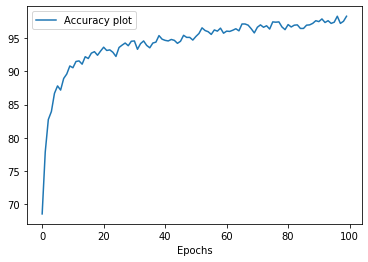

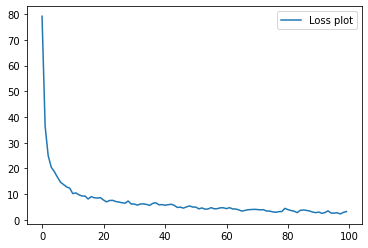

In [ ]:
high_res = Model(epochs=EP_62, fc=FC_62)
epochs_plot, accuracy_plot, loss_plot = high_res.train_validate(cropped_path_62, validation_split=0.1)
plot(epochs_plot, loss_plot, accuracy_plot)

Train with the complete training data since we have now determined our CNN architecure

  0%|          | 0/496000 [00:00<?, ?it/s]


Starting epoch 1


  0%|          | 2368/496000 [00:01<04:25, 1860.11it/s]


loss at epoch 1 : 82.3144713640213
Starting testing on train dataset
-------------------------------


  1%|          | 4928/496000 [00:02<03:00, 2719.23it/s]


Accuracy on train dataset : 1733 / 2480 = 69.87903225806451
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-0.pth

Starting epoch 2


  1%|▏         | 7424/496000 [00:04<04:05, 1994.04it/s]


loss at epoch 2 : 36.721986413002014
Starting testing on train dataset
-------------------------------


  2%|▏         | 9792/496000 [00:05<03:03, 2654.60it/s]


Accuracy on train dataset : 1968 / 2480 = 79.35483870967742
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-1.pth

Starting epoch 3


  2%|▏         | 12224/496000 [00:07<03:53, 2075.04it/s]


loss at epoch 3 : 26.63609018921852
Starting testing on train dataset
-------------------------------


  3%|▎         | 14720/496000 [00:08<03:07, 2561.52it/s]


Accuracy on train dataset : 2071 / 2480 = 83.50806451612904
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-2.pth

Starting epoch 4


  3%|▎         | 17216/496000 [00:10<04:03, 1965.44it/s]


loss at epoch 4 : 21.841944336891174
Starting testing on train dataset
-------------------------------


  4%|▍         | 19968/496000 [00:11<02:46, 2854.02it/s]


Accuracy on train dataset : 2141 / 2480 = 86.33064516129032
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-3.pth

Starting epoch 5


  4%|▍         | 22208/496000 [00:14<04:13, 1869.28it/s]


loss at epoch 5 : 18.288371354341507
Starting testing on train dataset
-------------------------------


  5%|▍         | 24704/496000 [00:15<03:12, 2450.36it/s]


Accuracy on train dataset : 2097 / 2480 = 84.55645161290323
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-4.pth

Starting epoch 6


  5%|▌         | 27264/496000 [00:17<03:47, 2057.44it/s]


loss at epoch 6 : 17.362021505832672
Starting testing on train dataset
-------------------------------


  6%|▌         | 29760/496000 [00:18<03:13, 2414.31it/s]


Accuracy on train dataset : 2156 / 2480 = 86.93548387096774
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-5.pth

Starting epoch 7


  7%|▋         | 32256/496000 [00:21<03:44, 2064.69it/s]


loss at epoch 7 : 16.542582631111145
Starting testing on train dataset
-------------------------------


  7%|▋         | 34880/496000 [00:22<03:00, 2561.30it/s]


Accuracy on train dataset : 2178 / 2480 = 87.8225806451613
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-6.pth

Starting epoch 8


  8%|▊         | 37440/496000 [00:24<03:43, 2047.39it/s]


loss at epoch 8 : 14.728542938828468
Starting testing on train dataset
-------------------------------


  8%|▊         | 39680/496000 [00:25<02:54, 2610.78it/s]


Accuracy on train dataset : 2208 / 2480 = 89.03225806451613
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-7.pth

Starting epoch 9


  8%|▊         | 42112/496000 [00:27<04:00, 1887.40it/s]


loss at epoch 9 : 13.490965738892555
Starting testing on train dataset
-------------------------------


  9%|▉         | 44544/496000 [00:29<03:08, 2394.50it/s]


Accuracy on train dataset : 2216 / 2480 = 89.35483870967742
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-8.pth

Starting epoch 10


 10%|▉         | 47424/496000 [00:31<03:12, 2330.30it/s]


loss at epoch 10 : 13.568788155913353
Starting testing on train dataset
-------------------------------


 10%|█         | 49728/496000 [00:32<02:48, 2641.31it/s]


Accuracy on train dataset : 2234 / 2480 = 90.08064516129032
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-9.pth

Starting epoch 11


 11%|█         | 52160/496000 [00:34<03:50, 1923.42it/s]


loss at epoch 11 : 11.826367750763893
Starting testing on train dataset
-------------------------------


 11%|█         | 54592/496000 [00:35<02:43, 2704.43it/s]


Accuracy on train dataset : 2245 / 2480 = 90.5241935483871
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-10.pth

Starting epoch 12


 12%|█▏        | 57408/496000 [00:37<03:18, 2209.10it/s]


loss at epoch 12 : 11.029691103845835
Starting testing on train dataset
-------------------------------


 12%|█▏        | 59840/496000 [00:39<03:43, 1955.29it/s]


Accuracy on train dataset : 2275 / 2480 = 91.73387096774194
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-11.pth

Starting epoch 13


 13%|█▎        | 62208/496000 [00:41<03:33, 2035.42it/s]


loss at epoch 13 : 10.670338451862335
Starting testing on train dataset
-------------------------------


 13%|█▎        | 64832/496000 [00:42<02:42, 2655.51it/s]


Accuracy on train dataset : 2266 / 2480 = 91.37096774193549
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-12.pth

Starting epoch 14


 14%|█▎        | 67264/496000 [00:44<03:39, 1955.20it/s]


loss at epoch 14 : 9.35412111133337
Starting testing on train dataset
-------------------------------


 14%|█▍        | 69824/496000 [00:45<02:42, 2624.76it/s]


Accuracy on train dataset : 2286 / 2480 = 92.1774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-13.pth

Starting epoch 15


 15%|█▍        | 72128/496000 [00:48<03:47, 1861.22it/s]


loss at epoch 15 : 9.82969406992197
Starting testing on train dataset
-------------------------------


 15%|█▌        | 74560/496000 [00:49<03:00, 2337.28it/s]


Accuracy on train dataset : 2261 / 2480 = 91.16935483870968
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-14.pth

Starting epoch 16


 16%|█▌        | 77056/496000 [00:51<03:29, 2003.14it/s]


loss at epoch 16 : 9.76285369694233
Starting testing on train dataset
-------------------------------


 16%|█▌        | 79744/496000 [00:52<02:39, 2615.50it/s]


Accuracy on train dataset : 2301 / 2480 = 92.78225806451613
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-15.pth

Starting epoch 17


 17%|█▋        | 82304/496000 [00:54<03:24, 2023.44it/s]


loss at epoch 17 : 9.627895206212997
Starting testing on train dataset
-------------------------------


 17%|█▋        | 84672/496000 [00:55<02:30, 2725.16it/s]


Accuracy on train dataset : 2314 / 2480 = 93.30645161290323
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-16.pth

Starting epoch 18


 18%|█▊        | 87360/496000 [00:58<03:08, 2171.26it/s]


loss at epoch 18 : 8.868583209812641
Starting testing on train dataset
-------------------------------


 18%|█▊        | 89664/496000 [00:59<02:45, 2448.47it/s]


Accuracy on train dataset : 2294 / 2480 = 92.5
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-17.pth

Starting epoch 19


 19%|█▊        | 92096/496000 [01:01<03:18, 2039.40it/s]


loss at epoch 19 : 9.059065520763397
Starting testing on train dataset
-------------------------------


 19%|█▉        | 94848/496000 [01:02<02:17, 2907.42it/s]


Accuracy on train dataset : 2325 / 2480 = 93.75
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-18.pth

Starting epoch 20


 20%|█▉        | 97344/496000 [01:04<03:08, 2112.21it/s]


loss at epoch 20 : 8.232850447297096
Starting testing on train dataset
-------------------------------


 20%|██        | 99776/496000 [01:05<02:28, 2674.71it/s]


Accuracy on train dataset : 2314 / 2480 = 93.30645161290323
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-19.pth

Starting epoch 21


 21%|██        | 102272/496000 [01:07<03:03, 2140.14it/s]


loss at epoch 21 : 8.088351845741272
Starting testing on train dataset
-------------------------------


 21%|██        | 104576/496000 [01:09<02:50, 2298.35it/s]


Accuracy on train dataset : 2300 / 2480 = 92.74193548387096
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-20.pth

Starting epoch 22


 22%|██▏       | 107264/496000 [01:11<02:57, 2184.99it/s]


loss at epoch 22 : 8.188023149967194
Starting testing on train dataset
-------------------------------


 22%|██▏       | 109568/496000 [01:12<02:25, 2663.59it/s]


Accuracy on train dataset : 2305 / 2480 = 92.94354838709677
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-21.pth

Starting epoch 23


 23%|██▎       | 112128/496000 [01:14<03:05, 2074.47it/s]


loss at epoch 23 : 7.678563162684441
Starting testing on train dataset
-------------------------------


 23%|██▎       | 114688/496000 [01:15<02:27, 2592.13it/s]


Accuracy on train dataset : 2323 / 2480 = 93.66935483870968
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-22.pth

Starting epoch 24


 24%|██▎       | 117312/496000 [01:17<02:52, 2198.41it/s]


loss at epoch 24 : 7.743211090564728
Starting testing on train dataset
-------------------------------


 24%|██▍       | 119680/496000 [01:18<03:02, 2064.15it/s]


Accuracy on train dataset : 2335 / 2480 = 94.15322580645162
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-23.pth

Starting epoch 25


 25%|██▍       | 122048/496000 [01:20<03:10, 1958.83it/s]


loss at epoch 25 : 7.709649346768856
Starting testing on train dataset
-------------------------------


 25%|██▌       | 124672/496000 [01:21<02:15, 2732.39it/s]


Accuracy on train dataset : 2324 / 2480 = 93.70967741935483
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-24.pth

Starting epoch 26


 26%|██▌       | 127040/496000 [01:24<03:10, 1935.76it/s]


loss at epoch 26 : 6.986563462764025
Starting testing on train dataset
-------------------------------


 26%|██▌       | 129472/496000 [01:25<02:17, 2666.90it/s]


Accuracy on train dataset : 2316 / 2480 = 93.38709677419355
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-25.pth

Starting epoch 27


 27%|██▋       | 132032/496000 [01:27<02:56, 2057.92it/s]


loss at epoch 27 : 6.381637174636126
Starting testing on train dataset
-------------------------------


 27%|██▋       | 134784/496000 [01:28<02:50, 2119.57it/s]


Accuracy on train dataset : 2322 / 2480 = 93.62903225806451
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-26.pth

Starting epoch 28


 28%|██▊       | 137152/496000 [01:30<03:00, 1991.91it/s]


loss at epoch 28 : 7.283355757594109
Starting testing on train dataset
-------------------------------


 28%|██▊       | 139456/496000 [01:31<02:15, 2630.63it/s]


Accuracy on train dataset : 2320 / 2480 = 93.54838709677419
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-27.pth

Starting epoch 29


 29%|██▊       | 141952/496000 [01:34<03:10, 1862.66it/s]


loss at epoch 29 : 6.961182624101639
Starting testing on train dataset
-------------------------------


 29%|██▉       | 144512/496000 [01:35<02:13, 2628.38it/s]


Accuracy on train dataset : 2345 / 2480 = 94.55645161290323
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-28.pth

Starting epoch 30


 30%|██▉       | 146944/496000 [01:37<02:51, 2035.42it/s]


loss at epoch 30 : 6.501002557575703
Starting testing on train dataset
-------------------------------


 30%|███       | 149760/496000 [01:38<02:16, 2529.26it/s]


Accuracy on train dataset : 2370 / 2480 = 95.56451612903226
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-29.pth

Starting epoch 31


 31%|███       | 152064/496000 [01:40<02:46, 2061.43it/s]


loss at epoch 31 : 6.693394098430872
Starting testing on train dataset
-------------------------------


 31%|███       | 154432/496000 [01:41<02:00, 2832.01it/s]


Accuracy on train dataset : 2342 / 2480 = 94.43548387096774
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-30.pth

Starting epoch 32


 32%|███▏      | 157184/496000 [01:43<02:43, 2072.98it/s]


loss at epoch 32 : 7.434205036610365
Starting testing on train dataset
-------------------------------


 32%|███▏      | 159616/496000 [01:44<02:33, 2187.69it/s]


Accuracy on train dataset : 2331 / 2480 = 93.99193548387096
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-31.pth

Starting epoch 33


 33%|███▎      | 161984/496000 [01:47<02:56, 1887.60it/s]


loss at epoch 33 : 6.577657297253609
Starting testing on train dataset
-------------------------------


 33%|███▎      | 164352/496000 [01:48<02:07, 2591.16it/s]


Accuracy on train dataset : 2338 / 2480 = 94.2741935483871
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-32.pth

Starting epoch 34


 34%|███▎      | 166912/496000 [01:50<02:36, 2104.23it/s]


loss at epoch 34 : 5.961115039885044
Starting testing on train dataset
-------------------------------


 34%|███▍      | 169408/496000 [01:51<01:54, 2854.35it/s]


Accuracy on train dataset : 2355 / 2480 = 94.95967741935483
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-33.pth

Starting epoch 35


 35%|███▍      | 172160/496000 [01:53<02:34, 2101.01it/s]


loss at epoch 35 : 6.281913612037897
Starting testing on train dataset
-------------------------------


 35%|███▌      | 174528/496000 [01:54<02:44, 1952.49it/s]


Accuracy on train dataset : 2325 / 2480 = 93.75
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-34.pth

Starting epoch 36


 36%|███▌      | 177024/496000 [01:57<02:36, 2041.53it/s]


loss at epoch 36 : 6.931910000741482
Starting testing on train dataset
-------------------------------


 36%|███▌      | 179456/496000 [01:58<02:00, 2623.73it/s]


Accuracy on train dataset : 2336 / 2480 = 94.19354838709677
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-35.pth

Starting epoch 37


 37%|███▋      | 182016/496000 [02:00<02:35, 2024.11it/s]


loss at epoch 37 : 6.972857221961021
Starting testing on train dataset
-------------------------------


 37%|███▋      | 184640/496000 [02:01<01:53, 2743.25it/s]


Accuracy on train dataset : 2357 / 2480 = 95.04032258064517
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-36.pth

Starting epoch 38


 38%|███▊      | 187072/496000 [02:03<02:24, 2131.48it/s]


loss at epoch 38 : 6.050715200603008
Starting testing on train dataset
-------------------------------


 38%|███▊      | 189376/496000 [02:05<02:31, 2023.20it/s]


Accuracy on train dataset : 2343 / 2480 = 94.4758064516129
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-37.pth

Starting epoch 39


 39%|███▊      | 191936/496000 [02:07<02:34, 1967.82it/s]


loss at epoch 39 : 6.337004479020834
Starting testing on train dataset
-------------------------------


 39%|███▉      | 194496/496000 [02:08<01:52, 2688.76it/s]


Accuracy on train dataset : 2340 / 2480 = 94.35483870967742
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-38.pth

Starting epoch 40


 40%|███▉      | 197120/496000 [02:11<02:20, 2126.90it/s]


loss at epoch 40 : 6.424439065158367
Starting testing on train dataset
-------------------------------


 40%|████      | 199360/496000 [02:12<01:53, 2617.69it/s]


Accuracy on train dataset : 2373 / 2480 = 95.68548387096774
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-39.pth

Starting epoch 41


 41%|████      | 201984/496000 [02:14<02:30, 1947.47it/s]


loss at epoch 41 : 5.892785247415304
Starting testing on train dataset
-------------------------------


 41%|████      | 204544/496000 [02:15<02:04, 2339.05it/s]


Accuracy on train dataset : 2357 / 2480 = 95.04032258064517
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-40.pth

Starting epoch 42


 42%|████▏     | 206912/496000 [02:17<02:32, 1896.00it/s]


loss at epoch 42 : 5.867525886744261
Starting testing on train dataset
-------------------------------


 42%|████▏     | 209600/496000 [02:18<01:46, 2689.81it/s]


Accuracy on train dataset : 2371 / 2480 = 95.60483870967742
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-41.pth

Starting epoch 43


 43%|████▎     | 211968/496000 [02:21<02:30, 1889.47it/s]


loss at epoch 43 : 5.73345797881484
Starting testing on train dataset
-------------------------------


 43%|████▎     | 214336/496000 [02:22<01:51, 2517.74it/s]


Accuracy on train dataset : 2356 / 2480 = 95.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-42.pth

Starting epoch 44


 44%|████▎     | 216896/496000 [02:24<02:09, 2157.08it/s]


loss at epoch 44 : 5.635852266103029
Starting testing on train dataset
-------------------------------


 44%|████▍     | 219520/496000 [02:25<01:53, 2435.04it/s]


Accuracy on train dataset : 2369 / 2480 = 95.5241935483871
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-43.pth

Starting epoch 45


 45%|████▍     | 222144/496000 [02:28<02:04, 2198.85it/s]


loss at epoch 45 : 4.930904449895024
Starting testing on train dataset
-------------------------------


 45%|████▌     | 224576/496000 [02:29<01:36, 2826.77it/s]


Accuracy on train dataset : 2397 / 2480 = 96.65322580645162
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-44.pth

Starting epoch 46


 46%|████▌     | 226944/496000 [02:31<02:27, 1825.37it/s]


loss at epoch 46 : 4.956971354782581
Starting testing on train dataset
-------------------------------


 46%|████▋     | 229568/496000 [02:32<01:35, 2775.99it/s]


Accuracy on train dataset : 2367 / 2480 = 95.44354838709677
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-45.pth

Starting epoch 47


 47%|████▋     | 231936/496000 [02:34<02:13, 1975.44it/s]


loss at epoch 47 : 5.621027138084173
Starting testing on train dataset
-------------------------------


 47%|████▋     | 234432/496000 [02:35<01:46, 2461.17it/s]


Accuracy on train dataset : 2377 / 2480 = 95.84677419354838
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-46.pth

Starting epoch 48


 48%|████▊     | 237056/496000 [02:38<02:11, 1975.16it/s]


loss at epoch 48 : 5.391072101891041
Starting testing on train dataset
-------------------------------


 48%|████▊     | 239424/496000 [02:39<01:34, 2702.88it/s]


Accuracy on train dataset : 2358 / 2480 = 95.08064516129032
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-47.pth

Starting epoch 49


 49%|████▉     | 241920/496000 [02:41<02:09, 1968.48it/s]


loss at epoch 49 : 6.502490159124136
Starting testing on train dataset
-------------------------------


 49%|████▉     | 244544/496000 [02:42<01:35, 2623.38it/s]


Accuracy on train dataset : 2356 / 2480 = 95.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-48.pth

Starting epoch 50


 50%|████▉     | 247104/496000 [02:44<01:55, 2152.66it/s]


loss at epoch 50 : 5.5653787814080715
Starting testing on train dataset
-------------------------------


 50%|█████     | 249280/496000 [02:46<01:46, 2317.16it/s]


Accuracy on train dataset : 2374 / 2480 = 95.7258064516129
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-49.pth

Starting epoch 51


 51%|█████     | 251840/496000 [02:48<01:58, 2059.20it/s]


loss at epoch 51 : 5.605582490563393
Starting testing on train dataset
-------------------------------


 51%|█████▏    | 254400/496000 [02:49<01:34, 2554.62it/s]


Accuracy on train dataset : 2362 / 2480 = 95.24193548387096
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-50.pth

Starting epoch 52


 52%|█████▏    | 257088/496000 [02:51<01:44, 2277.11it/s]


loss at epoch 52 : 4.732150392606854
Starting testing on train dataset
-------------------------------


 52%|█████▏    | 259392/496000 [02:52<01:27, 2697.20it/s]


Accuracy on train dataset : 2375 / 2480 = 95.76612903225806
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-51.pth

Starting epoch 53


 53%|█████▎    | 261888/496000 [02:54<01:57, 1993.42it/s]


loss at epoch 53 : 4.653783520683646
Starting testing on train dataset
-------------------------------


 53%|█████▎    | 264512/496000 [02:55<01:34, 2438.59it/s]


Accuracy on train dataset : 2373 / 2480 = 95.68548387096774
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-52.pth

Starting epoch 54


 54%|█████▍    | 267008/496000 [02:58<01:58, 1933.87it/s]


loss at epoch 54 : 5.457516074180603
Starting testing on train dataset
-------------------------------


 54%|█████▍    | 269376/496000 [02:59<01:22, 2730.52it/s]


Accuracy on train dataset : 2367 / 2480 = 95.44354838709677
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-53.pth

Starting epoch 55


 55%|█████▍    | 271808/496000 [03:01<01:57, 1911.99it/s]


loss at epoch 55 : 5.000931307673454
Starting testing on train dataset
-------------------------------


 55%|█████▌    | 274240/496000 [03:02<01:25, 2605.65it/s]


Accuracy on train dataset : 2387 / 2480 = 96.25
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-54.pth

Starting epoch 56


 56%|█████▌    | 276800/496000 [03:04<01:37, 2250.99it/s]


loss at epoch 56 : 4.57762823626399
Starting testing on train dataset
-------------------------------


 56%|█████▋    | 279360/496000 [03:05<01:53, 1911.47it/s]


Accuracy on train dataset : 2370 / 2480 = 95.56451612903226
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-55.pth

Starting epoch 57


 57%|█████▋    | 281792/496000 [03:08<01:50, 1933.63it/s]


loss at epoch 57 : 4.682609833776951
Starting testing on train dataset
-------------------------------


 57%|█████▋    | 284352/496000 [03:09<01:21, 2602.79it/s]


Accuracy on train dataset : 2366 / 2480 = 95.40322580645162
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-56.pth

Starting epoch 58


 58%|█████▊    | 286784/496000 [03:11<01:49, 1918.22it/s]


loss at epoch 58 : 4.838975239545107
Starting testing on train dataset
-------------------------------


 58%|█████▊    | 289216/496000 [03:12<01:19, 2596.24it/s]


Accuracy on train dataset : 2375 / 2480 = 95.76612903225806
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-57.pth

Starting epoch 59


 59%|█████▉    | 291776/496000 [03:14<01:37, 2092.72it/s]


loss at epoch 59 : 4.74910388328135
Starting testing on train dataset
-------------------------------


 59%|█████▉    | 294400/496000 [03:16<01:37, 2067.47it/s]


Accuracy on train dataset : 2378 / 2480 = 95.88709677419355
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-58.pth

Starting epoch 60


 60%|█████▉    | 296768/496000 [03:18<01:46, 1877.16it/s]


loss at epoch 60 : 4.326884342357516
Starting testing on train dataset
-------------------------------


 60%|██████    | 299520/496000 [03:19<01:20, 2427.19it/s]


Accuracy on train dataset : 2385 / 2480 = 96.16935483870968
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-59.pth

Starting epoch 61


 61%|██████    | 301952/496000 [03:21<01:38, 1965.73it/s]


loss at epoch 61 : 4.054195147007704
Starting testing on train dataset
-------------------------------


 61%|██████▏   | 304512/496000 [03:22<01:13, 2606.26it/s]


Accuracy on train dataset : 2408 / 2480 = 97.09677419354838
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-60.pth

Starting epoch 62


 62%|██████▏   | 306880/496000 [03:25<01:40, 1880.37it/s]


loss at epoch 62 : 4.6768909292295575
Starting testing on train dataset
-------------------------------


 62%|██████▏   | 309248/496000 [03:26<01:11, 2604.97it/s]


Accuracy on train dataset : 2387 / 2480 = 96.25
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-61.pth

Starting epoch 63


 63%|██████▎   | 311744/496000 [03:28<01:37, 1882.32it/s]


loss at epoch 63 : 4.1560563407838345
Starting testing on train dataset
-------------------------------


 63%|██████▎   | 314176/496000 [03:29<01:11, 2549.94it/s]


Accuracy on train dataset : 2390 / 2480 = 96.37096774193549
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-62.pth

Starting epoch 64


 64%|██████▍   | 316864/496000 [03:32<01:33, 1915.60it/s]


loss at epoch 64 : 4.916012639179826
Starting testing on train dataset
-------------------------------


 64%|██████▍   | 319424/496000 [03:33<01:07, 2597.99it/s]


Accuracy on train dataset : 2391 / 2480 = 96.41129032258064
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-63.pth

Starting epoch 65


 65%|██████▍   | 321984/496000 [03:35<01:22, 2101.94it/s]


loss at epoch 65 : 4.54132560454309
Starting testing on train dataset
-------------------------------


 65%|██████▌   | 324352/496000 [03:36<01:06, 2577.45it/s]


Accuracy on train dataset : 2409 / 2480 = 97.13709677419355
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-64.pth

Starting epoch 66


 66%|██████▌   | 326848/496000 [03:38<01:21, 2073.82it/s]


loss at epoch 66 : 3.6678599771112204
Starting testing on train dataset
-------------------------------


 66%|██████▋   | 329280/496000 [03:39<01:03, 2637.57it/s]


Accuracy on train dataset : 2381 / 2480 = 96.00806451612904
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-65.pth

Starting epoch 67


 67%|██████▋   | 331904/496000 [03:41<01:17, 2130.25it/s]


loss at epoch 67 : 4.141570774838328
Starting testing on train dataset
-------------------------------


 67%|██████▋   | 334400/496000 [03:43<01:06, 2422.72it/s]


Accuracy on train dataset : 2393 / 2480 = 96.49193548387096
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-66.pth

Starting epoch 68


 68%|██████▊   | 336832/496000 [03:45<01:25, 1870.97it/s]


loss at epoch 68 : 4.593985186889768
Starting testing on train dataset
-------------------------------


 68%|██████▊   | 339328/496000 [03:46<01:14, 2092.52it/s]


Accuracy on train dataset : 2402 / 2480 = 96.85483870967742
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-67.pth

Starting epoch 69


 69%|██████▉   | 341888/496000 [03:48<01:20, 1917.60it/s]


loss at epoch 69 : 4.187493585050106
Starting testing on train dataset
-------------------------------


 69%|██████▉   | 344384/496000 [03:50<00:57, 2617.57it/s]


Accuracy on train dataset : 2380 / 2480 = 95.96774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-68.pth

Starting epoch 70


 70%|██████▉   | 346944/496000 [03:52<01:06, 2249.06it/s]


loss at epoch 70 : 3.879221038892865
Starting testing on train dataset
-------------------------------


 70%|███████   | 349184/496000 [03:53<01:02, 2349.76it/s]


Accuracy on train dataset : 2391 / 2480 = 96.41129032258064
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-69.pth

Starting epoch 71


 71%|███████   | 351872/496000 [03:55<01:05, 2186.64it/s]


loss at epoch 71 : 3.9350698236376047
Starting testing on train dataset
-------------------------------


 71%|███████▏  | 354368/496000 [03:56<00:56, 2485.72it/s]


Accuracy on train dataset : 2399 / 2480 = 96.73387096774194
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-70.pth

Starting epoch 72


 72%|███████▏  | 356800/496000 [03:58<01:03, 2180.89it/s]


loss at epoch 72 : 4.544191243126988
Starting testing on train dataset
-------------------------------


 72%|███████▏  | 359168/496000 [03:59<00:52, 2592.26it/s]


Accuracy on train dataset : 2379 / 2480 = 95.9274193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-71.pth

Starting epoch 73


 73%|███████▎  | 361920/496000 [04:01<01:01, 2167.93it/s]


loss at epoch 73 : 4.7352279946208
Starting testing on train dataset
-------------------------------


 73%|███████▎  | 364160/496000 [04:02<00:48, 2696.04it/s]


Accuracy on train dataset : 2403 / 2480 = 96.89516129032258
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-72.pth

Starting epoch 74


 74%|███████▍  | 366592/496000 [04:05<01:05, 1982.92it/s]


loss at epoch 74 : 4.992600422352552
Starting testing on train dataset
-------------------------------


 74%|███████▍  | 369088/496000 [04:06<01:02, 2026.55it/s]


Accuracy on train dataset : 2396 / 2480 = 96.61290322580645
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-73.pth

Starting epoch 75


 75%|███████▍  | 371840/496000 [04:08<00:57, 2176.39it/s]


loss at epoch 75 : 4.117664715275168
Starting testing on train dataset
-------------------------------


 75%|███████▌  | 374144/496000 [04:09<00:45, 2656.63it/s]


Accuracy on train dataset : 2404 / 2480 = 96.93548387096774
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-74.pth

Starting epoch 76


 76%|███████▌  | 376896/496000 [04:12<00:53, 2235.66it/s]


loss at epoch 76 : 4.225852804258466
Starting testing on train dataset
-------------------------------


 76%|███████▋  | 379200/496000 [04:13<00:43, 2691.28it/s]


Accuracy on train dataset : 2419 / 2480 = 97.54032258064517
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-75.pth

Starting epoch 77


 77%|███████▋  | 381824/496000 [04:15<00:54, 2114.37it/s]


loss at epoch 77 : 3.539488112553954
Starting testing on train dataset
-------------------------------


 77%|███████▋  | 384192/496000 [04:16<00:49, 2280.30it/s]


Accuracy on train dataset : 2411 / 2480 = 97.21774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-76.pth

Starting epoch 78


 78%|███████▊  | 386816/496000 [04:19<00:55, 1965.11it/s]


loss at epoch 78 : 4.030036156065762
Starting testing on train dataset
-------------------------------


 78%|███████▊  | 389184/496000 [04:20<00:45, 2350.67it/s]


Accuracy on train dataset : 2393 / 2480 = 96.49193548387096
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-77.pth

Starting epoch 79


 79%|███████▉  | 391680/496000 [04:22<00:53, 1947.07it/s]


loss at epoch 79 : 3.471583987120539
Starting testing on train dataset
-------------------------------


 79%|███████▉  | 394112/496000 [04:23<00:40, 2494.45it/s]


Accuracy on train dataset : 2417 / 2480 = 97.45967741935483
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-78.pth

Starting epoch 80


 80%|███████▉  | 396736/496000 [04:25<00:46, 2123.59it/s]


loss at epoch 80 : 3.671654927544296
Starting testing on train dataset
-------------------------------


 80%|████████  | 399168/496000 [04:26<00:37, 2563.07it/s]


Accuracy on train dataset : 2401 / 2480 = 96.81451612903226
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-79.pth

Starting epoch 81


 81%|████████  | 401600/496000 [04:29<00:45, 2061.24it/s]


loss at epoch 81 : 3.7420093547552824
Starting testing on train dataset
-------------------------------


 82%|████████▏ | 404288/496000 [04:30<00:35, 2582.35it/s]


Accuracy on train dataset : 2409 / 2480 = 97.13709677419355
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-80.pth

Starting epoch 82


 82%|████████▏ | 406720/496000 [04:32<00:46, 1904.42it/s]


loss at epoch 82 : 3.4989506788551807
Starting testing on train dataset
-------------------------------


 82%|████████▏ | 409024/496000 [04:33<00:33, 2561.48it/s]


Accuracy on train dataset : 2411 / 2480 = 97.21774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-81.pth

Starting epoch 83


 83%|████████▎ | 411648/496000 [04:36<00:38, 2177.92it/s]


loss at epoch 83 : 3.3823449090123177
Starting testing on train dataset
-------------------------------


 84%|████████▎ | 414336/496000 [04:37<00:31, 2583.16it/s]


Accuracy on train dataset : 2413 / 2480 = 97.29838709677419
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-82.pth

Starting epoch 84


 84%|████████▍ | 416768/496000 [04:39<00:39, 2030.22it/s]


loss at epoch 84 : 2.972177781164646
Starting testing on train dataset
-------------------------------


 85%|████████▍ | 419200/496000 [04:40<00:30, 2544.40it/s]


Accuracy on train dataset : 2414 / 2480 = 97.33870967741936
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-83.pth

Starting epoch 85


 85%|████████▌ | 421696/496000 [04:42<00:35, 2068.83it/s]


loss at epoch 85 : 3.063173088245094
Starting testing on train dataset
-------------------------------


 86%|████████▌ | 424320/496000 [04:43<00:25, 2829.67it/s]


Accuracy on train dataset : 2421 / 2480 = 97.62096774193549
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-84.pth

Starting epoch 86


 86%|████████▌ | 426560/496000 [04:46<00:37, 1844.08it/s]


loss at epoch 86 : 2.963624121621251
Starting testing on train dataset
-------------------------------


 86%|████████▋ | 428992/496000 [04:47<00:27, 2450.13it/s]


Accuracy on train dataset : 2410 / 2480 = 97.1774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-85.pth

Starting epoch 87


 87%|████████▋ | 431808/496000 [04:49<00:28, 2265.68it/s]


loss at epoch 87 : 3.179978823289275
Starting testing on train dataset
-------------------------------


 87%|████████▋ | 433984/496000 [04:50<00:23, 2625.55it/s]


Accuracy on train dataset : 2423 / 2480 = 97.70161290322581
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-86.pth

Starting epoch 88


 88%|████████▊ | 436800/496000 [04:52<00:26, 2212.93it/s]


loss at epoch 88 : 2.9361996818333864
Starting testing on train dataset
-------------------------------


 89%|████████▊ | 439104/496000 [04:53<00:22, 2557.38it/s]


Accuracy on train dataset : 2431 / 2480 = 98.0241935483871
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-87.pth

Starting epoch 89


 89%|████████▉ | 441600/496000 [04:55<00:26, 2046.01it/s]


loss at epoch 89 : 3.3294496331363916
Starting testing on train dataset
-------------------------------


 90%|████████▉ | 444032/496000 [04:57<00:23, 2175.09it/s]


Accuracy on train dataset : 2418 / 2480 = 97.5
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-88.pth

Starting epoch 90


 90%|█████████ | 446784/496000 [04:59<00:22, 2176.84it/s]


loss at epoch 90 : 3.0717919124290347
Starting testing on train dataset
-------------------------------


 91%|█████████ | 449024/496000 [05:00<00:18, 2505.82it/s]


Accuracy on train dataset : 2428 / 2480 = 97.90322580645162
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-89.pth

Starting epoch 91


 91%|█████████ | 451584/496000 [05:02<00:21, 2038.65it/s]


loss at epoch 91 : 3.519652485847473
Starting testing on train dataset
-------------------------------


 92%|█████████▏| 454016/496000 [05:03<00:16, 2560.81it/s]


Accuracy on train dataset : 2404 / 2480 = 96.93548387096774
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-90.pth

Starting epoch 92


 92%|█████████▏| 456640/496000 [05:05<00:19, 2066.12it/s]


loss at epoch 92 : 3.781626253388822
Starting testing on train dataset
-------------------------------


 93%|█████████▎| 458944/496000 [05:07<00:22, 1638.56it/s]


Accuracy on train dataset : 2411 / 2480 = 97.21774193548387
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-91.pth

Starting epoch 93


 93%|█████████▎| 461504/496000 [05:09<00:17, 1983.15it/s]


loss at epoch 93 : 3.662090126425028
Starting testing on train dataset
-------------------------------


 94%|█████████▎| 464256/496000 [05:10<00:11, 2775.37it/s]


Accuracy on train dataset : 2421 / 2480 = 97.62096774193549
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-92.pth

Starting epoch 94


 94%|█████████▍| 466752/496000 [05:12<00:13, 2148.38it/s]


loss at epoch 94 : 3.335341837257147
Starting testing on train dataset
-------------------------------


 95%|█████████▍| 468992/496000 [05:13<00:10, 2654.64it/s]


Accuracy on train dataset : 2402 / 2480 = 96.85483870967742
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-93.pth

Starting epoch 95


 95%|█████████▌| 471424/496000 [05:16<00:12, 1913.77it/s]


loss at epoch 95 : 3.1154696187004447
Starting testing on train dataset
-------------------------------


 96%|█████████▌| 473920/496000 [05:17<00:09, 2423.60it/s]


Accuracy on train dataset : 2415 / 2480 = 97.37903225806451
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-94.pth

Starting epoch 96


 96%|█████████▌| 476672/496000 [05:20<00:09, 2124.15it/s]


loss at epoch 96 : 2.762252619024366
Starting testing on train dataset
-------------------------------


 97%|█████████▋| 478976/496000 [05:21<00:06, 2566.05it/s]


Accuracy on train dataset : 2420 / 2480 = 97.58064516129032
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-95.pth

Starting epoch 97


 97%|█████████▋| 481600/496000 [05:23<00:06, 2091.43it/s]


loss at epoch 97 : 2.920962855219841
Starting testing on train dataset
-------------------------------


 98%|█████████▊| 483904/496000 [05:24<00:04, 2591.73it/s]


Accuracy on train dataset : 2428 / 2480 = 97.90322580645162
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-96.pth

Starting epoch 98


 98%|█████████▊| 486656/496000 [05:26<00:04, 2047.74it/s]


loss at epoch 98 : 3.216715451795608
Starting testing on train dataset
-------------------------------


 99%|█████████▊| 489152/496000 [05:27<00:02, 2559.90it/s]


Accuracy on train dataset : 2414 / 2480 = 97.33870967741936
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-97.pth

Starting epoch 99


 99%|█████████▉| 491584/496000 [05:29<00:02, 1920.23it/s]


loss at epoch 99 : 3.010311528109014
Starting testing on train dataset
-------------------------------


100%|█████████▉| 494016/496000 [05:30<00:00, 2724.64it/s]


Accuracy on train dataset : 2421 / 2480 = 97.62096774193549
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-98.pth

Starting epoch 100


496512it [05:33, 2108.93it/s]


loss at epoch 100 : 2.359751314856112
Starting testing on train dataset
-------------------------------


499072it [05:34, 2583.15it/s]


Accuracy on train dataset : 2425 / 2480 = 97.78225806451613
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_modified-99.pth


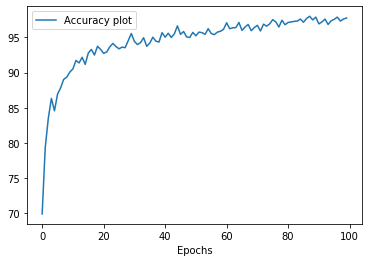

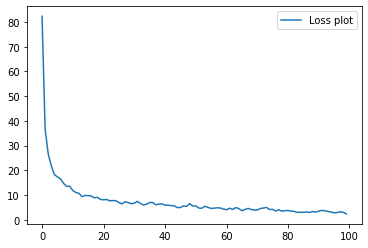

In [ ]:
high_res = Model(epochs=EP_62, fc=FC_62)
epochs_plot, accuracy_plot, loss_plot = high_res.train_validate(cropped_path_62)
plot(epochs_plot, loss_plot, accuracy_plot)

Tweak the final fc layers of the CNN architecture and train on the provided datasets but now with the dataset containing only 0-9 characters

  0%|          | 0/40000 [00:00<?, ?it/s]


Starting epoch 1


  1%|          | 448/40000 [00:00<01:20, 491.21it/s]


loss at epoch 1 : 9.44127881526947
Starting testing on train dataset
-------------------------------


  1%|▏         | 576/40000 [00:00<01:16, 518.39it/s]


Accuracy on train dataset : 342 / 400 = 85.5
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-0.pth

Starting epoch 2


  3%|▎         | 1280/40000 [00:01<01:00, 638.21it/s]


loss at epoch 2 : 4.085685908794403
Starting testing on train dataset
-------------------------------


  4%|▎         | 1472/40000 [00:01<00:56, 681.60it/s]


Accuracy on train dataset : 362 / 400 = 90.5
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-1.pth

Starting epoch 3


  5%|▌         | 2176/40000 [00:02<00:53, 706.57it/s]


loss at epoch 3 : 2.5864521861076355
Starting testing on train dataset
-------------------------------


  6%|▌         | 2368/40000 [00:03<00:50, 746.25it/s]


Accuracy on train dataset : 380 / 400 = 95.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-2.pth

Starting epoch 4


  7%|▋         | 2752/40000 [00:04<00:59, 622.76it/s]


loss at epoch 4 : 1.9986460208892822
Starting testing on train dataset
-------------------------------


  8%|▊         | 3200/40000 [00:04<00:48, 761.71it/s]


Accuracy on train dataset : 385 / 400 = 96.25
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-3.pth

Starting epoch 5


 10%|▉         | 3968/40000 [00:05<00:41, 874.89it/s]


loss at epoch 5 : 1.872654214501381
Starting testing on train dataset
-------------------------------


 10%|█         | 4160/40000 [00:05<00:41, 872.07it/s]


Accuracy on train dataset : 392 / 400 = 98.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-4.pth

Starting epoch 6


 12%|█▏        | 4864/40000 [00:06<00:39, 879.13it/s]


loss at epoch 6 : 1.1432299464941025
Starting testing on train dataset
-------------------------------


 13%|█▎        | 5056/40000 [00:06<00:39, 878.50it/s]


Accuracy on train dataset : 392 / 400 = 98.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-5.pth

Starting epoch 7


 14%|█▍        | 5760/40000 [00:07<00:37, 903.00it/s]


loss at epoch 7 : 1.0130521431565285
Starting testing on train dataset
-------------------------------


 15%|█▍        | 5952/40000 [00:07<00:37, 902.33it/s]


Accuracy on train dataset : 390 / 400 = 97.5
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-6.pth

Starting epoch 8


 17%|█▋        | 6720/40000 [00:09<00:40, 815.94it/s]


loss at epoch 8 : 0.8410047218203545
Starting testing on train dataset
-------------------------------


 17%|█▋        | 6912/40000 [00:09<00:39, 833.22it/s]


Accuracy on train dataset : 396 / 400 = 99.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-7.pth

Starting epoch 9


 19%|█▉        | 7552/40000 [00:10<00:42, 764.50it/s]


loss at epoch 9 : 0.5660070702433586
Starting testing on train dataset
-------------------------------


 19%|█▉        | 7744/40000 [00:10<00:40, 791.46it/s]


Accuracy on train dataset : 397 / 400 = 99.25
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-8.pth

Starting epoch 10


 21%|██        | 8384/40000 [00:11<00:42, 745.10it/s]


loss at epoch 10 : 0.5142954848706722
Starting testing on train dataset
-------------------------------


 21%|██▏       | 8576/40000 [00:11<00:40, 771.03it/s]


Accuracy on train dataset : 398 / 400 = 99.5
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-9.pth

Starting epoch 11


 23%|██▎       | 9344/40000 [00:13<00:36, 843.29it/s]


loss at epoch 11 : 0.4449137821793556
Starting testing on train dataset
-------------------------------


 24%|██▍       | 9536/40000 [00:13<00:36, 831.99it/s]


Accuracy on train dataset : 397 / 400 = 99.25
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-10.pth

Starting epoch 12


 26%|██▌       | 10240/40000 [00:14<00:35, 844.82it/s]


loss at epoch 12 : 0.591561783105135
Starting testing on train dataset
-------------------------------


 26%|██▌       | 10432/40000 [00:14<00:34, 856.79it/s]


Accuracy on train dataset : 395 / 400 = 98.75
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-11.pth

Starting epoch 13


 28%|██▊       | 11072/40000 [00:15<00:34, 834.32it/s]


loss at epoch 13 : 0.556779108941555
Starting testing on train dataset
-------------------------------


 28%|██▊       | 11264/40000 [00:15<00:34, 840.68it/s]


Accuracy on train dataset : 397 / 400 = 99.25
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-12.pth

Starting epoch 14


 30%|███       | 12032/40000 [00:16<00:31, 876.85it/s]


loss at epoch 14 : 0.41726402938365936
Starting testing on train dataset
-------------------------------


 31%|███       | 12224/40000 [00:17<00:32, 862.86it/s]


Accuracy on train dataset : 397 / 400 = 99.25
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-13.pth

Starting epoch 15


 32%|███▏      | 12928/40000 [00:18<00:31, 850.46it/s]


loss at epoch 15 : 0.35186685249209404
Starting testing on train dataset
-------------------------------


 33%|███▎      | 13120/40000 [00:18<00:31, 852.15it/s]


Accuracy on train dataset : 395 / 400 = 98.75
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-14.pth

Starting epoch 16


 35%|███▍      | 13824/40000 [00:19<00:31, 834.02it/s]


loss at epoch 16 : 0.2948419451713562
Starting testing on train dataset
-------------------------------


 35%|███▌      | 14016/40000 [00:19<00:31, 836.76it/s]


Accuracy on train dataset : 398 / 400 = 99.5
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-15.pth

Starting epoch 17


 37%|███▋      | 14656/40000 [00:20<00:31, 803.21it/s]


loss at epoch 17 : 0.2590096779167652
Starting testing on train dataset
-------------------------------


 37%|███▋      | 14848/40000 [00:20<00:30, 815.56it/s]


Accuracy on train dataset : 397 / 400 = 99.25
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-16.pth

Starting epoch 18


 39%|███▉      | 15616/40000 [00:22<00:28, 862.08it/s]


loss at epoch 18 : 0.23346086032688618
Starting testing on train dataset
-------------------------------


 40%|███▉      | 15808/40000 [00:22<00:27, 866.64it/s]


Accuracy on train dataset : 400 / 400 = 100.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-17.pth

Starting epoch 19


 41%|████▏     | 16512/40000 [00:23<00:28, 832.09it/s]


loss at epoch 19 : 0.19654082879424095
Starting testing on train dataset
-------------------------------


 42%|████▏     | 16704/40000 [00:23<00:27, 834.23it/s]


Accuracy on train dataset : 397 / 400 = 99.25
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-18.pth

Starting epoch 20


 44%|████▎     | 17408/40000 [00:24<00:27, 825.37it/s]


loss at epoch 20 : 0.16844453196972609
Starting testing on train dataset
-------------------------------


 44%|████▍     | 17600/40000 [00:24<00:26, 832.91it/s]


Accuracy on train dataset : 400 / 400 = 100.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-19.pth

Starting epoch 21


 46%|████▌     | 18240/40000 [00:25<00:27, 788.72it/s]


loss at epoch 21 : 0.25927747413516045
Starting testing on train dataset
-------------------------------


 46%|████▌     | 18432/40000 [00:26<00:26, 801.79it/s]


Accuracy on train dataset : 399 / 400 = 99.75
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-20.pth

Starting epoch 22


 48%|████▊     | 19200/40000 [00:27<00:23, 874.15it/s]


loss at epoch 22 : 0.24515369441360235
Starting testing on train dataset
-------------------------------


 48%|████▊     | 19392/40000 [00:27<00:23, 867.69it/s]


Accuracy on train dataset : 396 / 400 = 99.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-21.pth

Starting epoch 23


 50%|█████     | 20096/40000 [00:28<00:23, 862.04it/s]


loss at epoch 23 : 0.2435390818864107
Starting testing on train dataset
-------------------------------


 51%|█████     | 20288/40000 [00:28<00:22, 863.82it/s]


Accuracy on train dataset : 396 / 400 = 99.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-22.pth

Starting epoch 24


 52%|█████▏    | 20992/40000 [00:29<00:22, 847.97it/s]


loss at epoch 24 : 0.4016168415546417
Starting testing on train dataset
-------------------------------


 53%|█████▎    | 21184/40000 [00:30<00:24, 774.67it/s]


Accuracy on train dataset : 400 / 400 = 100.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-23.pth

Starting epoch 25


 55%|█████▍    | 21952/40000 [00:31<00:21, 821.08it/s]


loss at epoch 25 : 0.17351491283625364
Starting testing on train dataset
-------------------------------


 55%|█████▌    | 22144/40000 [00:31<00:21, 819.24it/s]


Accuracy on train dataset : 398 / 400 = 99.5
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-24.pth

Starting epoch 26


 57%|█████▋    | 22720/40000 [00:32<00:22, 769.54it/s]


loss at epoch 26 : 0.18503717333078384
Starting testing on train dataset
-------------------------------


 57%|█████▋    | 22912/40000 [00:32<00:21, 800.66it/s]


Accuracy on train dataset : 399 / 400 = 99.75
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-25.pth

Starting epoch 27


 59%|█████▉    | 23680/40000 [00:33<00:19, 830.40it/s]


loss at epoch 27 : 0.2540134312584996
Starting testing on train dataset
-------------------------------


 60%|█████▉    | 23872/40000 [00:33<00:19, 830.63it/s]


Accuracy on train dataset : 397 / 400 = 99.25
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-26.pth

Starting epoch 28


 61%|██████    | 24448/40000 [00:34<00:19, 809.87it/s]


loss at epoch 28 : 0.14689423143863678
Starting testing on train dataset
-------------------------------


 62%|██████▏   | 24704/40000 [00:35<00:17, 854.44it/s]


Accuracy on train dataset : 398 / 400 = 99.5
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-27.pth

Starting epoch 29


 64%|██████▍   | 25536/40000 [00:36<00:15, 919.35it/s]


loss at epoch 29 : 0.229952285066247
Starting testing on train dataset
-------------------------------


 64%|██████▍   | 25728/40000 [00:36<00:15, 893.31it/s]


Accuracy on train dataset : 399 / 400 = 99.75
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-28.pth

Starting epoch 30


 66%|██████▌   | 26368/40000 [00:37<00:17, 781.84it/s]


loss at epoch 30 : 0.26872595213353634
Starting testing on train dataset
-------------------------------


 66%|██████▋   | 26560/40000 [00:37<00:17, 779.62it/s]


Accuracy on train dataset : 399 / 400 = 99.75
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-29.pth

Starting epoch 31


 68%|██████▊   | 27264/40000 [00:38<00:15, 847.37it/s]


loss at epoch 31 : 0.2911875108256936
Starting testing on train dataset
-------------------------------


 69%|██████▊   | 27456/40000 [00:38<00:14, 847.62it/s]


Accuracy on train dataset : 400 / 400 = 100.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-30.pth

Starting epoch 32


 70%|███████   | 28096/40000 [00:39<00:14, 812.95it/s]


loss at epoch 32 : 0.32079024240374565
Starting testing on train dataset
-------------------------------


 71%|███████   | 28288/40000 [00:40<00:14, 811.29it/s]


Accuracy on train dataset : 400 / 400 = 100.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-31.pth

Starting epoch 33


 72%|███████▏  | 28992/40000 [00:41<00:13, 820.33it/s]


loss at epoch 33 : 0.2018582159653306
Starting testing on train dataset
-------------------------------


 73%|███████▎  | 29184/40000 [00:41<00:12, 832.81it/s]


Accuracy on train dataset : 398 / 400 = 99.5
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-32.pth

Starting epoch 34


 75%|███████▍  | 29888/40000 [00:43<00:13, 729.85it/s]


loss at epoch 34 : 0.29177398793399334
Starting testing on train dataset
-------------------------------


 76%|███████▌  | 30272/40000 [00:43<00:10, 919.53it/s]


Accuracy on train dataset : 399 / 400 = 99.75
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-33.pth

Starting epoch 35


 77%|███████▋  | 30784/40000 [00:44<00:12, 718.46it/s]


loss at epoch 35 : 0.10978291882202029
Starting testing on train dataset
-------------------------------


 77%|███████▋  | 30976/40000 [00:44<00:12, 750.26it/s]


Accuracy on train dataset : 400 / 400 = 100.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-34.pth

Starting epoch 36


 79%|███████▉  | 31744/40000 [00:45<00:09, 834.92it/s]


loss at epoch 36 : 0.2141279149800539
Starting testing on train dataset
-------------------------------


 80%|███████▉  | 31936/40000 [00:45<00:09, 821.21it/s]


Accuracy on train dataset : 399 / 400 = 99.75
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-35.pth

Starting epoch 37


 82%|████████▏ | 32640/40000 [00:46<00:08, 818.88it/s]


loss at epoch 37 : 0.20205834042280912
Starting testing on train dataset
-------------------------------


 82%|████████▏ | 32832/40000 [00:47<00:08, 817.71it/s]


Accuracy on train dataset : 398 / 400 = 99.5
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-36.pth

Starting epoch 38


 84%|████████▍ | 33600/40000 [00:48<00:08, 761.88it/s]


loss at epoch 38 : 0.10062524396926165
Starting testing on train dataset
-------------------------------


 84%|████████▍ | 33792/40000 [00:48<00:07, 778.20it/s]


Accuracy on train dataset : 399 / 400 = 99.75
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-37.pth

Starting epoch 39


 86%|████████▌ | 34368/40000 [00:49<00:08, 699.34it/s]


loss at epoch 39 : 0.16045739548280835
Starting testing on train dataset
-------------------------------


 86%|████████▋ | 34560/40000 [00:50<00:07, 731.01it/s]


Accuracy on train dataset : 398 / 400 = 99.5
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-38.pth

Starting epoch 40


 88%|████████▊ | 35264/40000 [00:51<00:05, 808.99it/s]


loss at epoch 40 : 0.2010953100398183
Starting testing on train dataset
-------------------------------


 89%|████████▊ | 35456/40000 [00:51<00:05, 810.12it/s]


Accuracy on train dataset : 399 / 400 = 99.75
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-39.pth

Starting epoch 41


 90%|█████████ | 36096/40000 [00:52<00:04, 839.91it/s]


loss at epoch 41 : 0.07150539848953485
Starting testing on train dataset
-------------------------------


 91%|█████████ | 36352/40000 [00:52<00:04, 879.42it/s]


Accuracy on train dataset : 399 / 400 = 99.75
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-40.pth

Starting epoch 42


 93%|█████████▎| 37056/40000 [00:53<00:03, 884.85it/s]


loss at epoch 42 : 0.1668000901117921
Starting testing on train dataset
-------------------------------


 93%|█████████▎| 37248/40000 [00:53<00:03, 850.33it/s]


Accuracy on train dataset : 400 / 400 = 100.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-41.pth

Starting epoch 43


 95%|█████████▌| 38016/40000 [00:55<00:02, 882.10it/s]


loss at epoch 43 : 0.11596883134916425
Starting testing on train dataset
-------------------------------


 96%|█████████▌| 38208/40000 [00:55<00:02, 878.52it/s]


Accuracy on train dataset : 396 / 400 = 99.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-42.pth

Starting epoch 44


 97%|█████████▋| 38912/40000 [00:56<00:01, 819.54it/s]


loss at epoch 44 : 0.1922433883883059
Starting testing on train dataset
-------------------------------


 98%|█████████▊| 39104/40000 [00:56<00:01, 814.34it/s]


Accuracy on train dataset : 400 / 400 = 100.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-43.pth

Starting epoch 45


 99%|█████████▉| 39744/40000 [00:57<00:00, 817.06it/s]


loss at epoch 45 : 0.09051067335531116
Starting testing on train dataset
-------------------------------


40320it [00:57, 1099.98it/s]                          


Accuracy on train dataset : 399 / 400 = 99.75
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-44.pth

Starting epoch 46


40576it [00:58, 544.73it/s] 


loss at epoch 46 : 0.0933508644811809
Starting testing on train dataset
-------------------------------


40832it [00:59, 630.34it/s]


Accuracy on train dataset : 399 / 400 = 99.75
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-45.pth

Starting epoch 47


41600it [01:00, 718.77it/s]


loss at epoch 47 : 0.10887752380222082
Starting testing on train dataset
-------------------------------


41792it [01:00, 745.58it/s]


Accuracy on train dataset : 400 / 400 = 100.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-46.pth

Starting epoch 48


42496it [01:01, 769.27it/s]


loss at epoch 48 : 0.07945066154934466
Starting testing on train dataset
-------------------------------


42688it [01:01, 792.53it/s]


Accuracy on train dataset : 399 / 400 = 99.75
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-47.pth

Starting epoch 49


43328it [01:03, 808.74it/s]


loss at epoch 49 : 0.06498666619881988
Starting testing on train dataset
-------------------------------


43520it [01:03, 789.98it/s]


Accuracy on train dataset : 400 / 400 = 100.0
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-48.pth

Starting epoch 50


44224it [01:04, 843.00it/s]


loss at epoch 50 : 0.09327491465955973
Starting testing on train dataset
-------------------------------


44416it [01:04, 853.24it/s]


Accuracy on train dataset : 399 / 400 = 99.75
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-49.pth


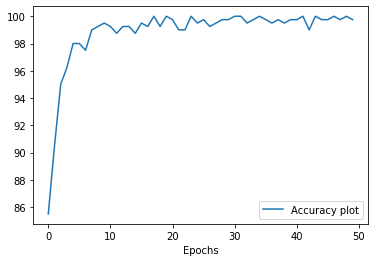

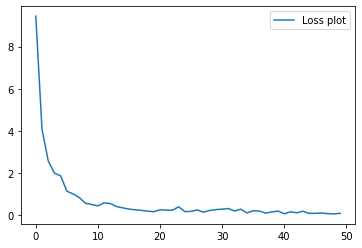

In [ ]:
mnist_pre_trained = Model(epochs=EP_10, fc=FC_10)
epochs_plot, accuracy_plot, loss_plot = mnist_pre_trained.train_validate(cropped_path_10, validation_split=0)
plot(epochs_plot, loss_plot, accuracy_plot)

Retrain this pre trained model with the mnist data set

  0%|          | 0/6000000 [00:00<?, ?it/s]


Starting epoch 1


  1%|          | 59904/6000000 [00:13<20:52, 4740.75it/s]


loss at epoch 1 : 20.71352262562141
Starting testing on train dataset
-------------------------------


  2%|▏         | 119296/6000000 [00:26<21:09, 4631.52it/s]


Accuracy on train dataset : 59229 / 60000 = 98.715
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-0.pth

Starting epoch 2


  3%|▎         | 179968/6000000 [00:40<20:06, 4824.79it/s]


loss at epoch 2 : 9.393543172627687
Starting testing on train dataset
-------------------------------


  4%|▍         | 239616/6000000 [00:53<21:17, 4507.71it/s]


Accuracy on train dataset : 59432 / 60000 = 99.05333333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-1.pth

Starting epoch 3


  5%|▌         | 300800/6000000 [01:08<19:29, 4871.46it/s]


loss at epoch 3 : 7.4453151694033295
Starting testing on train dataset
-------------------------------


  6%|▌         | 360960/6000000 [01:21<16:18, 5763.89it/s]


Accuracy on train dataset : 59523 / 60000 = 99.205
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-2.pth

Starting epoch 4


  7%|▋         | 420608/6000000 [01:37<23:07, 4021.30it/s]


loss at epoch 4 : 6.3176783750532195
Starting testing on train dataset
-------------------------------


  8%|▊         | 481280/6000000 [01:50<17:06, 5378.75it/s]


Accuracy on train dataset : 59401 / 60000 = 99.00166666666667
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-3.pth

Starting epoch 5


  9%|▉         | 541184/6000000 [02:05<22:40, 4011.63it/s]


loss at epoch 5 : 5.780471798963845
Starting testing on train dataset
-------------------------------


 10%|█         | 601344/6000000 [02:18<17:04, 5270.62it/s]


Accuracy on train dataset : 59621 / 60000 = 99.36833333333334
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-4.pth

Starting epoch 6


 11%|█         | 660992/6000000 [02:32<20:23, 4364.46it/s]


loss at epoch 6 : 5.057457588496618
Starting testing on train dataset
-------------------------------


 12%|█▏        | 721920/6000000 [02:45<16:09, 5443.95it/s]


Accuracy on train dataset : 59572 / 60000 = 99.28666666666666
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-5.pth

Starting epoch 7


 13%|█▎        | 781312/6000000 [03:00<20:57, 4151.23it/s]


loss at epoch 7 : 4.888541590771638
Starting testing on train dataset
-------------------------------


 14%|█▍        | 841984/6000000 [03:13<18:05, 4753.16it/s]


Accuracy on train dataset : 59620 / 60000 = 99.36666666666666
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-6.pth

Starting epoch 8


 15%|█▌        | 902400/6000000 [03:27<17:31, 4846.90it/s]


loss at epoch 8 : 4.420825939101633
Starting testing on train dataset
-------------------------------


 16%|█▌        | 962048/6000000 [03:40<15:42, 5346.12it/s]


Accuracy on train dataset : 59644 / 60000 = 99.40666666666667
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-7.pth

Starting epoch 9


 17%|█▋        | 1022720/6000000 [03:54<16:45, 4949.19it/s]


loss at epoch 9 : 4.197055115015246
Starting testing on train dataset
-------------------------------


 18%|█▊        | 1081856/6000000 [04:07<17:43, 4622.85it/s]


Accuracy on train dataset : 59616 / 60000 = 99.36
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-8.pth

Starting epoch 10


 19%|█▉        | 1142272/6000000 [04:22<18:26, 4388.76it/s]


loss at epoch 10 : 3.8306842730380595
Starting testing on train dataset
-------------------------------


 20%|██        | 1202432/6000000 [04:34<15:17, 5227.72it/s]


Accuracy on train dataset : 59591 / 60000 = 99.31833333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-9.pth

Starting epoch 11


 21%|██        | 1263104/6000000 [04:49<18:46, 4203.86it/s]


loss at epoch 11 : 3.599607655138243
Starting testing on train dataset
-------------------------------


 22%|██▏       | 1323264/6000000 [05:02<14:26, 5399.27it/s]


Accuracy on train dataset : 59751 / 60000 = 99.585
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-10.pth

Starting epoch 12


 23%|██▎       | 1383424/6000000 [05:17<16:27, 4676.13it/s]


loss at epoch 12 : 3.81728752287745
Starting testing on train dataset
-------------------------------


 24%|██▍       | 1443584/6000000 [05:30<16:22, 4638.43it/s]


Accuracy on train dataset : 59721 / 60000 = 99.535
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-11.pth

Starting epoch 13


 25%|██▌       | 1503744/6000000 [05:45<16:21, 4581.06it/s]


loss at epoch 13 : 2.8114387854293454
Starting testing on train dataset
-------------------------------


 26%|██▌       | 1563904/6000000 [05:57<14:39, 5041.26it/s]


Accuracy on train dataset : 59749 / 60000 = 99.58166666666666
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-12.pth

Starting epoch 14


 27%|██▋       | 1624064/6000000 [06:12<15:21, 4746.35it/s]


loss at epoch 14 : 3.2347249373124214
Starting testing on train dataset
-------------------------------


 28%|██▊       | 1684224/6000000 [06:25<15:03, 4777.03it/s]


Accuracy on train dataset : 59718 / 60000 = 99.53
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-13.pth

Starting epoch 15


 29%|██▉       | 1744384/6000000 [06:39<15:57, 4445.54it/s]


loss at epoch 15 : 2.9847275233332766
Starting testing on train dataset
-------------------------------


 30%|███       | 1804544/6000000 [06:52<15:47, 4429.46it/s]


Accuracy on train dataset : 59771 / 60000 = 99.61833333333334
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-14.pth

Starting epoch 16


 31%|███       | 1864704/6000000 [07:07<16:53, 4079.67it/s]


loss at epoch 16 : 2.8008682745858096
Starting testing on train dataset
-------------------------------


 32%|███▏      | 1924608/6000000 [07:20<15:40, 4333.79it/s]


Accuracy on train dataset : 59775 / 60000 = 99.625
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-15.pth

Starting epoch 17


 33%|███▎      | 1985024/6000000 [07:34<14:54, 4486.13it/s]


loss at epoch 17 : 2.7847879375476623
Starting testing on train dataset
-------------------------------


 34%|███▍      | 2044672/6000000 [07:47<14:01, 4702.75it/s]


Accuracy on train dataset : 59768 / 60000 = 99.61333333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-16.pth

Starting epoch 18


 35%|███▌      | 2105088/6000000 [08:02<14:31, 4468.65it/s]


loss at epoch 18 : 3.096258624078473
Starting testing on train dataset
-------------------------------


 36%|███▌      | 2165504/6000000 [08:15<13:38, 4683.45it/s]


Accuracy on train dataset : 59788 / 60000 = 99.64666666666666
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-17.pth

Starting epoch 19


 37%|███▋      | 2225408/6000000 [08:30<15:19, 4103.77it/s]


loss at epoch 19 : 2.558269811765058
Starting testing on train dataset
-------------------------------


 38%|███▊      | 2286080/6000000 [08:42<10:49, 5720.29it/s]


Accuracy on train dataset : 59843 / 60000 = 99.73833333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-18.pth

Starting epoch 20


 39%|███▉      | 2345472/6000000 [08:57<14:49, 4107.96it/s]


loss at epoch 20 : 2.3208514640064095
Starting testing on train dataset
-------------------------------


 40%|████      | 2405888/6000000 [09:09<10:50, 5526.03it/s]


Accuracy on train dataset : 59792 / 60000 = 99.65333333333334
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-19.pth

Starting epoch 21


 41%|████      | 2466304/6000000 [09:24<12:28, 4718.71it/s]


loss at epoch 21 : 2.450534143616096
Starting testing on train dataset
-------------------------------


 42%|████▏     | 2526208/6000000 [09:37<10:48, 5354.12it/s]


Accuracy on train dataset : 59766 / 60000 = 99.61
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-20.pth

Starting epoch 22


 43%|████▎     | 2586880/6000000 [09:52<11:57, 4757.47it/s]


loss at epoch 22 : 2.072169018276327
Starting testing on train dataset
-------------------------------


 44%|████▍     | 2647040/6000000 [10:05<10:36, 5269.58it/s]


Accuracy on train dataset : 59714 / 60000 = 99.52333333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-21.pth

Starting epoch 23


 45%|████▌     | 2707200/6000000 [10:20<11:33, 4749.19it/s]


loss at epoch 23 : 2.6076960002756095
Starting testing on train dataset
-------------------------------


 46%|████▌     | 2766592/6000000 [10:32<10:04, 5349.06it/s]


Accuracy on train dataset : 59821 / 60000 = 99.70166666666667
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-22.pth

Starting epoch 24


 47%|████▋     | 2826752/6000000 [10:47<13:10, 4015.11it/s]


loss at epoch 24 : 2.2205971908697393
Starting testing on train dataset
-------------------------------


 48%|████▊     | 2887168/6000000 [11:00<10:47, 4808.88it/s]


Accuracy on train dataset : 59841 / 60000 = 99.735
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-23.pth

Starting epoch 25


 49%|████▉     | 2947328/6000000 [11:15<12:28, 4076.83it/s]


loss at epoch 25 : 1.9251615468383534
Starting testing on train dataset
-------------------------------


 50%|█████     | 3008000/6000000 [11:28<10:19, 4833.45it/s]


Accuracy on train dataset : 59835 / 60000 = 99.725
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-24.pth

Starting epoch 26


 51%|█████     | 3067648/6000000 [11:43<13:01, 3751.83it/s]


loss at epoch 26 : 2.1976272775827965
Starting testing on train dataset
-------------------------------


 52%|█████▏    | 3128064/6000000 [11:56<10:23, 4607.81it/s]


Accuracy on train dataset : 59854 / 60000 = 99.75666666666666
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-25.pth

Starting epoch 27


 53%|█████▎    | 3188224/6000000 [12:11<10:38, 4401.10it/s]


loss at epoch 27 : 1.702887720108265
Starting testing on train dataset
-------------------------------


 54%|█████▍    | 3247872/6000000 [12:24<09:14, 4960.63it/s]


Accuracy on train dataset : 59840 / 60000 = 99.73333333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-26.pth

Starting epoch 28


 55%|█████▌    | 3308544/6000000 [12:40<10:16, 4364.11it/s]


loss at epoch 28 : 2.070476513108588
Starting testing on train dataset
-------------------------------


 56%|█████▌    | 3368448/6000000 [12:53<09:09, 4784.96it/s]


Accuracy on train dataset : 59807 / 60000 = 99.67833333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-27.pth

Starting epoch 29


 57%|█████▋    | 3428608/6000000 [13:08<10:04, 4257.12it/s]


loss at epoch 29 : 1.8696026451871148
Starting testing on train dataset
-------------------------------


 58%|█████▊    | 3489024/6000000 [13:21<08:44, 4787.50it/s]


Accuracy on train dataset : 59862 / 60000 = 99.77
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-28.pth

Starting epoch 30


 59%|█████▉    | 3548928/6000000 [13:36<09:29, 4303.82it/s]


loss at epoch 30 : 1.41831285180524
Starting testing on train dataset
-------------------------------


 60%|██████    | 3608832/6000000 [13:49<08:20, 4777.19it/s]


Accuracy on train dataset : 59841 / 60000 = 99.735
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-29.pth

Starting epoch 31


 61%|██████    | 3669248/6000000 [14:04<09:18, 4175.65it/s]


loss at epoch 31 : 1.9554676184052369
Starting testing on train dataset
-------------------------------


 62%|██████▏   | 3729920/6000000 [14:16<06:36, 5719.90it/s]


Accuracy on train dataset : 59811 / 60000 = 99.685
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-30.pth

Starting epoch 32


 63%|██████▎   | 3789312/6000000 [14:31<08:38, 4267.06it/s]


loss at epoch 32 : 1.5891792374968645
Starting testing on train dataset
-------------------------------


 64%|██████▍   | 3849728/6000000 [14:44<07:44, 4633.81it/s]


Accuracy on train dataset : 59890 / 60000 = 99.81666666666666
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-31.pth

Starting epoch 33


 65%|██████▌   | 3909632/6000000 [14:59<08:40, 4016.06it/s]


loss at epoch 33 : 1.2917515057997662
Starting testing on train dataset
-------------------------------


 66%|██████▌   | 3969792/6000000 [15:12<07:11, 4700.72it/s]


Accuracy on train dataset : 59913 / 60000 = 99.855
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-32.pth

Starting epoch 34


 67%|██████▋   | 4029952/6000000 [15:26<07:57, 4126.60it/s]


loss at epoch 34 : 1.3855547779312474
Starting testing on train dataset
-------------------------------


 68%|██████▊   | 4090112/6000000 [15:39<06:39, 4775.28it/s]


Accuracy on train dataset : 59905 / 60000 = 99.84166666666667
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-33.pth

Starting epoch 35


 69%|██████▉   | 4151040/6000000 [15:54<06:27, 4771.85it/s]


loss at epoch 35 : 1.381744187372533
Starting testing on train dataset
-------------------------------


 70%|███████   | 4210688/6000000 [16:07<05:49, 5120.02it/s]


Accuracy on train dataset : 59863 / 60000 = 99.77166666666666
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-34.pth

Starting epoch 36


 71%|███████   | 4271360/6000000 [16:22<05:42, 5042.97it/s]


loss at epoch 36 : 1.5269884889567038
Starting testing on train dataset
-------------------------------


 72%|███████▏  | 4330752/6000000 [16:34<06:02, 4609.29it/s]


Accuracy on train dataset : 59872 / 60000 = 99.78666666666666
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-35.pth

Starting epoch 37


 73%|███████▎  | 4390912/6000000 [16:49<06:15, 4287.61it/s]


loss at epoch 37 : 1.6844637764661456
Starting testing on train dataset
-------------------------------


 74%|███████▍  | 4451584/6000000 [17:02<04:58, 5185.19it/s]


Accuracy on train dataset : 59844 / 60000 = 99.74
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-36.pth

Starting epoch 38


 75%|███████▌  | 4512000/6000000 [17:18<05:22, 4615.17it/s]


loss at epoch 38 : 1.29617525228241
Starting testing on train dataset
-------------------------------


 76%|███████▌  | 4571392/6000000 [17:30<05:18, 4487.65it/s]


Accuracy on train dataset : 59895 / 60000 = 99.825
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-37.pth

Starting epoch 39


 77%|███████▋  | 4631552/6000000 [17:45<05:25, 4200.52it/s]


loss at epoch 39 : 1.3033567253660294
Starting testing on train dataset
-------------------------------


 78%|███████▊  | 4691968/6000000 [17:58<04:03, 5368.10it/s]


Accuracy on train dataset : 59880 / 60000 = 99.8
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-38.pth

Starting epoch 40


 79%|███████▉  | 4752128/6000000 [18:13<05:00, 4149.39it/s]


loss at epoch 40 : 1.2817863691452658
Starting testing on train dataset
-------------------------------


 80%|████████  | 4812544/6000000 [18:27<03:54, 5057.72it/s]


Accuracy on train dataset : 59925 / 60000 = 99.875
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-39.pth

Starting epoch 41


 81%|████████  | 4872704/6000000 [18:42<04:25, 4238.28it/s]


loss at epoch 41 : 1.4881459565040132
Starting testing on train dataset
-------------------------------


 82%|████████▏ | 4932608/6000000 [18:55<03:28, 5121.10it/s]


Accuracy on train dataset : 59883 / 60000 = 99.805
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-40.pth

Starting epoch 42


 83%|████████▎ | 4993024/6000000 [19:10<04:06, 4077.69it/s]


loss at epoch 42 : 1.164289014894166
Starting testing on train dataset
-------------------------------


 84%|████████▍ | 5052672/6000000 [19:23<03:15, 4833.47it/s]


Accuracy on train dataset : 59927 / 60000 = 99.87833333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-41.pth

Starting epoch 43


 85%|████████▌ | 5113088/6000000 [19:38<03:21, 4403.61it/s]


loss at epoch 43 : 1.1140445265409653
Starting testing on train dataset
-------------------------------


 86%|████████▌ | 5173248/6000000 [19:50<02:42, 5097.20it/s]


Accuracy on train dataset : 59919 / 60000 = 99.865
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-42.pth

Starting epoch 44


 87%|████████▋ | 5233152/6000000 [20:05<03:01, 4226.30it/s]


loss at epoch 44 : 0.995787826115702
Starting testing on train dataset
-------------------------------


 88%|████████▊ | 5293824/6000000 [20:18<02:16, 5162.52it/s]


Accuracy on train dataset : 59916 / 60000 = 99.86
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-43.pth

Starting epoch 45


 89%|████████▉ | 5353728/6000000 [20:33<02:15, 4774.66it/s]


loss at epoch 45 : 1.0681545159750385
Starting testing on train dataset
-------------------------------


 90%|█████████ | 5413632/6000000 [20:47<02:16, 4282.58it/s]


Accuracy on train dataset : 59928 / 60000 = 99.88
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-44.pth

Starting epoch 46


 91%|█████████ | 5473792/6000000 [21:02<02:14, 3908.49it/s]


loss at epoch 46 : 0.9257357179030805
Starting testing on train dataset
-------------------------------


 92%|█████████▏| 5534208/6000000 [21:15<01:38, 4716.64it/s]


Accuracy on train dataset : 59912 / 60000 = 99.85333333333334
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-45.pth

Starting epoch 47


 93%|█████████▎| 5594368/6000000 [21:30<01:37, 4174.15it/s]


loss at epoch 47 : 0.9645117200961977
Starting testing on train dataset
-------------------------------


 94%|█████████▍| 5654784/6000000 [21:42<01:07, 5104.67it/s]


Accuracy on train dataset : 59910 / 60000 = 99.85
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-46.pth

Starting epoch 48


 95%|█████████▌| 5714432/6000000 [21:58<01:07, 4249.12it/s]


loss at epoch 48 : 1.3027823695811094
Starting testing on train dataset
-------------------------------


 96%|█████████▋| 5775104/6000000 [22:11<00:45, 4949.79it/s]


Accuracy on train dataset : 59891 / 60000 = 99.81833333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-47.pth

Starting epoch 49


 97%|█████████▋| 5835264/6000000 [22:26<00:36, 4495.17it/s]


loss at epoch 49 : 1.129318495744883
Starting testing on train dataset
-------------------------------


 98%|█████████▊| 5894912/6000000 [22:38<00:21, 4796.48it/s]


Accuracy on train dataset : 59924 / 60000 = 99.87333333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-48.pth

Starting epoch 50


 99%|█████████▉| 5955072/6000000 [22:54<00:10, 4441.99it/s]


loss at epoch 50 : 0.8641389686035836
Starting testing on train dataset
-------------------------------


6014976it [23:07, 4568.49it/s]


Accuracy on train dataset : 59919 / 60000 = 99.865
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/train_digits_retrain-49.pth


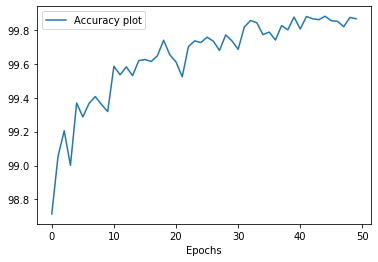

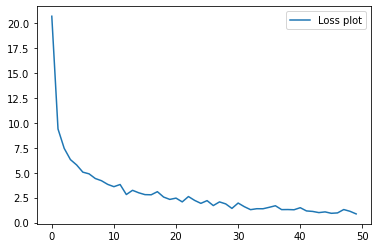

In [ ]:
epochs_plot, accuracy_plot, loss_plot = mnist_pre_trained.train_validate(name='train_digits_retrain', mnist=True, batch_size=256, validation_split=0, save_name='train_digits_retrain')
plot(epochs_plot, loss_plot, accuracy_plot)

Test the accuracy of the  retrained network on the MNIST test dataset

In [ ]:
mnist_pre_trained.test_mnist()

  0%|          | 0/10000 [00:00<?, ?it/s]

Starting testing on test dataset
-------------------------------


10240it [00:01, 5626.28it/s]                          


Accuracy on test dataset : 9925 / 10000 = 99.25
--------------------------------


Train the same CNN architecture but this time with random initialization on the MNIST dataset

  0%|          | 0/6000000 [00:00<?, ?it/s]


Starting epoch 1


  1%|          | 59904/6000000 [00:13<21:01, 4709.47it/s]


loss at epoch 1 : 29.01791421789676
Starting testing on train dataset
-------------------------------


  2%|▏         | 119808/6000000 [00:25<19:59, 4902.88it/s]


Accuracy on train dataset : 58911 / 60000 = 98.185
--------------------------------

saved dataset to path : ./models/mnist_vanilla-0.pth

Starting epoch 2


  3%|▎         | 179712/6000000 [00:39<22:41, 4275.42it/s]


loss at epoch 2 : 10.87014051573351
Starting testing on train dataset
-------------------------------


  4%|▍         | 240128/6000000 [00:52<19:15, 4985.30it/s]


Accuracy on train dataset : 59360 / 60000 = 98.93333333333334
--------------------------------

saved dataset to path : ./models/mnist_vanilla-1.pth

Starting epoch 3


  5%|▌         | 300288/6000000 [01:06<22:23, 4243.13it/s]


loss at epoch 3 : 8.456157993059605
Starting testing on train dataset
-------------------------------


  6%|▌         | 360448/6000000 [01:18<19:01, 4942.37it/s]


Accuracy on train dataset : 59383 / 60000 = 98.97166666666666
--------------------------------

saved dataset to path : ./models/mnist_vanilla-2.pth

Starting epoch 4


  7%|▋         | 420864/6000000 [01:32<18:43, 4965.98it/s]


loss at epoch 4 : 6.898694366333075
Starting testing on train dataset
-------------------------------


  8%|▊         | 480768/6000000 [01:44<17:50, 5157.09it/s]


Accuracy on train dataset : 59511 / 60000 = 99.185
--------------------------------

saved dataset to path : ./models/mnist_vanilla-3.pth

Starting epoch 5


  9%|▉         | 540672/6000000 [01:58<20:36, 4414.34it/s]


loss at epoch 5 : 5.787366448726971
Starting testing on train dataset
-------------------------------


 10%|█         | 600576/6000000 [02:10<19:54, 4520.75it/s]


Accuracy on train dataset : 59581 / 60000 = 99.30166666666666
--------------------------------

saved dataset to path : ./models/mnist_vanilla-4.pth

Starting epoch 6


 11%|█         | 661248/6000000 [02:24<18:27, 4822.21it/s]


loss at epoch 6 : 5.270355331420433
Starting testing on train dataset
-------------------------------


 12%|█▏        | 721408/6000000 [02:36<16:23, 5365.20it/s]


Accuracy on train dataset : 59539 / 60000 = 99.23166666666667
--------------------------------

saved dataset to path : ./models/mnist_vanilla-5.pth

Starting epoch 7


 13%|█▎        | 781568/6000000 [02:49<19:13, 4524.83it/s]


loss at epoch 7 : 4.7282472209772095
Starting testing on train dataset
-------------------------------


 14%|█▍        | 841984/6000000 [03:01<15:47, 5443.79it/s]


Accuracy on train dataset : 59559 / 60000 = 99.265
--------------------------------

saved dataset to path : ./models/mnist_vanilla-6.pth

Starting epoch 8


 15%|█▌        | 902400/6000000 [03:15<17:07, 4961.96it/s]


loss at epoch 8 : 4.361981699708849
Starting testing on train dataset
-------------------------------


 16%|█▌        | 962048/6000000 [03:27<15:33, 5399.43it/s]


Accuracy on train dataset : 59740 / 60000 = 99.56666666666666
--------------------------------

saved dataset to path : ./models/mnist_vanilla-7.pth

Starting epoch 9


 17%|█▋        | 1021952/6000000 [03:41<19:02, 4356.79it/s]


loss at epoch 9 : 3.8058489026734605
Starting testing on train dataset
-------------------------------


 18%|█▊        | 1082624/6000000 [03:53<16:16, 5035.01it/s]


Accuracy on train dataset : 59688 / 60000 = 99.48
--------------------------------

saved dataset to path : ./models/mnist_vanilla-8.pth

Starting epoch 10


 19%|█▉        | 1143040/6000000 [04:07<17:08, 4722.04it/s]


loss at epoch 10 : 3.5572498809779063
Starting testing on train dataset
-------------------------------


 20%|██        | 1202944/6000000 [04:19<15:31, 5147.47it/s]


Accuracy on train dataset : 59720 / 60000 = 99.53333333333333
--------------------------------

saved dataset to path : ./models/mnist_vanilla-9.pth

Starting epoch 11


 21%|██        | 1262848/6000000 [04:33<16:55, 4664.22it/s]


loss at epoch 11 : 3.1859023912402336
Starting testing on train dataset
-------------------------------


 22%|██▏       | 1322496/6000000 [04:45<16:32, 4712.04it/s]


Accuracy on train dataset : 59726 / 60000 = 99.54333333333334
--------------------------------

saved dataset to path : ./models/mnist_vanilla-10.pth

Starting epoch 12


 23%|██▎       | 1383680/6000000 [04:59<14:55, 5154.95it/s]


loss at epoch 12 : 3.425117564824177
Starting testing on train dataset
-------------------------------


 24%|██▍       | 1443072/6000000 [05:11<16:16, 4667.43it/s]


Accuracy on train dataset : 59691 / 60000 = 99.485
--------------------------------

saved dataset to path : ./models/mnist_vanilla-11.pth

Starting epoch 13


 25%|██▌       | 1503488/6000000 [05:25<16:20, 4585.06it/s]


loss at epoch 13 : 3.09956692927517
Starting testing on train dataset
-------------------------------


 26%|██▌       | 1563392/6000000 [05:37<15:33, 4751.05it/s]


Accuracy on train dataset : 59778 / 60000 = 99.63
--------------------------------

saved dataset to path : ./models/mnist_vanilla-12.pth

Starting epoch 14


 27%|██▋       | 1624320/6000000 [05:51<14:45, 4940.80it/s]


loss at epoch 14 : 2.7815480004355777
Starting testing on train dataset
-------------------------------


 28%|██▊       | 1684480/6000000 [06:03<12:30, 5748.60it/s]


Accuracy on train dataset : 59772 / 60000 = 99.62
--------------------------------

saved dataset to path : ./models/mnist_vanilla-13.pth

Starting epoch 15


 29%|██▉       | 1743872/6000000 [06:18<16:29, 4302.35it/s]


loss at epoch 15 : 3.064286635897588
Starting testing on train dataset
-------------------------------


 30%|███       | 1804544/6000000 [06:30<13:18, 5254.41it/s]


Accuracy on train dataset : 59842 / 60000 = 99.73666666666666
--------------------------------

saved dataset to path : ./models/mnist_vanilla-14.pth

Starting epoch 16


 31%|███       | 1864704/6000000 [06:44<14:34, 4728.05it/s]


loss at epoch 16 : 2.368494200403802
Starting testing on train dataset
-------------------------------


 32%|███▏      | 1924864/6000000 [06:56<12:34, 5401.55it/s]


Accuracy on train dataset : 59787 / 60000 = 99.645
--------------------------------

saved dataset to path : ./models/mnist_vanilla-15.pth

Starting epoch 17


 33%|███▎      | 1984768/6000000 [07:09<14:59, 4462.88it/s]


loss at epoch 17 : 2.9593710303888656
Starting testing on train dataset
-------------------------------


 34%|███▍      | 2045184/6000000 [07:22<12:17, 5358.92it/s]


Accuracy on train dataset : 59752 / 60000 = 99.58666666666667
--------------------------------

saved dataset to path : ./models/mnist_vanilla-16.pth

Starting epoch 18


 35%|███▌      | 2105344/6000000 [07:35<12:52, 5041.29it/s]


loss at epoch 18 : 2.283635728963418
Starting testing on train dataset
-------------------------------


 36%|███▌      | 2165248/6000000 [07:48<11:44, 5442.93it/s]


Accuracy on train dataset : 59813 / 60000 = 99.68833333333333
--------------------------------

saved dataset to path : ./models/mnist_vanilla-17.pth

Starting epoch 19


 37%|███▋      | 2225408/6000000 [08:02<12:32, 5014.81it/s]


loss at epoch 19 : 2.3872732741729124
Starting testing on train dataset
-------------------------------


 38%|███▊      | 2285824/6000000 [08:14<12:14, 5054.15it/s]


Accuracy on train dataset : 59808 / 60000 = 99.68
--------------------------------

saved dataset to path : ./models/mnist_vanilla-18.pth

Starting epoch 20


 39%|███▉      | 2345984/6000000 [08:28<12:20, 4937.06it/s]


loss at epoch 20 : 2.4079408962570596
Starting testing on train dataset
-------------------------------


 40%|████      | 2406144/6000000 [08:40<11:23, 5258.08it/s]


Accuracy on train dataset : 59831 / 60000 = 99.71833333333333
--------------------------------

saved dataset to path : ./models/mnist_vanilla-19.pth

Starting epoch 21


 41%|████      | 2466304/6000000 [08:54<12:50, 4587.51it/s]


loss at epoch 21 : 2.057919275990571
Starting testing on train dataset
-------------------------------


 42%|████▏     | 2525952/6000000 [09:06<11:14, 5146.80it/s]


Accuracy on train dataset : 59818 / 60000 = 99.69666666666667
--------------------------------

saved dataset to path : ./models/mnist_vanilla-20.pth

Starting epoch 22


 43%|████▎     | 2586368/6000000 [09:20<12:29, 4552.85it/s]


loss at epoch 22 : 2.022547728585778
Starting testing on train dataset
-------------------------------


 44%|████▍     | 2646272/6000000 [09:32<10:31, 5309.20it/s]


Accuracy on train dataset : 59848 / 60000 = 99.74666666666667
--------------------------------

saved dataset to path : ./models/mnist_vanilla-21.pth

Starting epoch 23


 45%|████▌     | 2706432/6000000 [09:46<12:58, 4232.33it/s]


loss at epoch 23 : 1.925748280758853
Starting testing on train dataset
-------------------------------


 46%|████▌     | 2767104/6000000 [09:58<10:12, 5280.99it/s]


Accuracy on train dataset : 59862 / 60000 = 99.77
--------------------------------

saved dataset to path : ./models/mnist_vanilla-22.pth

Starting epoch 24


 47%|████▋     | 2827264/6000000 [10:12<10:47, 4903.14it/s]


loss at epoch 24 : 1.5799784854607424
Starting testing on train dataset
-------------------------------


 48%|████▊     | 2887168/6000000 [10:24<10:03, 5160.98it/s]


Accuracy on train dataset : 59855 / 60000 = 99.75833333333334
--------------------------------

saved dataset to path : ./models/mnist_vanilla-23.pth

Starting epoch 25


 49%|████▉     | 2947584/6000000 [10:38<11:02, 4607.62it/s]


loss at epoch 25 : 1.924035655298212
Starting testing on train dataset
-------------------------------


 50%|█████     | 3007744/6000000 [10:50<09:23, 5305.90it/s]


Accuracy on train dataset : 59840 / 60000 = 99.73333333333333
--------------------------------

saved dataset to path : ./models/mnist_vanilla-24.pth

Starting epoch 26


 51%|█████     | 3067904/6000000 [11:04<11:01, 4431.94it/s]


loss at epoch 26 : 1.5132262032057042
Starting testing on train dataset
-------------------------------


 52%|█████▏    | 3128064/6000000 [11:16<08:51, 5405.91it/s]


Accuracy on train dataset : 59887 / 60000 = 99.81166666666667
--------------------------------

saved dataset to path : ./models/mnist_vanilla-25.pth

Starting epoch 27


 53%|█████▎    | 3188480/6000000 [11:29<09:11, 5097.11it/s]


loss at epoch 27 : 1.7403488677591668
Starting testing on train dataset
-------------------------------


 54%|█████▍    | 3248128/6000000 [11:41<08:26, 5432.89it/s]


Accuracy on train dataset : 59858 / 60000 = 99.76333333333334
--------------------------------

saved dataset to path : ./models/mnist_vanilla-26.pth

Starting epoch 28


 55%|█████▌    | 3308800/6000000 [11:55<08:49, 5086.40it/s]


loss at epoch 28 : 1.643830114238881
Starting testing on train dataset
-------------------------------


 56%|█████▌    | 3368192/6000000 [12:06<08:29, 5166.18it/s]


Accuracy on train dataset : 59884 / 60000 = 99.80666666666667
--------------------------------

saved dataset to path : ./models/mnist_vanilla-27.pth

Starting epoch 29


 57%|█████▋    | 3428864/6000000 [12:20<08:20, 5140.04it/s]


loss at epoch 29 : 1.78831224879832
Starting testing on train dataset
-------------------------------


 58%|█████▊    | 3489024/6000000 [12:32<07:41, 5446.79it/s]


Accuracy on train dataset : 59879 / 60000 = 99.79833333333333
--------------------------------

saved dataset to path : ./models/mnist_vanilla-28.pth

Starting epoch 30


 59%|█████▉    | 3548928/6000000 [12:45<08:03, 5069.56it/s]


loss at epoch 30 : 1.8500313843433105
Starting testing on train dataset
-------------------------------


 60%|██████    | 3609344/6000000 [12:57<07:27, 5343.96it/s]


Accuracy on train dataset : 59873 / 60000 = 99.78833333333333
--------------------------------

saved dataset to path : ./models/mnist_vanilla-29.pth

Starting epoch 31


 61%|██████    | 3669248/6000000 [13:11<09:09, 4239.37it/s]


loss at epoch 31 : 1.4770323969351011
Starting testing on train dataset
-------------------------------


 62%|██████▏   | 3728896/6000000 [13:23<08:10, 4633.18it/s]


Accuracy on train dataset : 59873 / 60000 = 99.78833333333333
--------------------------------

saved dataset to path : ./models/mnist_vanilla-30.pth

Starting epoch 32


 63%|██████▎   | 3790080/6000000 [13:37<07:15, 5076.82it/s]


loss at epoch 32 : 1.5652403033382143
Starting testing on train dataset
-------------------------------


 64%|██████▍   | 3849728/6000000 [13:49<06:26, 5562.02it/s]


Accuracy on train dataset : 59900 / 60000 = 99.83333333333333
--------------------------------

saved dataset to path : ./models/mnist_vanilla-31.pth

Starting epoch 33


 65%|██████▌   | 3910144/6000000 [14:03<07:07, 4893.19it/s]


loss at epoch 33 : 1.3322637262026547
Starting testing on train dataset
-------------------------------


 66%|██████▌   | 3970048/6000000 [14:15<06:21, 5315.07it/s]


Accuracy on train dataset : 59883 / 60000 = 99.805
--------------------------------

saved dataset to path : ./models/mnist_vanilla-32.pth

Starting epoch 34


 67%|██████▋   | 4030464/6000000 [14:29<06:56, 4734.00it/s]


loss at epoch 34 : 1.3593988401044044
Starting testing on train dataset
-------------------------------


 68%|██████▊   | 4090112/6000000 [14:41<06:20, 5015.85it/s]


Accuracy on train dataset : 59890 / 60000 = 99.81666666666666
--------------------------------

saved dataset to path : ./models/mnist_vanilla-33.pth

Starting epoch 35


 69%|██████▉   | 4150528/6000000 [14:54<07:02, 4378.32it/s]


loss at epoch 35 : 1.149666409335623
Starting testing on train dataset
-------------------------------


 70%|███████   | 4210688/6000000 [15:06<05:41, 5238.29it/s]


Accuracy on train dataset : 59907 / 60000 = 99.845
--------------------------------

saved dataset to path : ./models/mnist_vanilla-34.pth

Starting epoch 36


 71%|███████   | 4270848/6000000 [15:20<06:10, 4668.22it/s]


loss at epoch 36 : 1.2630973048944725
Starting testing on train dataset
-------------------------------


 72%|███████▏  | 4331520/6000000 [15:32<04:47, 5813.36it/s]


Accuracy on train dataset : 59895 / 60000 = 99.825
--------------------------------

saved dataset to path : ./models/mnist_vanilla-35.pth

Starting epoch 37


 73%|███████▎  | 4390912/6000000 [15:45<05:56, 4513.79it/s]


loss at epoch 37 : 1.4006115270676673
Starting testing on train dataset
-------------------------------


 74%|███████▍  | 4451840/6000000 [15:58<04:27, 5789.25it/s]


Accuracy on train dataset : 59895 / 60000 = 99.825
--------------------------------

saved dataset to path : ./models/mnist_vanilla-36.pth

Starting epoch 38


 75%|███████▌  | 4511232/6000000 [16:11<05:37, 4410.36it/s]


loss at epoch 38 : 1.3298717650104663
Starting testing on train dataset
-------------------------------


 76%|███████▌  | 4571904/6000000 [16:23<04:24, 5394.55it/s]


Accuracy on train dataset : 59892 / 60000 = 99.82
--------------------------------

saved dataset to path : ./models/mnist_vanilla-37.pth

Starting epoch 39


 77%|███████▋  | 4632064/6000000 [16:37<04:45, 4791.86it/s]


loss at epoch 39 : 1.1387307994255025
Starting testing on train dataset
-------------------------------


 78%|███████▊  | 4691712/6000000 [16:49<04:06, 5311.24it/s]


Accuracy on train dataset : 59917 / 60000 = 99.86166666666666
--------------------------------

saved dataset to path : ./models/mnist_vanilla-38.pth

Starting epoch 40


 79%|███████▉  | 4752128/6000000 [17:03<04:35, 4533.00it/s]


loss at epoch 40 : 1.1944029664118716
Starting testing on train dataset
-------------------------------


 80%|████████  | 4812288/6000000 [17:15<03:37, 5466.73it/s]


Accuracy on train dataset : 59875 / 60000 = 99.79166666666667
--------------------------------

saved dataset to path : ./models/mnist_vanilla-39.pth

Starting epoch 41


 81%|████████  | 4872960/6000000 [17:29<03:49, 4921.47it/s]


loss at epoch 41 : 1.2702583184600371
Starting testing on train dataset
-------------------------------


 82%|████████▏ | 4932608/6000000 [17:41<03:33, 4997.78it/s]


Accuracy on train dataset : 59909 / 60000 = 99.84833333333333
--------------------------------

saved dataset to path : ./models/mnist_vanilla-40.pth

Starting epoch 42


 83%|████████▎ | 4993280/6000000 [17:54<03:19, 5036.99it/s]


loss at epoch 42 : 0.9938291576181655
Starting testing on train dataset
-------------------------------


 84%|████████▍ | 5053184/6000000 [18:06<02:59, 5271.58it/s]


Accuracy on train dataset : 59903 / 60000 = 99.83833333333334
--------------------------------

saved dataset to path : ./models/mnist_vanilla-41.pth

Starting epoch 43


 85%|████████▌ | 5113344/6000000 [18:20<02:57, 4982.35it/s]


loss at epoch 43 : 0.991307196726666
Starting testing on train dataset
-------------------------------


 86%|████████▌ | 5172736/6000000 [18:32<02:52, 4809.67it/s]


Accuracy on train dataset : 59903 / 60000 = 99.83833333333334
--------------------------------

saved dataset to path : ./models/mnist_vanilla-42.pth

Starting epoch 44


 87%|████████▋ | 5233664/6000000 [18:45<02:36, 4884.16it/s]


loss at epoch 44 : 1.129784638149431
Starting testing on train dataset
-------------------------------


 88%|████████▊ | 5293824/6000000 [18:57<02:10, 5396.23it/s]


Accuracy on train dataset : 59919 / 60000 = 99.865
--------------------------------

saved dataset to path : ./models/mnist_vanilla-43.pth

Starting epoch 45


 89%|████████▉ | 5353472/6000000 [19:11<02:27, 4394.71it/s]


loss at epoch 45 : 1.0145566726641846
Starting testing on train dataset
-------------------------------


 90%|█████████ | 5413888/6000000 [19:23<02:03, 4728.86it/s]


Accuracy on train dataset : 59881 / 60000 = 99.80166666666666
--------------------------------

saved dataset to path : ./models/mnist_vanilla-44.pth

Starting epoch 46


 91%|█████████ | 5474304/6000000 [19:37<01:46, 4954.57it/s]


loss at epoch 46 : 0.946855889444123
Starting testing on train dataset
-------------------------------


 92%|█████████▏| 5534464/6000000 [19:49<01:25, 5419.85it/s]


Accuracy on train dataset : 59939 / 60000 = 99.89833333333333
--------------------------------

saved dataset to path : ./models/mnist_vanilla-45.pth

Starting epoch 47


 93%|█████████▎| 5594624/6000000 [20:03<01:25, 4759.80it/s]


loss at epoch 47 : 0.9137938962021508
Starting testing on train dataset
-------------------------------


 94%|█████████▍| 5654528/6000000 [20:15<01:03, 5426.84it/s]


Accuracy on train dataset : 59923 / 60000 = 99.87166666666667
--------------------------------

saved dataset to path : ./models/mnist_vanilla-46.pth

Starting epoch 48


 95%|█████████▌| 5714688/6000000 [20:29<01:01, 4628.47it/s]


loss at epoch 48 : 0.5828505286253858
Starting testing on train dataset
-------------------------------


 96%|█████████▌| 5774336/6000000 [20:41<00:48, 4624.10it/s]


Accuracy on train dataset : 59954 / 60000 = 99.92333333333333
--------------------------------

saved dataset to path : ./models/mnist_vanilla-47.pth

Starting epoch 49


 97%|█████████▋| 5835520/6000000 [20:54<00:32, 5070.41it/s]


loss at epoch 49 : 0.6768340630424063
Starting testing on train dataset
-------------------------------


 98%|█████████▊| 5895168/6000000 [21:06<00:20, 5077.33it/s]


Accuracy on train dataset : 59910 / 60000 = 99.85
--------------------------------

saved dataset to path : ./models/mnist_vanilla-48.pth

Starting epoch 50


 99%|█████████▉| 5955328/6000000 [21:20<00:09, 4565.03it/s]


loss at epoch 50 : 0.8339144506317098
Starting testing on train dataset
-------------------------------


6015232it [21:32, 5321.58it/s]


Accuracy on train dataset : 59948 / 60000 = 99.91333333333333
--------------------------------

saved dataset to path : ./models/mnist_vanilla-49.pth


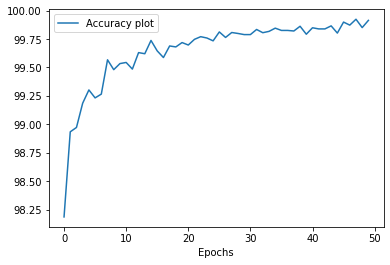

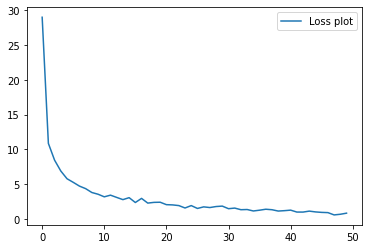

In [ ]:
mnist_random = Model(epochs=EP_10, fc=FC_10)
epochs_plot, accuracy_plot, loss_plot = mnist_random.train_validate(name='mnist_vanilla', mnist=True, batch_size=256, save_name='mnist_vanilla')
plot(epochs_plot, loss_plot, accuracy_plot)

Test the accuracy of the random initialized CNN on the MNIST test dataset

In [ ]:
mnist_random.test_mnist()

  0%|          | 0/10000 [00:00<?, ?it/s]

Starting testing on test dataset
-------------------------------


10240it [00:01, 6578.82it/s]                          


Accuracy on test dataset : 9956 / 10000 = 99.56
--------------------------------


Train the pre trained network on the shuffled MNIST dataset


model loaded from path : /content/drive/MyDrive/Colab Notebooks/models/train_digits-49.pth


  0%|          | 0/6000000 [00:00<?, ?it/s]


Starting epoch 1


  1%|          | 59904/6000000 [00:21<35:01, 2826.65it/s]


loss at epoch 1 : 575.8875184059143
Starting testing on train dataset
-------------------------------


  2%|▏         | 119808/6000000 [00:40<30:09, 3249.17it/s]


Accuracy on train dataset : 6958 / 60000 = 11.596666666666666
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-0.pth

Starting epoch 2


  3%|▎         | 180224/6000000 [01:02<32:55, 2945.66it/s]


loss at epoch 2 : 534.5623943805695
Starting testing on train dataset
-------------------------------


  4%|▍         | 240128/6000000 [01:22<33:59, 2823.50it/s]


Accuracy on train dataset : 7004 / 60000 = 11.673333333333334
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-1.pth

Starting epoch 3


  5%|▌         | 300800/6000000 [01:44<29:46, 3190.37it/s]


loss at epoch 3 : 529.6337416172028
Starting testing on train dataset
-------------------------------


  6%|▌         | 360960/6000000 [02:03<27:21, 3434.53it/s]


Accuracy on train dataset : 7170 / 60000 = 11.95
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-2.pth

Starting epoch 4


  7%|▋         | 420864/6000000 [02:25<33:03, 2812.80it/s]


loss at epoch 4 : 527.0382232666016
Starting testing on train dataset
-------------------------------


  8%|▊         | 481024/6000000 [02:44<26:29, 3471.69it/s]


Accuracy on train dataset : 7381 / 60000 = 12.301666666666666
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-3.pth

Starting epoch 5


  9%|▉         | 541440/6000000 [03:06<27:35, 3297.25it/s]


loss at epoch 5 : 525.4857485294342
Starting testing on train dataset
-------------------------------


 10%|█         | 601600/6000000 [03:26<26:09, 3440.61it/s]


Accuracy on train dataset : 7306 / 60000 = 12.176666666666666
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-4.pth

Starting epoch 6


 11%|█         | 661248/6000000 [03:49<28:32, 3117.61it/s]


loss at epoch 6 : 524.62668800354
Starting testing on train dataset
-------------------------------


 12%|█▏        | 721408/6000000 [04:08<28:40, 3068.78it/s]


Accuracy on train dataset : 7214 / 60000 = 12.023333333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-5.pth

Starting epoch 7


 13%|█▎        | 782080/6000000 [04:30<25:20, 3430.62it/s]


loss at epoch 7 : 523.6442856788635
Starting testing on train dataset
-------------------------------


 14%|█▍        | 841984/6000000 [04:50<24:14, 3545.16it/s]


Accuracy on train dataset : 7221 / 60000 = 12.035
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-6.pth

Starting epoch 8


 15%|█▌        | 901888/6000000 [05:11<26:28, 3208.81it/s]


loss at epoch 8 : 523.0809025764465
Starting testing on train dataset
-------------------------------


 16%|█▌        | 962560/6000000 [05:31<23:22, 3591.51it/s]


Accuracy on train dataset : 7324 / 60000 = 12.206666666666667
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-7.pth

Starting epoch 9


 17%|█▋        | 1022720/6000000 [05:52<26:26, 3136.79it/s]


loss at epoch 9 : 522.6309728622437
Starting testing on train dataset
-------------------------------


 18%|█▊        | 1082880/6000000 [06:12<23:29, 3487.65it/s]


Accuracy on train dataset : 7439 / 60000 = 12.398333333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-8.pth

Starting epoch 10


 19%|█▉        | 1142784/6000000 [06:34<25:12, 3212.04it/s]


loss at epoch 10 : 522.0504443645477
Starting testing on train dataset
-------------------------------


 20%|██        | 1202944/6000000 [06:54<22:16, 3588.65it/s]


Accuracy on train dataset : 7274 / 60000 = 12.123333333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-9.pth

Starting epoch 11


 21%|██        | 1262848/6000000 [07:15<27:35, 2861.88it/s]


loss at epoch 11 : 521.5567555427551
Starting testing on train dataset
-------------------------------


 22%|██▏       | 1323008/6000000 [07:34<25:39, 3038.24it/s]


Accuracy on train dataset : 7432 / 60000 = 12.386666666666667
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-10.pth

Starting epoch 12


 23%|██▎       | 1383424/6000000 [07:56<25:55, 2967.12it/s]


loss at epoch 12 : 521.1025545597076
Starting testing on train dataset
-------------------------------


 24%|██▍       | 1443328/6000000 [08:16<23:14, 3266.46it/s]


Accuracy on train dataset : 7498 / 60000 = 12.496666666666666
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-11.pth

Starting epoch 13


 25%|██▌       | 1503488/6000000 [08:38<27:13, 2751.85it/s]


loss at epoch 13 : 520.9095575809479
Starting testing on train dataset
-------------------------------


 26%|██▌       | 1563904/6000000 [08:59<23:29, 3146.50it/s]


Accuracy on train dataset : 7398 / 60000 = 12.33
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-12.pth

Starting epoch 14


 27%|██▋       | 1623808/6000000 [09:20<23:14, 3138.11it/s]


loss at epoch 14 : 520.3652830123901
Starting testing on train dataset
-------------------------------


 28%|██▊       | 1684480/6000000 [09:40<20:51, 3449.11it/s]


Accuracy on train dataset : 7639 / 60000 = 12.731666666666667
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-13.pth

Starting epoch 15


 29%|██▉       | 1744384/6000000 [10:02<23:45, 2985.32it/s]


loss at epoch 15 : 519.9029085636139
Starting testing on train dataset
-------------------------------


 30%|███       | 1804544/6000000 [10:22<22:03, 3169.00it/s]


Accuracy on train dataset : 7579 / 60000 = 12.631666666666666
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-14.pth

Starting epoch 16


 31%|███       | 1864960/6000000 [10:43<21:13, 3246.78it/s]


loss at epoch 16 : 519.9017331600189
Starting testing on train dataset
-------------------------------


 32%|███▏      | 1924864/6000000 [11:03<20:11, 3364.74it/s]


Accuracy on train dataset : 7648 / 60000 = 12.746666666666666
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-15.pth

Starting epoch 17


 33%|███▎      | 1984768/6000000 [11:25<22:25, 2984.75it/s]


loss at epoch 17 : 519.4393265247345
Starting testing on train dataset
-------------------------------


 34%|███▍      | 2045440/6000000 [11:45<18:14, 3614.40it/s]


Accuracy on train dataset : 7641 / 60000 = 12.735
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-16.pth

Starting epoch 18


 35%|███▌      | 2105344/6000000 [12:07<20:18, 3195.75it/s]


loss at epoch 18 : 519.1905386447906
Starting testing on train dataset
-------------------------------


 36%|███▌      | 2165760/6000000 [12:26<18:04, 3535.27it/s]


Accuracy on train dataset : 7932 / 60000 = 13.22
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-17.pth

Starting epoch 19


 37%|███▋      | 2225664/6000000 [12:49<19:30, 3225.92it/s]


loss at epoch 19 : 518.7405564785004
Starting testing on train dataset
-------------------------------


 38%|███▊      | 2285568/6000000 [13:09<19:32, 3167.54it/s]


Accuracy on train dataset : 7915 / 60000 = 13.191666666666666
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-18.pth

Starting epoch 20


 39%|███▉      | 2345728/6000000 [13:31<21:10, 2875.92it/s]


loss at epoch 20 : 518.2994508743286
Starting testing on train dataset
-------------------------------


 40%|████      | 2405888/6000000 [13:51<21:12, 2823.60it/s]


Accuracy on train dataset : 8029 / 60000 = 13.381666666666666
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-19.pth

Starting epoch 21


 41%|████      | 2466304/6000000 [14:13<19:21, 3041.95it/s]


loss at epoch 21 : 518.1082727909088
Starting testing on train dataset
-------------------------------


 42%|████▏     | 2526208/6000000 [14:33<18:10, 3185.93it/s]


Accuracy on train dataset : 8162 / 60000 = 13.603333333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-20.pth

Starting epoch 22


 43%|████▎     | 2586368/6000000 [14:55<18:54, 3009.69it/s]


loss at epoch 22 : 517.8897638320923
Starting testing on train dataset
-------------------------------


 44%|████▍     | 2646528/6000000 [15:14<19:44, 2830.90it/s]


Accuracy on train dataset : 8098 / 60000 = 13.496666666666666
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-21.pth

Starting epoch 23


 45%|████▌     | 2707200/6000000 [15:36<16:57, 3235.01it/s]


loss at epoch 23 : 517.2686862945557
Starting testing on train dataset
-------------------------------


 46%|████▌     | 2767104/6000000 [15:56<15:07, 3564.02it/s]


Accuracy on train dataset : 8357 / 60000 = 13.928333333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-22.pth

Starting epoch 24


 47%|████▋     | 2827520/6000000 [16:17<14:50, 3561.17it/s]


loss at epoch 24 : 516.616003036499
Starting testing on train dataset
-------------------------------


 48%|████▊     | 2887680/6000000 [16:37<14:45, 3515.08it/s]


Accuracy on train dataset : 8270 / 60000 = 13.783333333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-23.pth

Starting epoch 25


 49%|████▉     | 2947584/6000000 [16:59<17:16, 2946.14it/s]


loss at epoch 25 : 516.5560629367828
Starting testing on train dataset
-------------------------------


 50%|█████     | 3008000/6000000 [17:19<14:46, 3374.96it/s]


Accuracy on train dataset : 8358 / 60000 = 13.93
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-24.pth

Starting epoch 26


 51%|█████     | 3067904/6000000 [17:41<15:49, 3088.42it/s]


loss at epoch 26 : 515.6567783355713
Starting testing on train dataset
-------------------------------


 52%|█████▏    | 3127808/6000000 [18:00<14:42, 3254.41it/s]


Accuracy on train dataset : 8597 / 60000 = 14.328333333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-25.pth

Starting epoch 27


 53%|█████▎    | 3188224/6000000 [18:21<15:03, 3112.62it/s]


loss at epoch 27 : 515.4008839130402
Starting testing on train dataset
-------------------------------


 54%|█████▍    | 3248640/6000000 [18:40<13:18, 3444.77it/s]


Accuracy on train dataset : 8668 / 60000 = 14.446666666666667
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-26.pth

Starting epoch 28


 55%|█████▌    | 3308544/6000000 [19:02<14:56, 3001.08it/s]


loss at epoch 28 : 514.7017939090729
Starting testing on train dataset
-------------------------------


 56%|█████▌    | 3368704/6000000 [19:22<13:52, 3160.82it/s]


Accuracy on train dataset : 8777 / 60000 = 14.628333333333334
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-27.pth

Starting epoch 29


 57%|█████▋    | 3429120/6000000 [19:43<12:46, 3352.14it/s]


loss at epoch 29 : 513.9115998744965
Starting testing on train dataset
-------------------------------


 58%|█████▊    | 3489024/6000000 [20:03<12:25, 3368.46it/s]


Accuracy on train dataset : 8909 / 60000 = 14.848333333333333
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-28.pth

Starting epoch 30


 59%|█████▉    | 3548928/6000000 [20:24<13:12, 3092.61it/s]


loss at epoch 30 : 513.5316047668457
Starting testing on train dataset
-------------------------------


 60%|██████    | 3609344/6000000 [20:44<10:41, 3729.01it/s]


Accuracy on train dataset : 9291 / 60000 = 15.485
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-29.pth

Starting epoch 31


 61%|██████    | 3669248/6000000 [21:05<12:50, 3026.93it/s]


loss at epoch 31 : 512.1951150894165
Starting testing on train dataset
-------------------------------


 62%|██████▏   | 3729920/6000000 [21:24<09:50, 3846.57it/s]


Accuracy on train dataset : 9342 / 60000 = 15.57
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-30.pth

Starting epoch 32


 63%|██████▎   | 3790080/6000000 [21:46<10:46, 3420.56it/s]


loss at epoch 32 : 511.73741912841797
Starting testing on train dataset
-------------------------------


 64%|██████▍   | 3849984/6000000 [22:05<10:11, 3515.27it/s]


Accuracy on train dataset : 9366 / 60000 = 15.61
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-31.pth

Starting epoch 33


 65%|██████▌   | 3909888/6000000 [22:27<12:15, 2841.45it/s]


loss at epoch 33 : 510.8272590637207
Starting testing on train dataset
-------------------------------


 66%|██████▌   | 3970048/6000000 [22:46<11:05, 3052.36it/s]


Accuracy on train dataset : 9604 / 60000 = 16.006666666666668
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-32.pth

Starting epoch 34


 67%|██████▋   | 4030720/6000000 [23:08<09:47, 3354.38it/s]


loss at epoch 34 : 510.06461238861084
Starting testing on train dataset
-------------------------------


 68%|██████▊   | 4090624/6000000 [23:27<10:01, 3174.89it/s]


Accuracy on train dataset : 9719 / 60000 = 16.198333333333334
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-33.pth

Starting epoch 35


 69%|██████▉   | 4151040/6000000 [23:48<09:10, 3357.21it/s]


loss at epoch 35 : 508.91632199287415
Starting testing on train dataset
-------------------------------


 70%|███████   | 4210944/6000000 [24:08<09:31, 3129.28it/s]


Accuracy on train dataset : 9921 / 60000 = 16.535
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-34.pth

Starting epoch 36


 71%|███████   | 4271104/6000000 [24:30<10:12, 2823.29it/s]


loss at epoch 36 : 507.9683926105499
Starting testing on train dataset
-------------------------------


 72%|███████▏  | 4331520/6000000 [24:49<07:39, 3628.68it/s]


Accuracy on train dataset : 10086 / 60000 = 16.81
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-35.pth

Starting epoch 37


 73%|███████▎  | 4391680/6000000 [25:10<07:56, 3377.80it/s]


loss at epoch 37 : 506.9603433609009
Starting testing on train dataset
-------------------------------


 74%|███████▍  | 4451840/6000000 [25:29<06:24, 4030.49it/s]


Accuracy on train dataset : 10328 / 60000 = 17.213333333333335
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-36.pth

Starting epoch 38


 75%|███████▌  | 4511744/6000000 [25:50<08:45, 2834.41it/s]


loss at epoch 38 : 506.3834218978882
Starting testing on train dataset
-------------------------------


 76%|███████▌  | 4572160/6000000 [26:09<06:23, 3719.19it/s]


Accuracy on train dataset : 10398 / 60000 = 17.33
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-37.pth

Starting epoch 39


 77%|███████▋  | 4632064/6000000 [26:30<07:33, 3017.89it/s]


loss at epoch 39 : 505.3965177536011
Starting testing on train dataset
-------------------------------


 78%|███████▊  | 4691968/6000000 [26:49<06:14, 3490.10it/s]


Accuracy on train dataset : 10641 / 60000 = 17.735
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-38.pth

Starting epoch 40


 79%|███████▉  | 4752128/6000000 [27:10<06:50, 3036.83it/s]


loss at epoch 40 : 504.00974464416504
Starting testing on train dataset
-------------------------------


 80%|████████  | 4812288/6000000 [27:29<05:31, 3585.69it/s]


Accuracy on train dataset : 10925 / 60000 = 18.208333333333332
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-39.pth

Starting epoch 41


 81%|████████  | 4872448/6000000 [27:50<06:11, 3038.33it/s]


loss at epoch 41 : 503.3281235694885
Starting testing on train dataset
-------------------------------


 82%|████████▏ | 4932608/6000000 [28:08<05:18, 3351.65it/s]


Accuracy on train dataset : 10845 / 60000 = 18.075
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-40.pth

Starting epoch 42


 83%|████████▎ | 4992768/6000000 [28:28<05:24, 3106.21it/s]


loss at epoch 42 : 501.9886450767517
Starting testing on train dataset
-------------------------------


 84%|████████▍ | 5052928/6000000 [28:47<04:41, 3366.97it/s]


Accuracy on train dataset : 11225 / 60000 = 18.708333333333332
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-41.pth

Starting epoch 43


 85%|████████▌ | 5113600/6000000 [29:08<04:26, 3328.43it/s]


loss at epoch 43 : 501.3687846660614
Starting testing on train dataset
-------------------------------


 86%|████████▌ | 5173504/6000000 [29:26<03:47, 3629.11it/s]


Accuracy on train dataset : 11258 / 60000 = 18.763333333333332
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-42.pth

Starting epoch 44


 87%|████████▋ | 5233408/6000000 [29:47<03:59, 3203.56it/s]


loss at epoch 44 : 499.2082624435425
Starting testing on train dataset
-------------------------------


 88%|████████▊ | 5293824/6000000 [30:06<03:19, 3539.63it/s]


Accuracy on train dataset : 11518 / 60000 = 19.196666666666665
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-43.pth

Starting epoch 45


 89%|████████▉ | 5353984/6000000 [30:27<03:11, 3373.46it/s]


loss at epoch 45 : 499.15229535102844
Starting testing on train dataset
-------------------------------


 90%|█████████ | 5413888/6000000 [30:45<02:54, 3361.62it/s]


Accuracy on train dataset : 11600 / 60000 = 19.333333333333332
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-44.pth

Starting epoch 46


 91%|█████████ | 5474048/6000000 [31:07<02:55, 2997.77it/s]


loss at epoch 46 : 497.6142771244049
Starting testing on train dataset
-------------------------------


 92%|█████████▏| 5534464/6000000 [31:26<02:18, 3366.63it/s]


Accuracy on train dataset : 11825 / 60000 = 19.708333333333332
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-45.pth

Starting epoch 47


 93%|█████████▎| 5594880/6000000 [31:48<01:57, 3435.85it/s]


loss at epoch 47 : 496.0225713253021
Starting testing on train dataset
-------------------------------


 94%|█████████▍| 5655040/6000000 [32:06<01:32, 3742.59it/s]


Accuracy on train dataset : 11991 / 60000 = 19.985
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-46.pth

Starting epoch 48


 95%|█████████▌| 5714944/6000000 [32:28<01:30, 3143.91it/s]


loss at epoch 48 : 495.19921374320984
Starting testing on train dataset
-------------------------------


 96%|█████████▌| 5774848/6000000 [32:46<01:11, 3151.00it/s]


Accuracy on train dataset : 11999 / 60000 = 19.998333333333335
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-47.pth

Starting epoch 49


 97%|█████████▋| 5835008/6000000 [33:08<00:58, 2825.71it/s]


loss at epoch 49 : 494.1472592353821
Starting testing on train dataset
-------------------------------


 98%|█████████▊| 5895424/6000000 [33:27<00:31, 3324.34it/s]


Accuracy on train dataset : 12344 / 60000 = 20.573333333333334
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-48.pth

Starting epoch 50


 99%|█████████▉| 5955840/6000000 [33:48<00:13, 3270.22it/s]


loss at epoch 50 : 492.3958640098572
Starting testing on train dataset
-------------------------------


6015744it [34:07, 3371.81it/s]


Accuracy on train dataset : 12752 / 60000 = 21.253333333333334
--------------------------------

saved model to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_pretrained_mnist-49.pth


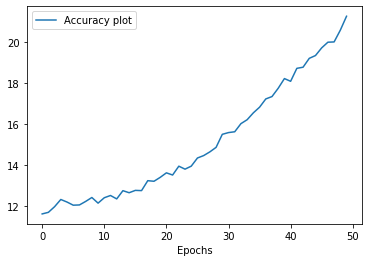

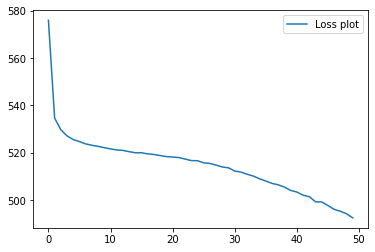

In [ ]:
destroy_mnist_pretrained = Model(epochs=EP_10, fc=FC_10)
destroy_mnist_pretrained.load(f'{save_dir}/models/train_digits_modified-{EP_10-1}.pth')
epochs_plot, accuracy_plot, loss_plot = destroy_mnist_pretrained.train_validate(name='mnistTask', mnist=False, batch_size=256, validation_split=0, save_name='destroy_pretrained_mnist')
plot(epochs_plot, loss_plot, accuracy_plot)

Test accuracy of the pre trained network on the MNIST test dataset

In [ ]:
destroy_mnist_pretrained.test_mnist()

  0%|          | 0/10000 [00:00<?, ?it/s]

Starting testing on test dataset
-------------------------------


10240it [00:01, 6650.55it/s]                          


Accuracy on test dataset : 15 / 10000 = 0.15
--------------------------------


Train a randomly initialized CNN on shuffled MNIST dataset

  0%|          | 0/6000000 [00:00<?, ?it/s]


Starting epoch 1


  1%|          | 59904/6000000 [00:20<31:21, 3156.45it/s]


loss at epoch 1 : 543.3726654052734
Starting testing on train dataset
-------------------------------


  2%|▏         | 119808/6000000 [00:40<31:08, 3146.48it/s]


Accuracy on train dataset : 6855 / 60000 = 11.425
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-0.pth

Starting epoch 2


  3%|▎         | 179968/6000000 [01:01<33:51, 2864.41it/s]


loss at epoch 2 : 530.9421207904816
Starting testing on train dataset
-------------------------------


  4%|▍         | 240384/6000000 [01:20<30:05, 3189.79it/s]


Accuracy on train dataset : 6884 / 60000 = 11.473333333333333
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-1.pth

Starting epoch 3


  5%|▌         | 300544/6000000 [01:41<30:53, 3074.51it/s]


loss at epoch 3 : 527.1270723342896
Starting testing on train dataset
-------------------------------


  6%|▌         | 360448/6000000 [02:01<29:46, 3156.57it/s]


Accuracy on train dataset : 7197 / 60000 = 11.995
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-2.pth

Starting epoch 4


  7%|▋         | 421120/6000000 [02:22<28:28, 3265.66it/s]


loss at epoch 4 : 525.4669125080109
Starting testing on train dataset
-------------------------------


  8%|▊         | 481024/6000000 [02:41<28:02, 3279.38it/s]


Accuracy on train dataset : 7149 / 60000 = 11.915
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-3.pth

Starting epoch 5


  9%|▉         | 541440/6000000 [03:03<26:39, 3412.12it/s]


loss at epoch 5 : 524.516339302063
Starting testing on train dataset
-------------------------------


 10%|█         | 601344/6000000 [03:22<26:56, 3339.37it/s]


Accuracy on train dataset : 7136 / 60000 = 11.893333333333333
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-4.pth

Starting epoch 6


 11%|█         | 661760/6000000 [03:44<26:01, 3418.16it/s]


loss at epoch 6 : 523.3128263950348
Starting testing on train dataset
-------------------------------


 12%|█▏        | 721664/6000000 [04:03<27:48, 3162.88it/s]


Accuracy on train dataset : 7124 / 60000 = 11.873333333333333
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-5.pth

Starting epoch 7


 13%|█▎        | 781568/6000000 [04:24<30:34, 2844.29it/s]


loss at epoch 7 : 522.7935831546783
Starting testing on train dataset
-------------------------------


 14%|█▍        | 842240/6000000 [04:43<25:14, 3405.35it/s]


Accuracy on train dataset : 7346 / 60000 = 12.243333333333334
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-6.pth

Starting epoch 8


 15%|█▌        | 902144/6000000 [05:05<37:54, 2240.82it/s]


loss at epoch 8 : 522.4570100307465
Starting testing on train dataset
-------------------------------


 16%|█▌        | 962560/6000000 [05:25<24:27, 3431.53it/s]


Accuracy on train dataset : 7225 / 60000 = 12.041666666666666
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-7.pth

Starting epoch 9


 17%|█▋        | 1022464/6000000 [05:47<27:41, 2996.04it/s]


loss at epoch 9 : 521.7071757316589
Starting testing on train dataset
-------------------------------


 18%|█▊        | 1082624/6000000 [06:06<24:23, 3360.59it/s]


Accuracy on train dataset : 7312 / 60000 = 12.186666666666667
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-8.pth

Starting epoch 10


 19%|█▉        | 1142528/6000000 [06:28<26:17, 3078.57it/s]


loss at epoch 10 : 521.5546708106995
Starting testing on train dataset
-------------------------------


 20%|██        | 1202944/6000000 [06:47<23:34, 3390.55it/s]


Accuracy on train dataset : 7390 / 60000 = 12.316666666666666
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-9.pth

Starting epoch 11


 21%|██        | 1262848/6000000 [07:09<26:57, 2929.40it/s]


loss at epoch 11 : 520.7494220733643
Starting testing on train dataset
-------------------------------


 22%|██▏       | 1323264/6000000 [07:28<25:39, 3037.63it/s]


Accuracy on train dataset : 7568 / 60000 = 12.613333333333333
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-10.pth

Starting epoch 12


 23%|██▎       | 1383680/6000000 [07:49<23:53, 3221.13it/s]


loss at epoch 12 : 520.5569820404053
Starting testing on train dataset
-------------------------------


 24%|██▍       | 1443584/6000000 [08:09<23:01, 3298.28it/s]


Accuracy on train dataset : 7423 / 60000 = 12.371666666666666
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-11.pth

Starting epoch 13


 25%|██▌       | 1504000/6000000 [08:31<23:57, 3128.21it/s]


loss at epoch 13 : 520.2332670688629
Starting testing on train dataset
-------------------------------


 26%|██▌       | 1563904/6000000 [08:50<20:49, 3550.96it/s]


Accuracy on train dataset : 7550 / 60000 = 12.583333333333334
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-12.pth

Starting epoch 14


 27%|██▋       | 1624320/6000000 [09:12<21:39, 3366.98it/s]


loss at epoch 14 : 519.7138884067535
Starting testing on train dataset
-------------------------------


 28%|██▊       | 1684224/6000000 [09:31<20:35, 3494.30it/s]


Accuracy on train dataset : 7724 / 60000 = 12.873333333333333
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-13.pth

Starting epoch 15


 29%|██▉       | 1744384/6000000 [09:53<22:08, 3202.24it/s]


loss at epoch 15 : 519.4791648387909
Starting testing on train dataset
-------------------------------


 30%|███       | 1804544/6000000 [10:13<21:40, 3226.17it/s]


Accuracy on train dataset : 7682 / 60000 = 12.803333333333333
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-14.pth

Starting epoch 16


 31%|███       | 1864960/6000000 [10:35<20:56, 3290.03it/s]


loss at epoch 16 : 518.943193435669
Starting testing on train dataset
-------------------------------


 32%|███▏      | 1924864/6000000 [10:55<22:00, 3085.49it/s]


Accuracy on train dataset : 7773 / 60000 = 12.955
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-15.pth

Starting epoch 17


 33%|███▎      | 1984768/6000000 [11:16<23:28, 2851.01it/s]


loss at epoch 17 : 518.7077674865723
Starting testing on train dataset
-------------------------------


 34%|███▍      | 2044928/6000000 [11:36<22:17, 2956.67it/s]


Accuracy on train dataset : 7993 / 60000 = 13.321666666666667
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-16.pth

Starting epoch 18


 35%|███▌      | 2105344/6000000 [11:58<22:49, 2844.64it/s]


loss at epoch 18 : 518.1039118766785
Starting testing on train dataset
-------------------------------


 36%|███▌      | 2165760/6000000 [12:18<18:27, 3461.53it/s]


Accuracy on train dataset : 7927 / 60000 = 13.211666666666666
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-17.pth

Starting epoch 19


 37%|███▋      | 2225664/6000000 [12:39<19:31, 3222.93it/s]


loss at epoch 19 : 517.8672077655792
Starting testing on train dataset
-------------------------------


 38%|███▊      | 2285568/6000000 [12:59<20:03, 3086.52it/s]


Accuracy on train dataset : 8032 / 60000 = 13.386666666666667
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-18.pth

Starting epoch 20


 39%|███▉      | 2346240/6000000 [13:21<17:49, 3415.03it/s]


loss at epoch 20 : 517.7816457748413
Starting testing on train dataset
-------------------------------


 40%|████      | 2406144/6000000 [13:41<18:20, 3266.37it/s]


Accuracy on train dataset : 8291 / 60000 = 13.818333333333333
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-19.pth

Starting epoch 21


 41%|████      | 2466048/6000000 [14:04<20:48, 2831.21it/s]


loss at epoch 21 : 517.1220378875732
Starting testing on train dataset
-------------------------------


 42%|████▏     | 2526208/6000000 [14:24<19:31, 2964.87it/s]


Accuracy on train dataset : 8055 / 60000 = 13.425
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-20.pth

Starting epoch 22


 43%|████▎     | 2586624/6000000 [14:45<18:26, 3083.76it/s]


loss at epoch 22 : 516.5754773616791
Starting testing on train dataset
-------------------------------


 44%|████▍     | 2647040/6000000 [15:05<15:49, 3529.84it/s]


Accuracy on train dataset : 8252 / 60000 = 13.753333333333334
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-21.pth

Starting epoch 23


 45%|████▌     | 2706944/6000000 [15:26<17:42, 3100.65it/s]


loss at epoch 23 : 516.0343286991119
Starting testing on train dataset
-------------------------------


 46%|████▌     | 2767360/6000000 [15:46<15:47, 3411.69it/s]


Accuracy on train dataset : 8517 / 60000 = 14.195
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-22.pth

Starting epoch 24


 47%|████▋     | 2827264/6000000 [16:08<17:58, 2940.53it/s]


loss at epoch 24 : 515.7389953136444
Starting testing on train dataset
-------------------------------


 48%|████▊     | 2887168/6000000 [16:28<17:21, 2988.12it/s]


Accuracy on train dataset : 8428 / 60000 = 14.046666666666667
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-23.pth

Starting epoch 25


 49%|████▉     | 2947584/6000000 [16:49<17:19, 2935.87it/s]


loss at epoch 25 : 515.165354013443
Starting testing on train dataset
-------------------------------


 50%|█████     | 3007744/6000000 [17:09<14:18, 3486.04it/s]


Accuracy on train dataset : 8715 / 60000 = 14.525
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-24.pth

Starting epoch 26


 51%|█████     | 3068160/6000000 [17:30<14:53, 3279.72it/s]


loss at epoch 26 : 514.4062206745148
Starting testing on train dataset
-------------------------------


 52%|█████▏    | 3128064/6000000 [17:50<14:10, 3378.59it/s]


Accuracy on train dataset : 8941 / 60000 = 14.901666666666667
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-25.pth

Starting epoch 27


 53%|█████▎    | 3188480/6000000 [18:12<13:46, 3401.77it/s]


loss at epoch 27 : 513.5883345603943
Starting testing on train dataset
-------------------------------


 54%|█████▍    | 3248384/6000000 [18:32<14:58, 3061.91it/s]


Accuracy on train dataset : 9063 / 60000 = 15.105
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-26.pth

Starting epoch 28


 55%|█████▌    | 3308288/6000000 [18:54<15:44, 2848.85it/s]


loss at epoch 28 : 513.0236082077026
Starting testing on train dataset
-------------------------------


 56%|█████▌    | 3368960/6000000 [19:14<12:08, 3612.06it/s]


Accuracy on train dataset : 9150 / 60000 = 15.25
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-27.pth

Starting epoch 29


 57%|█████▋    | 3428864/6000000 [19:35<13:14, 3237.27it/s]


loss at epoch 29 : 512.6874413490295
Starting testing on train dataset
-------------------------------


 58%|█████▊    | 3488768/6000000 [19:55<13:08, 3183.79it/s]


Accuracy on train dataset : 9272 / 60000 = 15.453333333333333
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-28.pth

Starting epoch 30


 59%|█████▉    | 3548928/6000000 [20:16<14:41, 2779.93it/s]


loss at epoch 30 : 511.3147304058075
Starting testing on train dataset
-------------------------------


 60%|██████    | 3609344/6000000 [20:37<11:51, 3359.44it/s]


Accuracy on train dataset : 9457 / 60000 = 15.761666666666667
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-29.pth

Starting epoch 31


 61%|██████    | 3669248/6000000 [20:58<13:21, 2907.66it/s]


loss at epoch 31 : 510.42770290374756
Starting testing on train dataset
-------------------------------


 62%|██████▏   | 3729408/6000000 [21:17<12:36, 3000.83it/s]


Accuracy on train dataset : 9809 / 60000 = 16.348333333333333
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-30.pth

Starting epoch 32


 63%|██████▎   | 3789568/6000000 [21:39<12:30, 2945.66it/s]


loss at epoch 32 : 510.55983114242554
Starting testing on train dataset
-------------------------------


 64%|██████▍   | 3849984/6000000 [21:59<11:48, 3036.25it/s]


Accuracy on train dataset : 9644 / 60000 = 16.073333333333334
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-31.pth

Starting epoch 33


 65%|██████▌   | 3910400/6000000 [22:21<09:54, 3514.89it/s]


loss at epoch 33 : 508.9024770259857
Starting testing on train dataset
-------------------------------


 66%|██████▌   | 3970304/6000000 [22:40<10:31, 3216.52it/s]


Accuracy on train dataset : 9988 / 60000 = 16.64666666666667
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-32.pth

Starting epoch 34


 67%|██████▋   | 4030208/6000000 [23:02<11:08, 2945.32it/s]


loss at epoch 34 : 507.3874547481537
Starting testing on train dataset
-------------------------------


 68%|██████▊   | 4090880/6000000 [23:22<09:04, 3506.24it/s]


Accuracy on train dataset : 10186 / 60000 = 16.976666666666667
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-33.pth

Starting epoch 35


 69%|██████▉   | 4150784/6000000 [23:44<10:44, 2867.75it/s]


loss at epoch 35 : 507.27509355545044
Starting testing on train dataset
-------------------------------


 70%|███████   | 4210688/6000000 [24:04<09:30, 3135.45it/s]


Accuracy on train dataset : 10285 / 60000 = 17.141666666666666
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-34.pth

Starting epoch 36


 71%|███████   | 4270848/6000000 [24:25<09:37, 2995.72it/s]


loss at epoch 36 : 505.48592591285706
Starting testing on train dataset
-------------------------------


 72%|███████▏  | 4331520/6000000 [24:45<07:50, 3545.25it/s]


Accuracy on train dataset : 10414 / 60000 = 17.356666666666666
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-35.pth

Starting epoch 37


 73%|███████▎  | 4391424/6000000 [25:06<08:51, 3027.65it/s]


loss at epoch 37 : 504.6829218864441
Starting testing on train dataset
-------------------------------


 74%|███████▍  | 4451584/6000000 [25:26<08:23, 3073.15it/s]


Accuracy on train dataset : 10621 / 60000 = 17.701666666666668
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-36.pth

Starting epoch 38


 75%|███████▌  | 4511488/6000000 [25:48<07:51, 3153.80it/s]


loss at epoch 38 : 503.56915855407715
Starting testing on train dataset
-------------------------------


 76%|███████▌  | 4571904/6000000 [26:07<06:54, 3442.78it/s]


Accuracy on train dataset : 10834 / 60000 = 18.05666666666667
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-37.pth

Starting epoch 39


 77%|███████▋  | 4632320/6000000 [26:29<07:02, 3239.98it/s]


loss at epoch 39 : 502.2205808162689
Starting testing on train dataset
-------------------------------


 78%|███████▊  | 4692224/6000000 [26:48<06:30, 3352.24it/s]


Accuracy on train dataset : 10935 / 60000 = 18.225
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-38.pth

Starting epoch 40


 79%|███████▉  | 4752128/6000000 [27:10<06:50, 3040.65it/s]


loss at epoch 40 : 501.26397609710693
Starting testing on train dataset
-------------------------------


 80%|████████  | 4812800/6000000 [27:30<05:43, 3453.62it/s]


Accuracy on train dataset : 11193 / 60000 = 18.655
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-39.pth

Starting epoch 41


 81%|████████  | 4872960/6000000 [27:52<05:40, 3305.87it/s]


loss at epoch 41 : 500.2358183860779
Starting testing on train dataset
-------------------------------


 82%|████████▏ | 4932864/6000000 [28:11<05:17, 3356.99it/s]


Accuracy on train dataset : 11364 / 60000 = 18.94
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-40.pth

Starting epoch 42


 83%|████████▎ | 4992768/6000000 [28:33<05:25, 3093.40it/s]


loss at epoch 42 : 498.6385416984558
Starting testing on train dataset
-------------------------------


 84%|████████▍ | 5052928/6000000 [28:53<05:07, 3082.36it/s]


Accuracy on train dataset : 11525 / 60000 = 19.208333333333332
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-41.pth

Starting epoch 43


 85%|████████▌ | 5113600/6000000 [29:15<04:16, 3461.74it/s]


loss at epoch 43 : 497.8233678340912
Starting testing on train dataset
-------------------------------


 86%|████████▌ | 5173504/6000000 [29:34<04:16, 3227.32it/s]


Accuracy on train dataset : 11758 / 60000 = 19.596666666666668
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-42.pth

Starting epoch 44


 87%|████████▋ | 5233664/6000000 [29:56<04:08, 3079.12it/s]


loss at epoch 44 : 497.3852972984314
Starting testing on train dataset
-------------------------------


 88%|████████▊ | 5294080/6000000 [30:15<03:10, 3700.61it/s]


Accuracy on train dataset : 11794 / 60000 = 19.656666666666666
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-43.pth

Starting epoch 45


 89%|████████▉ | 5353984/6000000 [30:37<03:24, 3158.97it/s]


loss at epoch 45 : 495.40823316574097
Starting testing on train dataset
-------------------------------


 90%|█████████ | 5413888/6000000 [30:56<03:09, 3096.96it/s]


Accuracy on train dataset : 12078 / 60000 = 20.13
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-44.pth

Starting epoch 46


 91%|█████████ | 5474304/6000000 [31:18<03:00, 2908.65it/s]


loss at epoch 46 : 495.0719463825226
Starting testing on train dataset
-------------------------------


 92%|█████████▏| 5534720/6000000 [31:37<02:13, 3480.69it/s]


Accuracy on train dataset : 12165 / 60000 = 20.275
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-45.pth

Starting epoch 47


 93%|█████████▎| 5594624/6000000 [31:59<02:12, 3057.88it/s]


loss at epoch 47 : 493.0474455356598
Starting testing on train dataset
-------------------------------


 94%|█████████▍| 5655040/6000000 [32:19<01:42, 3355.57it/s]


Accuracy on train dataset : 12295 / 60000 = 20.491666666666667
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-46.pth

Starting epoch 48


 95%|█████████▌| 5714944/6000000 [32:40<01:31, 3099.73it/s]


loss at epoch 48 : 491.72550988197327
Starting testing on train dataset
-------------------------------


 96%|█████████▋| 5775104/6000000 [32:59<01:10, 3180.05it/s]


Accuracy on train dataset : 12360 / 60000 = 20.6
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-47.pth

Starting epoch 49


 97%|█████████▋| 5835008/6000000 [33:20<00:55, 2996.71it/s]


loss at epoch 49 : 490.4432988166809
Starting testing on train dataset
-------------------------------


 98%|█████████▊| 5895680/6000000 [33:40<00:30, 3420.80it/s]


Accuracy on train dataset : 12670 / 60000 = 21.116666666666667
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-48.pth

Starting epoch 50


 99%|█████████▉| 5955584/6000000 [34:02<00:14, 3147.95it/s]


loss at epoch 50 : 489.7877023220062
Starting testing on train dataset
-------------------------------


6015488it [34:22, 3164.66it/s]


Accuracy on train dataset : 12955 / 60000 = 21.591666666666665
--------------------------------

saved dataset to path : /content/drive/MyDrive/Colab Notebooks/models/destroy_random_mnist-49.pth


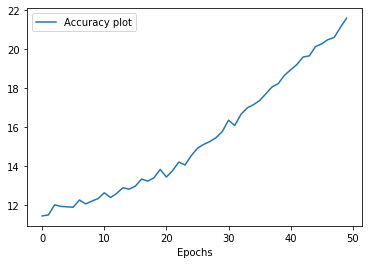

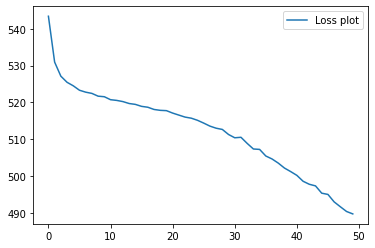

In [ ]:
destroy_mnist_random = Model(epochs=EP_10, fc=FC_10)
epochs_plot, accuracy_plot, loss_plot = destroy_mnist_random.train_validate(name='mnistTask', mnist=False, batch_size=256, validation_split=0, save_name='destroy_random_mnist')
plot(epochs_plot, loss_plot, accuracy_plot)

Check accuracy of the randomly initialized network on the MNIST test dataset

In [ ]:
destroy_mnist_random.test_mnist()

  0%|          | 0/10000 [00:00<?, ?it/s]

Starting testing on test dataset
-------------------------------


10240it [00:01, 5919.70it/s]                          


Accuracy on test dataset : 20 / 10000 = 0.2
--------------------------------
